In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
import os
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter

In [3]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) 
    return angle, angle_unwrapped

def get_cumulative_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    return frame_distances.cumsum()  

def get_displacement(data):
    x_displacement = (data['centroid_x'] - data['centroid_x'].iloc[0]) * 1/PIX_PER_MM
    y_displacement = (data['centroid_y'] - data['centroid_y'].iloc[0]) * 1/PIX_PER_MM
    return np.sqrt(x_displacement**2 + y_displacement**2)

class StimType(IntEnum):
    DARK = 0
    BRIGHT = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5

def get_cumulative_speed(data):
    # For frame-to-frame calculations, each time step is 1 unit
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    speed = frame_distances/ get_relative_time(data).diff()  # distance per frame
    return speed


In [4]:
def smooth_data(speed_data, method='gaussian', **kwargs):
    # Convert to pandas Series if not already
    data = pd.Series(speed_data)
    
    if method == 'gaussian':
        # Default parameters
        sigma = kwargs.get('sigma', 2)
        
        # Create a copy to avoid modifying the original
        smoothed = data.copy()
    
        # Apply Gaussian filter to data and mask
        smoothed = gaussian_filter1d(data.values, sigma=sigma)
        
    elif method == 'moving_avg':
        # Default parameters
        window = kwargs.get('window', 15)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply rolling window average
        smoothed = data.rolling(
            window=window, 
            center=True, 
            min_periods=min_periods
        ).mean()
        
    elif method == 'ewm':
        # Default parameters
        span = kwargs.get('span', 10)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply exponentially weighted moving average
        smoothed = data.ewm(
            span=span, 
            min_periods=min_periods
        ).mean()
    
    else:
        raise ValueError(f"Unknown smoothing method: {method}")
        
    return smoothed


def detect_fish_bouts_2(data, fish_id=None, method='gaussian', **kwargs):
    """
    Process fish movement data to detect swimming bouts
    
    Parameters:
    - data: DataFrame containing fish movement data
    - fish_id: Optional ID for the fish (for plot titles)
    - method: Smoothing method to use ('gaussian', 'moving_avg', 'ewm')
    - kwargs: Additional parameters for the smoothing method
    
    Returns:
    - DataFrame containing bout information
    """
    # Make a copy to avoid modifying the original data
    df = data.copy()
    
    smoothed_speed = smooth_data(df['speed'], method=method, **kwargs)
    df['smoothed_speed'] = smoothed_speed

    # Calculate threshold for bout detection
    mean_speed = np.mean(smoothed_speed)
    std_speed = np.std(smoothed_speed)
    threshold = mean_speed + 2 * std_speed
    
    # Find peaks in the smoothed data (potential bout centers)
    peaks, peak_properties = find_peaks(
        smoothed_speed, 
        height=threshold,
        distance=10,  # Minimum samples between peaks
        prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
    )
    
    # Find regions where speed exceeds threshold (bout regions)
    bout_indices = np.where(smoothed_speed > threshold)[0]
    
    # Group consecutive indices to identify complete bouts
    bout_groups = []
    for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 3:  # Minimum number of frames to be considered a bout
            bout_groups.append((group[0], group[-1]))
    
    # Track the number of bouts detected
    num_bouts_detected = len(bout_groups)
    # Create a DataFrame to store bout information
    bout_info = []
    for i, (start_idx, end_idx) in enumerate(bout_groups):
        # Find the peak within this bout
        bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
        if bout_peaks:
            peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
            peak_speed = smoothed_speed[peak_idx]
            
            # Calculate angle change
            angle_before_bout = np.unwrap(df['angle'].iloc[max(0, start_idx-1):start_idx+1])
            angle_after_bout = np.unwrap(df['angle'].iloc[end_idx:end_idx+2])
            angle_change = angle_after_bout[-1] - angle_before_bout[0]

            # Calculate mean distance traveled during the bout
            distance_during_bout = df['distance'].iloc[start_idx:end_idx+1].mean()
            

            # Calculate bout properties
            bout_info.append({
                'fish_id': fish_id,
                'bout_id': i+1,
                'start_idx': start_idx,
                'peak_idx': peak_idx,
                'end_idx': end_idx,
                'start_time': df['relative_time'].iloc[start_idx],
                'peak_time': df['relative_time'].iloc[peak_idx],
                'end_time': df['relative_time'].iloc[end_idx],
                'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
                'peak_speed': peak_speed,
                'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1]),
                'angle_change': angle_change,
                'distance_during_bout': distance_during_bout,  # distance traveled during the bout
                'num_bouts_detected': num_bouts_detected
            })
        
        print('Processing fish:', fish_id, 'shape:', len(bout_info))
    bout_df = pd.DataFrame(bout_info)
    print('Shape of bout_df:', bout_df.shape)
    
    # Calculate inter-bout intervals
    bout_df['inter_bout_interval'] = bout_df['start_time'].diff().shift(-1)
    
    return bout_df  

def plot_bout_detection(df, bout_df, fish_id, dpf):
    """
    Create plots to visualize the bout detection process
    
    Parameters:
    - df: DataFrame containing the processed data
    - bout_df: DataFrame containing bout information
    - fish_id: ID for the fish (for plot titles)
    """
    smoothed_speed = df['smoothed_speed']
    threshold = np.mean(smoothed_speed) + 2 * np.std(smoothed_speed)
    peaks = bout_df['peak_idx'].values
    bout_groups = bout_df[['start_idx', 'end_idx']].values
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Original vs Smoothed Speed
    ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
    ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
    ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    ax1.set_ylabel('Speed (mm/sec)')
    ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Detected Bouts
    ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
    ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
    # Highlight bout regions
    for start_idx, end_idx in bout_groups:
        start_time = df['relative_time'].iloc[start_idx]
        end_time = df['relative_time'].iloc[end_idx]
        ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
    # Mark peak points
    peak_times = df['relative_time'].iloc[peaks]
    peak_speeds = smoothed_speed.iloc[peaks]
    ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
    ax2.set_xlabel('Relative Time')
    ax2.set_ylabel('Speed (mm/sec)')
    ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id} and DPF: {dpf}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_bout_statistics(bout_df, fish_id, dpf):
    if len(bout_df) > 0:
        print(f"Total Number of bouts detected for fish_id {fish_id}, dpf {dpf}: {bout_df['num_bouts_detected'].iloc[0]}")
        print(f"Average bout duration for fish_id {fish_id}, dpf {dpf}: {bout_df['duration'].mean():.2f} time units")
        print(f"Average bout peak speed for fish_id {fish_id}, dpf {dpf} : {bout_df['peak_speed'].mean():.2f} mm/sec")
        print(f"Average bout mean speed for fish_id {fish_id}, dpf {dpf} : {bout_df['mean_speed'].mean():.2f} mm/sec")
        print(f"Average inter-bout interval for fish_id {fish_id}, dpf {dpf}  : {bout_df['inter_bout_interval'].mean():.2f} time units")
        print(f"Average angle change for fish_id {fish_id}, dpf {dpf}: {bout_df['angle_change'].mean():.2f} radians")
        print(f"Average distance traveled for fish_id {fish_id}, dpf {dpf}: {bout_df['distance_during_bout'].mean():.2f} mm") 
        print("\nTop 5 bouts by peak speedfor fish_id {fish_id}, dpf {dpf} :")
        print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])

def plot_histograms(bout_df, bins, fish_id, dpf):
    """
    Plot histograms of bout duration, inter-bout intervals (log-normal scale), and angle change.
    
    Parameters:
    - bout_df: DataFrame containing bout information
    """
    plt.figure(figsize=(20, 5))
    
    # Plot histogram of bout duration
    plt.subplot(1, 3, 1)
    plt.hist(bout_df['duration'], bins=bins, color='blue', alpha=0.7)
    plt.title(f'Bout Duration for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    
    
    # Plot histogram of inter-bout intervals (log-transformed but displayed in original units)
    plt.subplot(1, 3, 2)
    log_intervals = bout_df['log_inter_bout_interval'].dropna()  # Use the precomputed log-transformed column
    plt.hist(log_intervals, bins=bins, color='green', alpha=0.7)
    
    # Adjust x-axis ticks to show original units
    original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
    plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
    
    plt.title(f'Inter-Bout Intervals (Log-Transformed) for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Interval (seconds)')
    plt.ylabel('Frequency')
    
    # Plot histogram of angle change
    plt.subplot(1, 3, 3)
    plt.hist(bout_df['angle_change'], bins=bins, color='red', alpha=0.7)
    plt.title(f'Angle Change During Bouts for Fish ID: {fish_id} and DPF: {dpf}') 
    plt.xlabel('Angle Change (radians)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of distance traveled
    plt.subplot(2, 2, 4)
    plt.hist(bout_df['distance_during_bout'], bins=bins, color='purple', alpha=0.7)
    plt.title(f'Distance Traveled During Bouts for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Distance (mm)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Plot histogram of mean speed during bouts
    plt.subplot(2, 3, 5)
    plt.hist(bout_df['mean_speed'], bins=bins, color='orange', alpha=0.7)
    plt.title(f'Mean Speed During Bouts for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    # Plot histogram of peak speed during bouts
    plt.subplot(2, 3, 6)
    plt.hist(bout_df['peak_speed'], bins=bins, color='cyan', alpha=0.7)
    plt.title(f'Peak Speed During Bouts for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Speed (mm/sec)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [5]:
def plot_trajectory(derived_fish_data, fish_id, dpf):
    """
    Plot the trajectory of a fish based on its centroid positions.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure(figsize=(12, 6))
    plt.scatter(
        derived_fish_data['centroid_x'] / PIX_PER_MM,
        derived_fish_data['centroid_y'] / PIX_PER_MM,
        c=derived_fish_data['relative_time'],
        cmap='viridis',
        s=20,
        alpha=0.85
    )
    plt.colorbar(label='Time (s)')
    plt.title(f'Fish Trajectory for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.plot(
        derived_fish_data['centroid_x'] / PIX_PER_MM,
        derived_fish_data['centroid_y'] / PIX_PER_MM,
        color='gray',
        linewidth=1.5,
        alpha=0.3
    )
    plt.show()


def plot_distance(derived_fish_data, fish_id, dpf):
    """
    Plot the cumulative distance traveled by a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(derived_fish_data['relative_time'], derived_fish_data['distance'], label='Distance (mm)')
    plt.title(f'Distance for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Relative Time')
    plt.ylabel('Distance (mm)')
    plt.legend()
    plt.show()


def plot_speed(derived_fish_data, fish_id, dpf):
    """
    Plot the speed of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(derived_fish_data['relative_time'], derived_fish_data['speed'], label='Speed (mm/sec)')
    plt.title(f'Speed for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Relative Time')
    plt.ylabel('Speed (mm/sec)')
    plt.legend()
    plt.show()


def plot_smoothed_speed(derived_fish_data, fish_id, dpf):
    """
    Plot the smoothed speed of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(derived_fish_data['relative_time'], derived_fish_data['smoothed_speed'], label='Smoothed Speed (mm/sec)', color='orange')
    plt.title(f'Smoothed Speed for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Relative Time')
    plt.ylabel('Smoothed Speed (mm/sec)')
    plt.legend()
    plt.show()


def plot_angle(derived_fish_data, fish_id, dpf):
    """
    Plot the heading angle of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(derived_fish_data['relative_time'], derived_fish_data['angle'], label='Angle')
    plt.title(f'Angle for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Relative Time')
    plt.ylabel('Angle (radians)')
    plt.yticks(
        ticks=[-np.pi, -np.pi/2, -3*np.pi/2, 0, np.pi/2, 3*np.pi/2, np.pi],
        labels=[r'$-\pi$', r'$-\pi/2$', r'$-3\pi/2$', '0', r'$\pi/2$', r'$3\pi/2$', r'$\pi$']
    )
    plt.legend()
    plt.show()


def plot_unwrapped_angle(derived_fish_data, fish_id, dpf):
    """
    Plot the unwrapped heading angle of a fish over time.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - fish_id (int): ID of the fish to plot.
    """
    #fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]
    plt.figure()
    plt.plot(derived_fish_data['relative_time'], derived_fish_data['unwrapped_angle'], label='Unwrapped Angle')
    plt.title(f'Unwrapped Angle for Fish ID: {fish_id} and DPF: {dpf}')
    plt.xlabel('Relative Time')
    plt.ylabel('Unwrapped Angle (radians)')
    plt.legend()
    plt.show()


def plot_all_metrics(derived_metrics_df, bout_properties_df, fish_id,dpf, bins):
    """
    Plot all metrics (trajectory, distance, speed, smoothed speed, angle, unwrapped angle)
    and print bout statistics for a specific fish ID.

    Parameters:
    - derived_metrics_df (pd.DataFrame): DataFrame containing derived metrics.
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - fish_id (int): ID of the fish to plot.
    """
    print(f"Plotting metrics and printing statistics for Fish ID and DPF: {fish_id}, {dpf}")
    
    # Print bout statistics
    bout_properties_df = bout_properties_df[bout_properties_df['dpf'] == dpf]
    fish_bout_data = bout_properties_df[bout_properties_df['fish_id'] == fish_id]
    print_bout_statistics(fish_bout_data, fish_id,dpf)
   
    
    # Plot bout detection
    derived_metrics_df = derived_metrics_df[derived_metrics_df['dpf'] == dpf]
    derived_fish_data = derived_metrics_df[derived_metrics_df['fish_id'] == fish_id]

    plot_trajectory(derived_fish_data, fish_id, dpf)
    plot_distance(derived_fish_data, fish_id, dpf)
    plot_speed(derived_fish_data, fish_id, dpf)
    plot_smoothed_speed(derived_fish_data, fish_id, dpf)
    plot_angle(derived_fish_data, fish_id, dpf)
    plot_unwrapped_angle(derived_fish_data, fish_id, dpf)

    plot_bout_detection(derived_fish_data, fish_bout_data, fish_id, dpf)
    plt.show()
    
    # Plot histograms of bout properties
    print(f"Histograms for Fish ID and DPF: {fish_id}, {dpf}")
    plot_histograms(fish_bout_data,bins, fish_id, dpf)

In [6]:
def filter_extreme_angle_changes(derived_df, fish_id=None, window_ms=200):
    """
    Filters out extreme changes in angle from the derived_df DataFrame.

    Parameters:
    - derived_df (pd.DataFrame): DataFrame containing 'angle' (in radians), 'relative_time' (in seconds), and 'fish_id'.
    - fish_id (int, optional): Specific fish_id to process. If None, process all fish.
    - window_ms (int): Window size in milliseconds for calculating the threshold (default: 200ms).

    Returns:
    - filtered_df (pd.DataFrame): DataFrame with extreme angle changes filtered out.
    """
    # Convert window size from milliseconds to seconds
    window_s = window_ms / 1000.0

    # If a specific fish_id is provided, filter the DataFrame
    if fish_id is not None:
        grouped = derived_df[derived_df['fish_id'] == fish_id].groupby('fish_id')
    else:
        grouped = derived_df.groupby('fish_id')

    # Initialize a list to store filtered data
    filtered_data = []

    # Initialize a dictionary to track counts
    stats = {}

    # Process each fish_id group
    for fish_id, fish_data in grouped:
        fish_data = fish_data.copy()
        fish_data = fish_data.reset_index(drop=True)  # Reset index to avoid misalignment

        # Initialize counters for this fish_id
        passed_threshold = 0
        failed_threshold = 0

        #print(f"Processing fish_id: {fish_id}")

        # Create a list to store indices and updated angles
        updates = []

        # Iterate over the DataFrame with a rolling window
        for i in range(len(fish_data)):
            # Define the start and end of the window
            start_time = fish_data['relative_time'].iloc[i]
            end_time = start_time + window_s

            # Get the rows within the window
            window_data = fish_data[
                (fish_data['relative_time'] >= start_time) &
                (fish_data['relative_time'] < end_time)
            ]

            # Convert angles to complex numbers on the unit circle
            complex_angles = np.exp(1j * window_data['angle'])

            # Compute the mean of the complex numbers
            mean_complex = np.mean(complex_angles)

            # Extract the angle of the mean complex number
            unfolded_angle = np.angle(mean_complex)

            # Calculate the angular difference
            current_complex = np.exp(1j * fish_data['angle'].iloc[i])
            angle_diff = np.angle(current_complex / mean_complex)

            # Check if the angle difference is within the threshold
            if -np.pi / 2 <= angle_diff <= np.pi / 2:
                # Keep the row
                passed_threshold += 1
            else:
                # Log the angle before modification
                old_angle = fish_data['angle'].iloc[i]
                new_angle = old_angle + np.pi
                updates.append((i, new_angle, old_angle, angle_diff))
                failed_threshold += 1

        # Apply all updates at once and print debugging information
        for idx, new_angle, old_angle, angle_diff in updates:
            fish_data.loc[idx, 'angle'] = new_angle
            #print(f"Fish ID: {fish_id}, Index: {idx}, Relative Time: {fish_data.at[idx, 'relative_time']}")
            #print(f"Angle before adjustment: {old_angle}, Angle Diff: {angle_diff}")
            #print(f"Angle after adjustment: {fish_data.at[idx, 'angle']}")

        
        #print(f"Appending processed data for Fish ID: {fish_id}, Shape: {fish_data.shape}")
        filtered_data.append(fish_data)

        # Store stats for this fish_id
        stats[fish_id] = {
            'passed_threshold': passed_threshold,
            'failed_threshold': failed_threshold
        }

    # Combine all filtered data into a single DataFrame
    filtered_df = pd.concat(filtered_data, ignore_index=True)
    #print(f"Final concatenated DataFrame shape: {filtered_df.shape}")

    # Print summary stats
    print("\nSummary of Threshold Filtering:")
    for fish_id, counts in stats.items():
        print(f"Fish ID: {fish_id}, Passed: {counts['passed_threshold']}, Failed: {counts['failed_threshold']}")

    return filtered_df

In [7]:
def calculate_derived_metrics(dpf,data, label, output_folder=r'.\processed_data'):
    """
    Detect swimming bouts from derived metrics and save the bout properties to a CSV file.


    Returns:
    - derived_metrics_df (pd.DataFrame): DataFrame containing swimming properties, including duration, peak speed, and angle change.
    """
    
    derived_metrics_list = []
   
   #Filter out rows with zero centroid coordinates
    data = data[(data['centroid_x'] != 0) & (data['centroid_y'] != 0)]

    # Check if 'fish_id' exists
    data_filtered = data[data['dpf']==dpf]
    grouped_df = data_filtered.groupby('fish_id')
    for fish_id, group in grouped_df:
        group['relative_time'] = get_relative_time(group)
        group['relative_index'] = get_relative_index(group)
        group['distance'] = get_cumulative_distance(group)
        group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
        group['speed'] = get_cumulative_speed(group)
        group['smoothed_speed'] = smooth_data(group['speed'], method='gaussian', sigma=2)
        derived_metrics_list.append(group)
    
    derived_metrics_df = pd.concat(derived_metrics_list, ignore_index=True)
    derived_metrics_df = filter_extreme_angle_changes(derived_metrics_df, fish_id=None, window_ms=200)

    # Save derived metrics
    date_str = datetime.now().strftime('%Y%m%d')
    derived_metrics_path = os.path.join(output_folder, f'derived_metrics_{label}_{dpf}_{date_str}.csv')
    derived_metrics_df.to_csv(derived_metrics_path, index=False)
    print(f"Derived metrics saved to {derived_metrics_path}")

    return derived_metrics_df

In [8]:
def detect_and_save_bouts(dpf,derived_metrics_df,label, output_folder=r'.\processed_data', smoothing_method='gaussian', sigma=2):
    """
    Detect bouts from derived metrics and save the bout properties DataFrame.

    Parameters:
    - derived_metrics_df: DataFrame containing derived metrics for fish.
    - label: Label to append to the output file name (e.g., 'bright', 'dark', 'phototaxis').
    - smoothing_method: Method for smoothing speed (default: 'gaussian').
    - sigma: Smoothing parameter for Gaussian method (default: 2).

    Returns:
    - bout_properties_df: DataFrame containing bout properties.
    """

    # Initialize an empty list to store bout properties for all fish
    bout_properties_list = []

    # Group by fish_id
    grouped_df = derived_metrics_df.groupby('fish_id')
    for fish_id, group in grouped_df:
        # Discard the first point in the trajectory
        group = group.dropna(subset=['speed', 'distance'])

        # Detect bouts
        bout_df = detect_fish_bouts_2(group, fish_id=fish_id, method=smoothing_method, sigma=sigma)

        # Add fish_id to bout_df
        bout_df['fish_id'] = fish_id
        bout_df['dpf'] = group['dpf'].iloc[0]

        # Append bout_df to the list
        bout_properties_list.append(bout_df)

    # Combine all bout properties into a single DataFrame
    bout_properties_df = pd.concat(bout_properties_list, ignore_index=True)

    # Add a small constant (e.g., 1e-6) to avoid issues with log(0)
    bout_properties_df['log_inter_bout_interval'] = np.log(bout_properties_df['inter_bout_interval'] + 1e-6)

    # Save the bout properties DataFrame to a CSV file
    date_str = datetime.now().strftime('%Y%m%d')
    bout_properties_path = os.path.join(output_folder, f'bout_properties_{label}_{dpf}_{date_str}.csv')
    bout_properties_df.to_csv(bout_properties_path, index=False)
    print(f"Bout properties saved to {bout_properties_path}")

    return bout_properties_df

In [9]:
from scipy.stats import gaussian_kde

def calculate_kdes(bout_properties_df, columns, bandwidths):
    """
    Calculate KDEs for specified bout properties with custom bandwidths.

    Parameters:
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - columns (list): List of column names for which KDEs should be calculated.
    - bandwidths (dict): Dictionary of bandwidths for each column.

    Returns:
    - kde_dict (dict): Dictionary where keys are column names and values are KDE objects.
    """
    kde_dict = {}
    for column in columns:
        if column in bout_properties_df.columns:
            data = bout_properties_df[column].dropna().values  # Drop NaN values
            kde_dict[column] = gaussian_kde(data, bw_method=bandwidths.get(column, 0.2))  # Default bandwidth is 0.2
    return kde_dict


def plot_kde_histograms(kde_dict, bout_properties_df, bins_dict, dpf):
    """
    Plot histograms and KDEs for bout properties with custom bins.

    Parameters:
    - kde_dict (dict): Dictionary of KDE objects (output of `calculate_kdes`).
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - bins_dict (dict): Dictionary of bins for each column.

    Returns:
    - None
    """
    # Define custom X-axis labels for specific columns
    x_labels = {
        'distance_during_bout': 'distance_during_bout (mm)',
        'mean_speed': 'mean_speed during bout (mm/sec)',
        'peak_speed': 'peak_speed during bout (mm/sec)',
        'duration': 'bout duration (sec)',
        'angle_change': 'angle_change during bout (rad)',
        'log_inter_bout_interval': 'inter_bout_interval (sec)'
    }

    colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']  # Different colors for each plot
    columns = list(kde_dict.keys())
    plt.figure(figsize=(20, 10))

    for i, column in enumerate(columns, start=1):
        data = bout_properties_df[column].dropna().values
        kde = kde_dict[column]

        plt.subplot(2, 3, i)
        # Plot histogram
        plt.hist(data, bins=bins_dict.get(column, 20), density=True, alpha=0.5, color=colors[i - 1], label='Histogram')

        # Plot KDE
        x = np.linspace(min(data), max(data), 100)
        pdf = kde(x)
        plt.plot(x, pdf, color='red', label='KDE')

        # Special handling for log-transformed inter-bout intervals
        if column == 'log_inter_bout_interval':
            original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
            plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available
        else:
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available

        # Set titles and labels
        plt.title(f'Distribution of {column} for DPF: {dpf}')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_kde_histograms(kde_dict, bout_properties_df, bins_dict, dpf, use_percentile=False, global_limits=None):
    """
    Plot histograms and KDEs for bout properties with custom bins and consistent x-axis limits.

    Parameters:
    - kde_dict (dict): Dictionary of KDE objects (output of `calculate_kdes`).
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - bins_dict (dict): Dictionary of bins for each column.
    - dpf (int): Days post-fertilization (DPF) for labeling.
    - use_percentile (bool): If True, use the percentile approach for x-axis limits; otherwise, use global_min/global_max.
    - global_limits (dict): Dictionary containing global min, max, and percentiles for each column.
    """
    # Define custom X-axis labels for specific columns
    x_labels = {
        'distance_during_bout': 'distance_during_bout (mm)',
        'mean_speed': 'mean_speed during bout (mm/sec)',
        'peak_speed': 'peak_speed during bout (mm/sec)',
        'duration': 'bout duration (sec)',
        'angle_change': 'angle_change during bout (rad)',
        'log_inter_bout_interval': 'inter_bout_interval (sec)'
    }

    colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'brown']  # Different colors for each plot
    columns = list(kde_dict.keys())
    plt.figure(figsize=(20, 10))

    for i, column in enumerate(columns, start=1):
        data = bout_properties_df[column].dropna().values
        kde = kde_dict[column]

        # Calculate x-axis limits
        if use_percentile:
            # Percentile approach: Use 1st and 99th percentiles
            lower_limit = global_limits[column]['percentile_1']
            upper_limit = global_limits[column]['percentile_99']
        else:
            # Global min/max approach: Use global min and max values
            lower_limit = global_limits[column]['min']
            upper_limit = global_limits[column]['max']

        # Generate x values for KDE
        x = np.linspace(lower_limit, upper_limit, 100)
        pdf = kde(x)

        plt.subplot(2, 3, i)
        # Plot histogram
        plt.hist(data, bins=bins_dict.get(column, 20), density=True, alpha=0.5, color=colors[i - 1], label='Histogram')

        # Plot KDE
        plt.plot(x, pdf, color='red', label='KDE')

        # Special handling for log-transformed inter-bout intervals
        if column == 'log_inter_bout_interval':
            original_ticks = np.exp(plt.xticks()[0])  # Convert log-transformed ticks back to original scale
            plt.xticks(np.log(original_ticks), [f"{tick:.2f}" for tick in original_ticks])  # Set ticks and labels
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available
        else:
            plt.xlabel(x_labels.get(column, column))  # Use custom label if available

        # Set x-axis limits
        plt.xlim(lower_limit, upper_limit)

        # Set titles and labels
        plt.title(f'Distribution of {column} for DPF: {dpf}')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def simulate_2d_random_walk(kde_dict,bout_properties_df, paths=50, bouts_per_path=None):
    """
    Simulate a 2D random walk based on KDEs for bout properties.

    Parameters:
    - kde_dict (dict): Dictionary of KDE objects for bout properties.
    - bout_properties_df (pd.DataFrame): DataFrame containing bout properties.
    - paths (int): Number of independent random walk simulations.
    - bouts_per_path (int): Number of bouts per path. If None, it will be estimated from the KDEs.

    Returns:
    - X, Y, time (np.ndarray): Arrays representing the X and Y positions and time for each path.
    """
    if bouts_per_path is None:
        # Calculate bouts_per_path dynamically using num_bouts_detected
        # Group by fish_id and calculate the mean number of bouts detected per fish
        mean_bouts_per_fish = bout_properties_df.groupby('fish_id')['num_bouts_detected'].mean()

        # Calculate the overall mean number of bouts across all fish
        bouts_per_path = int(mean_bouts_per_fish.mean())
        print(f"Estimated bouts_per_path: {bouts_per_path}")

    # Resample from KDEs
    resampled_distance = kde_dict['distance_during_bout'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_log_intervals = kde_dict['log_inter_bout_interval'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_angle = kde_dict['angle_change'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_duration = kde_dict['duration'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)
    resampled_mean_speed = kde_dict['mean_speed'].resample(paths * bouts_per_path)[0].reshape(paths, bouts_per_path)

    # Initialize positions (start at origin for all paths)
    X = np.zeros((paths, bouts_per_path + 1))
    Y = np.zeros((paths, bouts_per_path + 1))
    time = np.zeros((paths, bouts_per_path + 1))  # Track time for each path

    # Simulate 2D random walk with bouts
    for path in range(paths):
        for bout in range(bouts_per_path):
            # Bout duration
            bout_duration = resampled_duration[path, bout]

            # Speed during the bout
            speed = resampled_mean_speed[path, bout]

            # Step size (distance traveled during the bout)
            step_size = speed * bout_duration  # Calculate step size based on speed and duration

            # Direction (angle of movement)
            angle = resampled_angle[path, bout]

            # Inter-bout interval (time between bouts)
            inter_bout_interval = np.exp(resampled_log_intervals[path, bout])  # Convert log interval back to original scale

            # Update position
            X[path, bout + 1] = X[path, bout] + step_size * np.cos(angle)
            Y[path, bout + 1] = Y[path, bout] + step_size * np.sin(angle)

            # Update time
            time[path, bout + 1] = time[path, bout] + bout_duration + inter_bout_interval

    return X, Y, time

def plot_random_walk(X, Y):
    """
    Plot the 2D random walk paths.

    Parameters:
    - X, Y (np.ndarray): Arrays representing the X and Y positions for each path.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    for path in range(X.shape[0]):
        ax.plot(X[path, :], Y[path, :], alpha=0.7)
    ax.scatter(X[:, 0], Y[:, 0], color='green', label='Start', zorder=5)  # Start points
    ax.scatter(X[:, -1], Y[:, -1], color='red', label='End', zorder=5)    # End points
    ax.set_title("2D Random Walk Based on Global Bout Properties")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.legend()
    ax.grid()
    plt.axis('equal')
    plt.show()

In [11]:
def save_csv(df, label, output_folder=r'.\processed_data'):
    """
    Save DataFrame to CSV file with a label and current date.

    Parameters:
    - df (pd.DataFrame): DataFrame to save.
    - label (str): Label for the file name.
    - output_folder (str): Folder to save the CSV file.

    Returns:
    - None
    """
    date_str = datetime.now().strftime('%Y%m%d')
    filename = f'{label}_{date_str}.csv'
    filepath = os.path.join(output_folder, filename)
    
    # Save DataFrame to CSV
    df.to_csv(filepath, index=False)
    print(f"Dataframe saved to {filepath}")

In [ ]:
######LOAD OLD DATA #######


DATA_FOLDER = r".\Modelling_data\Cichlids"

#All dpf Old data files
OLD_DATAFILES = [
    #'10_09dpf_Di_27_Aug_2024_17h17min12sec.csv', # shorter trials (600 sec each)
    #'11_09dpf_Di_27_Aug_2024_18h47min44sec.csv', # shorter trials (600 sec each)
    #'12_09dpf_Di_27_Aug_2024_20h27min13sec.csv', # shorter trials (600 sec each)
    #'08_10dpf_Mi_28_Aug_2024_10h18min41sec.csv', # shorter trials (600 sec each)
    #'09_10dpf_Mi_28_Aug_2024_11h44min03sec.csv', # shorter trials (600 sec each)
    #'10_10dpf_Mi_28_Aug_2024_13h16min25sec.csv', # shorter trials (600 sec each)
    #'11_10dpf_Mi_28_Aug_2024_14h30min41sec.csv', # shorter trials (600 sec each)
    #'12_10dpf_Mi_28_Aug_2024_16h21min17sec.csv', # shorter trials (600 sec each)
    #'13_10dpf_Mi_28_Aug_2024_17h41min49sec.csv', # shorter trials (600 sec each)

    #60fps data files
    '01_07dpf_Do_29_Aug_2024_09h50min07sec.csv',
    '02_07dpf_Do_29_Aug_2024_11h31min10sec.csv',
    '03_07dpf_Do_29_Aug_2024_13h06min01sec.csv',
    '04_07dpf_Do_29_Aug_2024_14h38min17sec.csv',
    '05_07dpf_Do_29_Aug_2024_16h11min51sec.csv',
    '06_07dpf_Do_29_Aug_2024_17h43min56sec.csv',
    '07_07dpf_Do_29_Aug_2024_19h17min38sec.csv',
    '01_08dpf_Fr_30_Aug_2024_09h26min14sec.csv',
    '02_08dpf_Fr_30_Aug_2024_11h11min11sec.csv',
    '03_08dpf_Fr_30_Aug_2024_12h42min49sec.csv',
    '04_08dpf_Fr_30_Aug_2024_14h15min52sec.csv',
    '05_08dpf_Fr_30_Aug_2024_15h47min53sec.csv',
    '06_08dpf_Fr_30_Aug_2024_17h17min41sec.csv',
    '07_08dpf_Fr_30_Aug_2024_18h48min39sec.csv',
    '02_10dpf_So_01_Sep_2024_11h51min15sec.csv',
    '03_10dpf_So_01_Sep_2024_14h42min31sec.csv',
    '04_10dpf_So_01_Sep_2024_16h12min08sec.csv',
    '05_10dpf_So_01_Sep_2024_17h42min55sec.csv',
    '06_10dpf_So_01_Sep_2024_19h13min20sec.csv',
    '07_10dpf_So_01_Sep_2024_20h44min18sec.csv',
    '14_10dpf_Mo_09_Sep_2024_12h17min25sec.csv',
    '15_10dpf_Mo_09_Sep_2024_13h49min54sec.csv',
    '16_10dpf_Mo_09_Sep_2024_15h24min48sec.csv',
    '17_10dpf_Mo_09_Sep_2024_18h07min58sec.csv',
    '09_07dpf_Di_17_Sep_2024_18h15min51sec.csv',
    '10_07dpf_Di_17_Sep_2024_19h46min28sec.csv',
    '11_07dpf_Di_17_Sep_2024_21h16min13sec.csv',
    '08_08dpf_Mi_18_Sep_2024_10h07min56sec.csv',
    '09_08dpf_Mi_18_Sep_2024_11h43min18sec.csv',
    '10_08dpf_Mi_18_Sep_2024_13h13min31sec.csv',
    '11_08dpf_Mi_18_Sep_2024_14h42min48sec.csv',
    '12_08dpf_Mi_18_Sep_2024_16h14min00sec.csv',
    '13_08dpf_Mi_18_Sep_2024_17h44min33sec.csv',
    '14_08dpf_Mi_18_Sep_2024_19h13min51sec.csv',
    '00_09dpf_Do_19_Sep_2024_10h05min11sec.csv',
    '01_09dpf_Do_19_Sep_2024_11h38min50sec.csv',
    '02_09dpf_Do_19_Sep_2024_13h07min20sec.csv',
    '03_09dpf_Do_19_Sep_2024_14h36min33sec.csv',
    '04_09dpf_Do_19_Sep_2024_16h08min06sec.csv',
    '05_09dpf_Do_19_Sep_2024_17h37min36sec.csv',
    '06_09dpf_Do_19_Sep_2024_19h06min10sec.csv',
    '07_09dpf_Do_19_Sep_2024_20h36min09sec.csv',
    '18_10dpf_Fr_20_Sep_2024_10h39min51sec.csv',
    '19_10dpf_Fr_20_Sep_2024_12h14min45sec.csv',
    '20_10dpf_Fr_20_Sep_2024_13h51min56sec.csv',
    '21_10dpf_Fr_20_Sep_2024_15h23min51sec.csv',
    '22_10dpf_Fr_20_Sep_2024_16h59min47sec.csv',
    '23_10dpf_Fr_20_Sep_2024_18h29min15sec.csv',
    '24_10dpf_Fr_20_Sep_2024_20h02min20sec.csv',

    #100fps data files
    '12_07dpf_Do_03_Okt_2024_10h58min16sec.csv',
    '13_07dpf_Do_03_Okt_2024_12h28min52sec.csv', 
    '14_07dpf_Do_03_Okt_2024_14h02min07sec.csv', 
    '15_07dpf_Do_03_Okt_2024_15h38min20sec.csv', 
    '16_07dpf_Do_03_Okt_2024_17h07min50sec.csv', 
    '17_07dpf_Do_03_Okt_2024_18h37min36sec.csv'
] 


#10 dpf Old data files 
""" DATAFILES = [
    '08_10dpf_Mi_28_Aug_2024_10h18min41sec.csv',
    '09_10dpf_Mi_28_Aug_2024_11h44min03sec.csv',
    '10_10dpf_Mi_28_Aug_2024_13h16min25sec.csv',
    '11_10dpf_Mi_28_Aug_2024_14h30min41sec.csv',
    '12_10dpf_Mi_28_Aug_2024_16h21min17sec.csv',
    '13_10dpf_Mi_28_Aug_2024_17h41min49sec.csv', 
    '02_10dpf_So_01_Sep_2024_11h51min15sec.csv',
    '03_10dpf_So_01_Sep_2024_14h42min31sec.csv',
    '04_10dpf_So_01_Sep_2024_16h12min08sec.csv',
    #'05_10dpf_So_01_Sep_2024_17h42min55sec.csv',
    '06_10dpf_So_01_Sep_2024_19h13min20sec.csv',
    '07_10dpf_So_01_Sep_2024_20h44min18sec.csv',
    '14_10dpf_Mo_09_Sep_2024_12h17min25sec.csv',
    '15_10dpf_Mo_09_Sep_2024_13h49min54sec.csv',
    '16_10dpf_Mo_09_Sep_2024_15h24min48sec.csv',
    '17_10dpf_Mo_09_Sep_2024_18h07min58sec.csv',
    '18_10dpf_Fr_20_Sep_2024_10h39min51sec.csv',
    '19_10dpf_Fr_20_Sep_2024_12h14min45sec.csv',
    '20_10dpf_Fr_20_Sep_2024_13h51min56sec.csv',
    '21_10dpf_Fr_20_Sep_2024_15h23min51sec.csv',
    '22_10dpf_Fr_20_Sep_2024_16h59min47sec.csv',
    '23_10dpf_Fr_20_Sep_2024_18h29min15sec.csv',
    '24_10dpf_Fr_20_Sep_2024_20h02min20sec.csv'

] """


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in OLD_DATAFILES:
    fish_id, dpf, date = parse_filename(file)
    
    # Read and preprocess data
    data = pd.read_csv(os.path.join(DATA_FOLDER, file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    
    # Remove columns with "tail_point" in the name
    data_filtered = data_filtered.loc[:, ~data_filtered.columns.str.contains("tail_point")]
    
    # Add parsed metadata to each row
    data_filtered['fish_id'] = fish_id
    data_filtered['dpf'] = dpf
    data_filtered['date'] = date
    
    # Group by specific stimulus types and concatenate
    for stim in target_stims:
         stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
         stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Ensure the processed_data folder exism, df in stim_dataframes.items():
    if not data_filtered.empty:
        # Append the date to the filename
        date_str = datetime.now().strftime('%Y%m%d')
        filename = f'{stim.name.lower()}_data_{date_str}.csv'
        filepath = os.path.join(r'.\processed_data', filename)
        
        # Check if the file already exists
        if not os.path.exists(filepath):
            data_filtered.to_csv(filepath, index=False)


In [ ]:
# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

# Ensure the processed_data folder exists
output_folder = r'.\processed_data'
os.makedirs(output_folder, exist_ok=True)

for file in OLD_DATAFILES:
    try:
        # Parse metadata from the filename
        fish_id, dpf, date = parse_filename(file)
        
        # Read and preprocess data
        data = pd.read_csv(os.path.join(DATA_FOLDER, file))
        data_filtered = data.groupby('image_index').first()
        data_filtered = data_filtered[1:]  # Skip the first row if necessary
        data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
        
        # Remove columns with "tail_point" in the name
        data_filtered = data_filtered.loc[:, ~data_filtered.columns.str.contains("tail_point")]
        
        # Add parsed metadata to each row
        data_filtered['fish_id'] = fish_id
        data_filtered['dpf'] = dpf
        data_filtered['date'] = date
        
        # Group by specific stimulus types and concatenate
        for stim in target_stims:
            stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
            stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data], ignore_index=True)
    
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Save each stimulus type DataFrame
for stim, df in stim_dataframes.items():
    if not df.empty:
        # Append the date to the filename
        date_str = datetime.now().strftime('%Y%m%d')
        filename = f'{stim.name.lower()}_data_old_{date_str}.csv'
        filepath = os.path.join(output_folder, filename)
        
        # Save the DataFrame to a CSV file
        df.to_csv(filepath, index=False)
        print(f"Saved {stim.name} data to {filepath}")
    else:
        print(f"No data found for stimulus type {stim.name}")

Saved DARK data to .\processed_data\dark_data_20250612.csv
Saved BRIGHT data to .\processed_data\bright_data_20250612.csv
Saved PHOTOTAXIS data to .\processed_data\phototaxis_data_20250612.csv


In [13]:
DATA_FOLDER = r".\Modelling_data\Cichlids"
NEW_DATAFILES = [
    ('stim_00_07dpf_Cichlid_Do_24_Apr_2025_12h00min07sec.csv', 'tracking_00_07dpf_Cichlid_Thu_24_Apr_2025_12h00min07sec.csv'), # bad flipping example
    ('stim_00_08dpf_Cichlid_Fr_25_Apr_2025_11h21min18sec.csv', 'tracking_00_08dpf_Cichlid_Fri_25_Apr_2025_11h21min17sec.csv'),
    ('stim_00_09dpf_Cichlid_Sa_26_Apr_2025_10h25min21sec.csv', 'tracking_00_09dpf_Cichlid_Sat_26_Apr_2025_10h25min20sec.csv'), 
    ('stim_01_07dpf_Cichlid_Do_24_Apr_2025_13h42min37sec.csv', 'tracking_01_07dpf_Cichlid_Thu_24_Apr_2025_13h42min37sec.csv'),
    ('stim_01_08dpf_Cichlid_Fr_25_Apr_2025_12h49min10sec.csv', 'tracking_01_08dpf_Cichlid_Fri_25_Apr_2025_12h49min09sec.csv'),
    ('stim_01_09dpf_Cichlid_Sa_26_Apr_2025_11h53min47sec.csv', 'tracking_01_09dpf_Cichlid_Sat_26_Apr_2025_11h53min46sec.csv'),
    ('stim_02_07dpf_Cichlid_Do_24_Apr_2025_15h04min23sec.csv', 'tracking_02_07dpf_Cichlid_Thu_24_Apr_2025_15h04min23sec.csv'),
    ('stim_02_08dpf_Cichlid_Fr_25_Apr_2025_14h17min23sec.csv', 'tracking_02_08dpf_Cichlid_Fri_25_Apr_2025_14h17min23sec.csv'),
    ('stim_02_09dpf_Cichlid_Sa_26_Apr_2025_12h53min44sec.csv', 'tracking_02_09dpf_Cichlid_Sat_26_Apr_2025_12h53min44sec.csv'),
    ('stim_03_07dpf_Cichlid_Do_24_Apr_2025_16h12min34sec.csv', 'tracking_03_07dpf_Cichlid_Thu_24_Apr_2025_16h12min34sec.csv'),
    ('stim_03_08dpf_Cichlid_Fr_25_Apr_2025_15h19min53sec.csv', 'tracking_03_08dpf_Cichlid_Fri_25_Apr_2025_15h19min52sec.csv'),
    ('stim_03_09dpf_Cichlid_Sa_26_Apr_2025_14h27min00sec.csv', 'tracking_03_09dpf_Cichlid_Sat_26_Apr_2025_14h27min00sec.csv'),
    ('stim_04_08dpf_Cichlid_Fr_25_Apr_2025_16h27min57sec.csv', 'tracking_04_08dpf_Cichlid_Fri_25_Apr_2025_16h27min56sec.csv'),
    ('stim_04_09dpf_Cichlid_Sa_26_Apr_2025_15h42min49sec.csv', 'tracking_04_09dpf_Cichlid_Sat_26_Apr_2025_15h42min49sec.csv'),
    ('stim_05_08dpf_Cichlid_Fr_25_Apr_2025_17h37min00sec.csv', 'tracking_05_08dpf_Cichlid_Fri_25_Apr_2025_17h36min59sec.csv'),
    ('stim_05_09dpf_Cichlid_Sa_26_Apr_2025_16h47min50sec.csv', 'tracking_05_09dpf_Cichlid_Sat_26_Apr_2025_16h47min51sec.csv')
]

class PolarityNew(IntEnum):
    DARKLEFT = 1
    DARKRIGHT = -1
 
DPF = ['7dpf', '8dpf', '9dpf', '10dpf']
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]

def load_data_new(stim_file: str, tracking_file: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Use os.path.join to construct the full file paths
    tracking = pd.read_csv(
        os.path.join(DATA_FOLDER, tracking_file), 
        usecols=['timestamp', 'pc1_x', 'pc1_y', 'centroid_x', 'centroid_y']
    )
    stim = pd.read_csv(
        os.path.join(DATA_FOLDER, stim_file), 
        usecols=['timestamp', 'time_sec', 'stim_id', 'phototaxis_polarity']
    )
    return stim, tracking

def get_relative_time_sec(data: pd.DataFrame):
    first_timestamp = data.iloc[0].timestamp
    relative_time_ns = data.timestamp - first_timestamp
    return 1e-9*relative_time_ns

def parse_stim_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple[int, int, datetime]:
    # Define the regular expression pattern for stim_file names
    regexp = re.compile(r"""
        stim_                           # Prefix 'stim_'
        (?P<fish_id>\d+)_               # Fish ID (digits)
        (?P<dpf>\d+)dpf_                # Days post-fertilization (digits followed by 'dpf')
        \w+_                            # Day of the week (e.g., Do, Fr, Sa)
        (?P<datetime>\d+_\w+_\d+_\d+h\d+min\d+sec)  # Date and time
        \.csv$                          # File extension
        """, re.VERBOSE)

    # Match the filename against the pattern
    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f"Wrong filename format: {filename}")

    # Extract fish_id and dpf
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))

    # Parse the date using the locale
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'), '%d_%b_%Y_%Hh%Mmin%Ssec')

    return fish_id, dpf, date

In [14]:
def get_stimulus_data(
    stim_file: str,
    tracking_file: str,
    stim_type: StimType,
    cumulative_df: pd.DataFrame = None
) -> pd.DataFrame:
    # Parse metadata from the filename
    fish_id, dpf, date = parse_stim_filename(stim_file)

    # Load the stimulus and tracking data
    stim, tracking = load_data_new(stim_file, tracking_file)

    # Initialize a list to store filtered data
    filtered_tracking_list = []

    # Handle phototaxis as a special case with polarity
    polarities = [1, -1] if stim_type == StimType.PHOTOTAXIS else [None]

    for polarity in polarities:
        # Filter the stimulus data
        if polarity is not None:
            data = stim.loc[(stim.stim_id == stim_type) & (stim.phototaxis_polarity == polarity)]
        else:
            data = stim.loc[stim.stim_id == stim_type]

        if data.empty:
            print(f"No data found for stim_type={stim_type} with polarity={polarity}")
            continue

        # Extract the start and stop timestamps
        start = data['timestamp'].iloc[0]
        stop = data['timestamp'].iloc[-1]

        # Filter the tracking data based on the timestamps
        filtered_tracking = tracking.loc[(start <= tracking.timestamp) & (tracking.timestamp <= stop)].copy()

        # Convert timestamps to relative time in seconds
        filtered_tracking['t_local'] = 1e-9* filtered_tracking['timestamp'] #get_relative_time_sec(filtered_tracking)
        
        # Add metadata columns
        filtered_tracking['stim_id'] = stim_type.value
        filtered_tracking['fish_id'] = fish_id
        filtered_tracking['dpf'] = dpf
        filtered_tracking['date'] = date

        # Add polarity column for phototaxis
        filtered_tracking['phototaxis_polarity'] = -1 if polarity == 1 else (1 if polarity == -1 else 0)

        # Append to the list
        filtered_tracking_list.append(filtered_tracking)

    # Combine all filtered data
    if filtered_tracking_list:
        filtered_tracking = pd.concat(filtered_tracking_list, ignore_index=True)
    else:
        raise ValueError(f"No data found for stim_type={stim_type}")

    # Update the cumulative DataFrame
    if cumulative_df is None:
        cumulative_df = filtered_tracking
    else:
        cumulative_df = pd.concat([cumulative_df, filtered_tracking], ignore_index=True)

    return cumulative_df


#######  LOAD NEW DATA  #######
target_stims = [StimType.DARK, StimType.BRIGHT, StimType.PHOTOTAXIS]
cumulative_data_by_stim = {stim_type: None for stim_type in target_stims}

for stim_file, tracking_file in NEW_DATAFILES:
    for stim_type in target_stims:
        try:
            cumulative_data_by_stim[stim_type] = get_stimulus_data(
                stim_file=stim_file,
                tracking_file=tracking_file,
                stim_type=stim_type,
                cumulative_df=cumulative_data_by_stim[stim_type]
            )
        except ValueError as e:
            print(f"Error processing {stim_file}, {tracking_file}, Stimulus: {stim_type.name}: {e}")

# Save the cumulative DataFrames after processing all files
for stim_type, cumulative_df in cumulative_data_by_stim.items():
    if cumulative_df is not None:
        date_str = pd.Timestamp.now().strftime('%Y%m%d')
        filename = f"{stim_type.name.lower()}_data_new_{date_str}.csv"#previous_name:bright_combined_data
        filepath = os.path.join(r'.\\processed_data', filename)
        cumulative_df.to_csv(filepath, index=False)
        print(f"Saved {stim_type.name} data to {filepath}")

Saved DARK data to .\\processed_data\dark_data_new_20250625.csv
Saved BRIGHT data to .\\processed_data\bright_data_new_20250625.csv
Saved PHOTOTAXIS data to .\\processed_data\phototaxis_data_new_20250625.csv


In [15]:
PROCESSED_DATA_FOLDER = r'.\processed_data'
def combine_new_and_old_data(old_df_path:str, new_df_path:str) -> pd.DataFrame:
    old_df = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, old_df_path))
    new_df = pd.read_csv(os.path.join(PROCESSED_DATA_FOLDER, new_df_path))

    old_df = old_df[['t_local', 'centroid_x', 'centroid_y', 'pc1_x', 'pc1_y', 'stim_id', 'fish_id', 'dpf', 'date', 'phototaxis_polarity']]

    # Calculate the highest fish_id for each dpf in the old dataset
    max_fish_id_per_dpf = old_df.groupby('dpf')['fish_id'].max()

    # Offset the fish_id in the new dataset for each dpf to avoid conflicts
    new_df['fish_id'] = new_df.apply(
        lambda row: row['fish_id'] + max_fish_id_per_dpf.get(row['dpf'], 0) + 1,
        axis=1
    )

    combined_df = pd.concat([old_df, new_df], ignore_index=True)
    return combined_df

In [16]:
bright_df = combine_new_and_old_data(
    old_df_path='bright_data_20250612.csv',
    new_df_path='bright_data_new_20250625.csv'
)
all_derived_metrics_l = []
all_bout_proeprties_l = []
DPF = [7,8,9,10]
#filter_extreme_angle_changes is now called within the calculate_derived_metrics function, 
# so we can use the derived_metrics_df_bright_og directly
for dpf in DPF:
    derived_metrics_df_bright = calculate_derived_metrics(dpf, data=bright_df,
        label='bright', output_folder=r'.\processed_data')

    bout_properties_df_bright = detect_and_save_bouts(dpf, derived_metrics_df=derived_metrics_df_bright,
        label='bright',output_folder=r'.\processed_data',
        smoothing_method='gaussian', sigma=2) 
    
    all_derived_metrics_l.append(derived_metrics_df_bright)
    all_bout_proeprties_l.append(bout_properties_df_bright) 

derived_metrics_df_bright_all_dpf = pd.concat(all_derived_metrics_l, ignore_index=True)
bout_properties_df_bright_all_dpf = pd.concat(all_bout_proeprties_l, ignore_index=True)

save_csv(derived_metrics_df_bright_all_dpf, label='derived_metrics_bright_all_dpf', output_folder=r'.\processed_data')
print(f"Combined derived_metrics_df_bright contains data for all dpfs: {derived_metrics_df_bright_all_dpf['dpf'].unique()}")

save_csv(bout_properties_df_bright_all_dpf, label='bout_properties_bright_all_dpf', output_folder=r'.\processed_data') 
print(f"Combined bout_properties_df_bright contains data for all dpfs: {bout_properties_df_bright_all_dpf['dpf'].unique()}")
#Add dpf cplumn to bout properties - done, added in detect_and_save_bouts function

#read the dfs as lists because we are now looping over each dpf and it create new df for each dpf

#also call the next plotting function in this same for loop and pass the dpf parameter as input if necessary


Summary of Threshold Filtering:
Fish ID: 1, Passed: 17885, Failed: 121
Fish ID: 2, Passed: 17957, Failed: 50
Fish ID: 3, Passed: 17826, Failed: 180
Fish ID: 4, Passed: 17753, Failed: 253
Fish ID: 5, Passed: 17872, Failed: 135
Fish ID: 6, Passed: 17838, Failed: 167
Fish ID: 7, Passed: 17884, Failed: 123
Fish ID: 9, Passed: 16990, Failed: 1015
Fish ID: 10, Passed: 17997, Failed: 9
Fish ID: 11, Passed: 17917, Failed: 90
Fish ID: 12, Passed: 35885, Failed: 94
Fish ID: 13, Passed: 29987, Failed: 17
Fish ID: 14, Passed: 29966, Failed: 43
Fish ID: 15, Passed: 29825, Failed: 182
Fish ID: 16, Passed: 29903, Failed: 98
Fish ID: 17, Passed: 29971, Failed: 26
Fish ID: 18, Passed: 29915, Failed: 79
Fish ID: 19, Passed: 29914, Failed: 80
Fish ID: 20, Passed: 29581, Failed: 115
Fish ID: 21, Passed: 29957, Failed: 37
Derived metrics saved to .\processed_data\derived_metrics_bright_7_20250625.csv
Processing fish: 1 shape: 1
Processing fish: 1 shape: 2
Processing fish: 1 shape: 3
Processing fish: 1 sha

In [464]:
derived_metrics_df_bright.fish_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [465]:
derived_metrics_df_bright.dpf.unique()

array([ 9,  7,  8, 10])

In [466]:
for each in derived_metrics_df_bright.dpf.unique():
    print(f"Number of fish in {each}: {derived_metrics_df_bright[derived_metrics_df_bright.dpf == each].fish_id.nunique()}")

Number of fish in 9: 14
Number of fish in 7: 20
Number of fish in 8: 20
Number of fish in 10: 17


In [467]:
for each in bright_df_old.dpf.unique():
    print(f"Number of fish in {each}: {bright_df_old[bright_df_old.dpf == each].fish_id.nunique()}")

Number of fish in 7: 16
Number of fish in 8: 14
Number of fish in 10: 17
Number of fish in 9: 8


In [468]:
for each in bright_df_new.dpf.unique():
    print(f"Number of fish in {each}: {bright_df_new[bright_df_new.dpf == each].fish_id.nunique()}")

Number of fish in 7: 4
Number of fish in 8: 6
Number of fish in 9: 6


In [496]:
for each in bout_properties_df_bright.dpf.unique():
    print(f"Number of fish in {each}: {bout_properties_df_bright[bout_properties_df_bright.dpf == each].fish_id.nunique()}")

Number of fish in 9: 1
Number of fish in 7: 10
Number of fish in 8: 3
Number of fish in 10: 11


Plotting metrics and printing statistics for Fish ID and DPF: 20, 7
Total Number of bouts detected for fish_id 20, dpf 7: 98
Average bout duration for fish_id 20, dpf 7: 0.07 time units
Average bout peak speed for fish_id 20, dpf 7 : 58.95 mm/sec
Average bout mean speed for fish_id 20, dpf 7 : 48.73 mm/sec
Average inter-bout interval for fish_id 20, dpf 7  : 3.06 time units
Average angle change for fish_id 20, dpf 7: 0.02 radians
Average distance traveled for fish_id 20, dpf 7: 1748.56 mm

Top 5 bouts by peak speedfor fish_id {fish_id}, dpf {dpf} :
      bout_id  start_time  duration  peak_speed
1630       15   38.180278  0.079692  411.300765
1633       18   50.140087  0.080208  323.707264
1619        3    9.989832  0.070009   92.733955
1629       14   36.890035  0.049990   86.919332
1640       25   59.940066  0.059998   83.730140


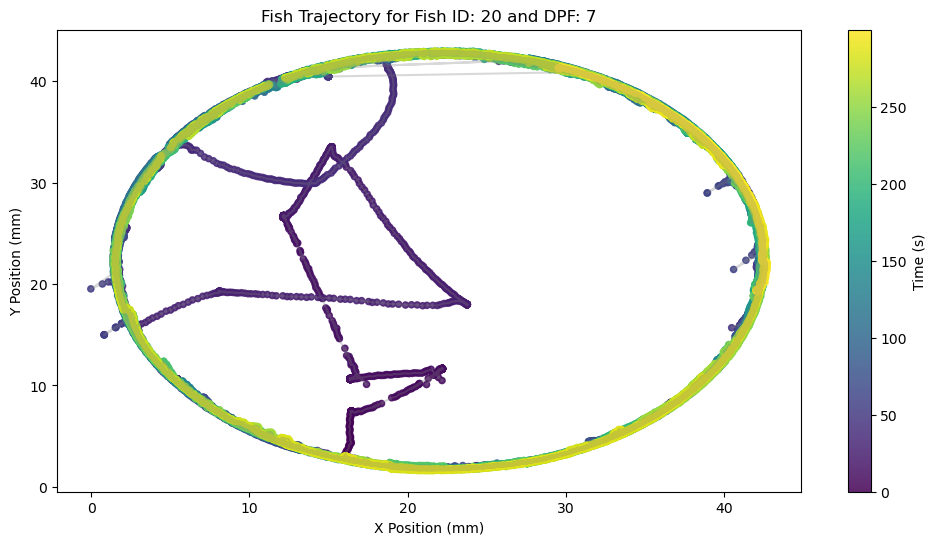

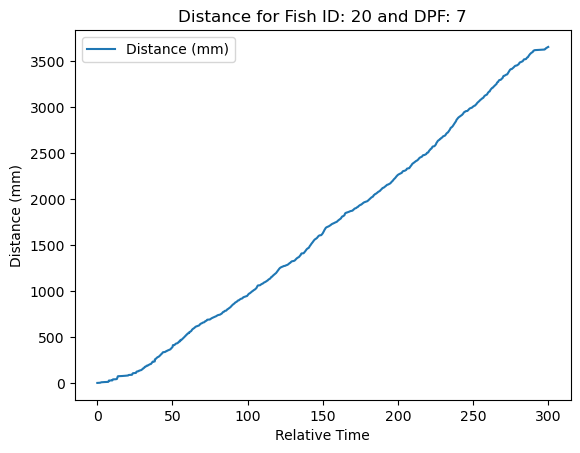

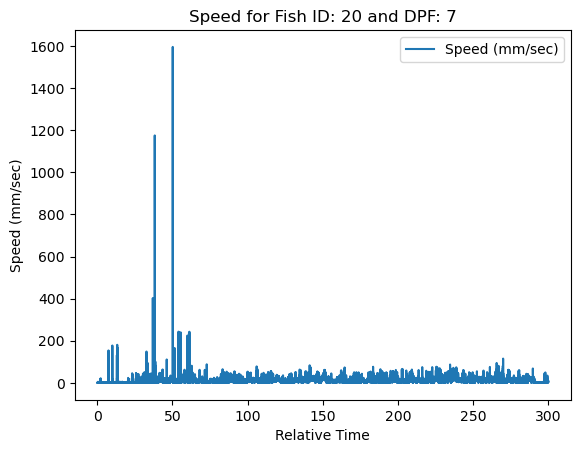

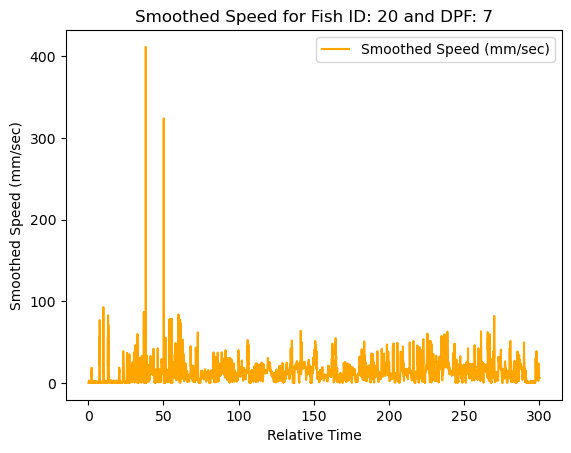

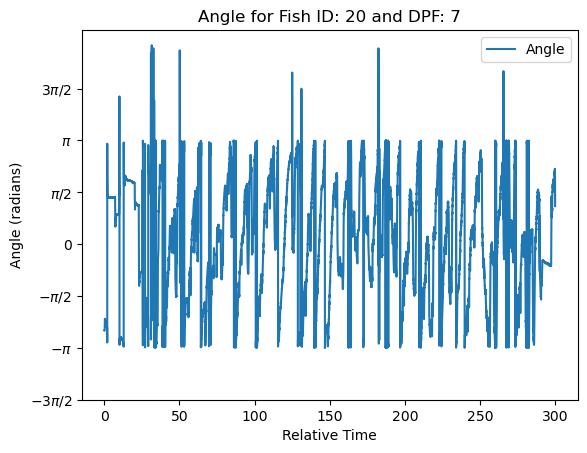

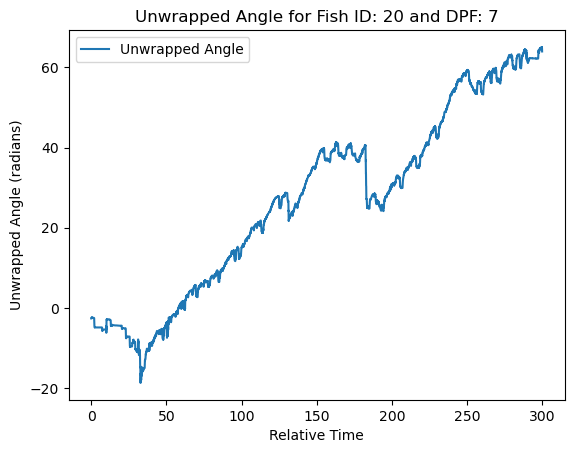

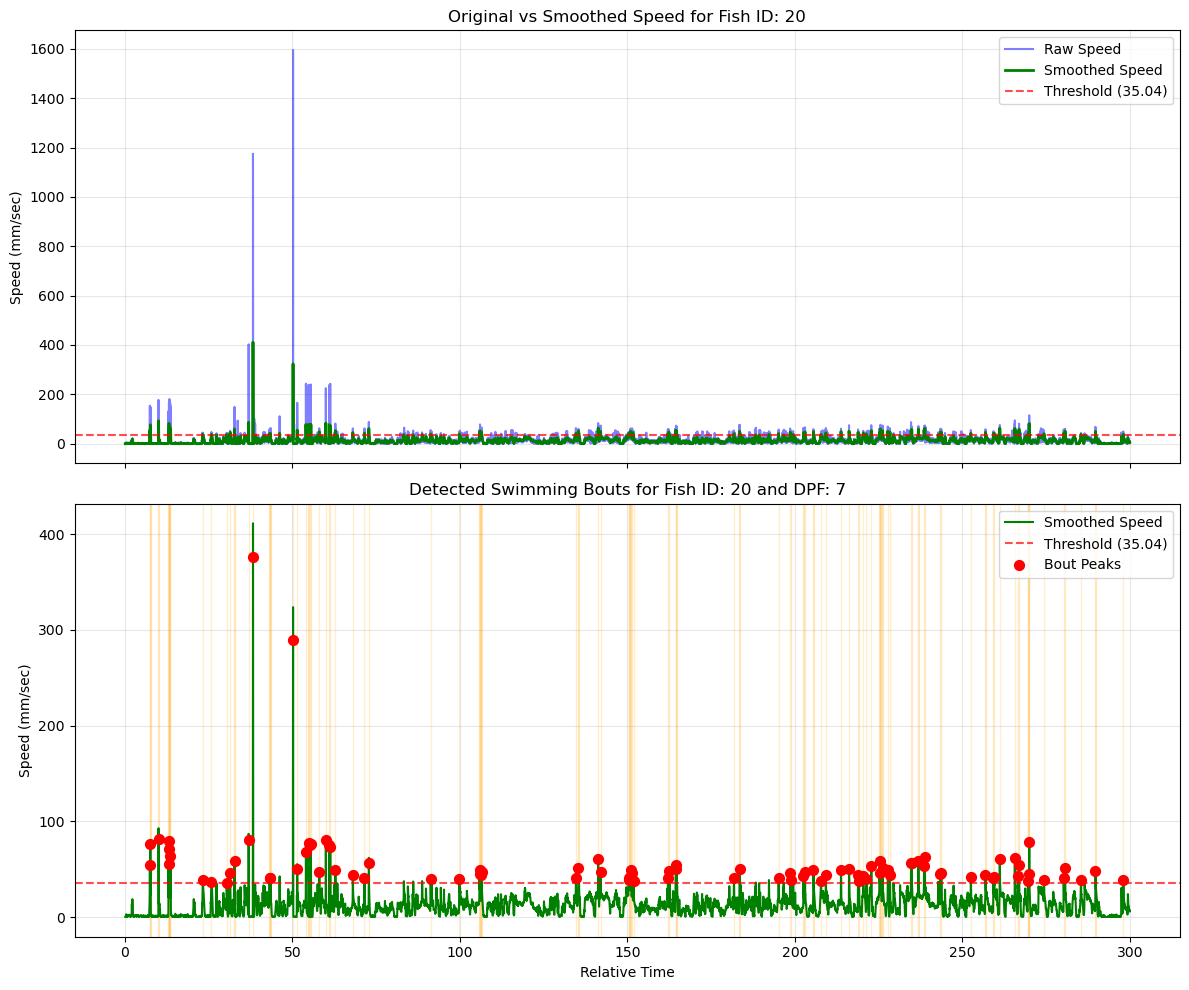

Histograms for Fish ID and DPF: 20, 7


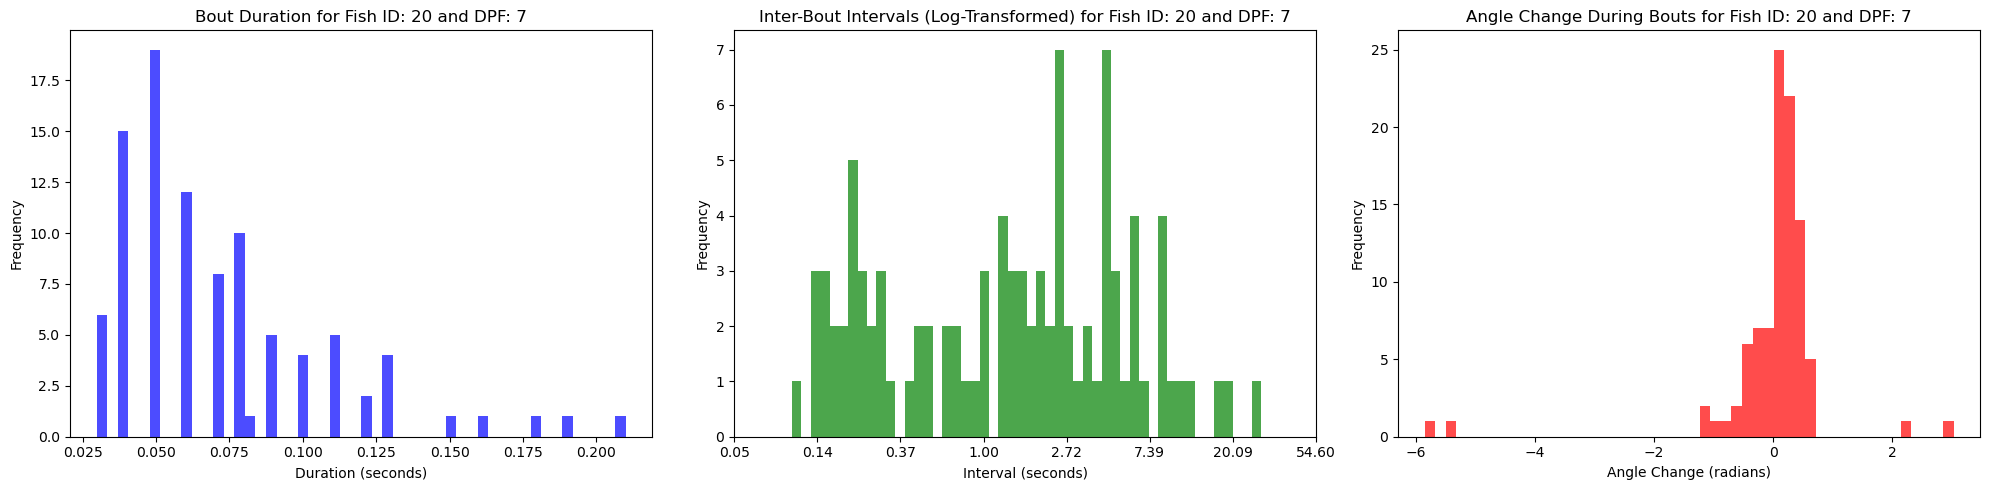

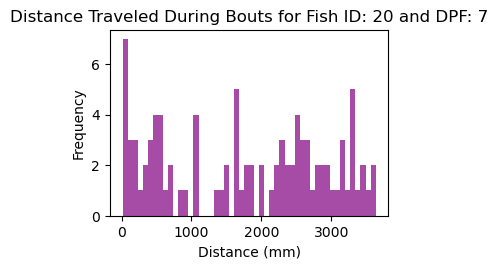

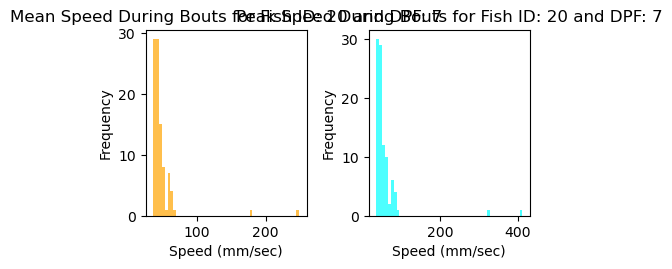

Plotting metrics and printing statistics for Fish ID and DPF: 20, 10
Total Number of bouts detected for fish_id 20, dpf 10: 29
Average bout duration for fish_id 20, dpf 10: 0.42 time units
Average bout peak speed for fish_id 20, dpf 10 : 19.14 mm/sec
Average bout mean speed for fish_id 20, dpf 10 : 15.22 mm/sec
Average inter-bout interval for fish_id 20, dpf 10  : 10.53 time units
Average angle change for fish_id 20, dpf 10: 0.16 radians
Average distance traveled for fish_id 20, dpf 10: 486.79 mm

Top 5 bouts by peak speedfor fish_id {fish_id}, dpf {dpf} :
      bout_id  start_time  duration  peak_speed
4189        7   63.501299  0.951217   43.194104
4183        1    0.646191  0.675974   31.074528
4193       11   93.756577  0.963231   28.148356
4187        5   58.367115  0.748633   27.355994
4190        8   88.505057  1.017413   24.919054


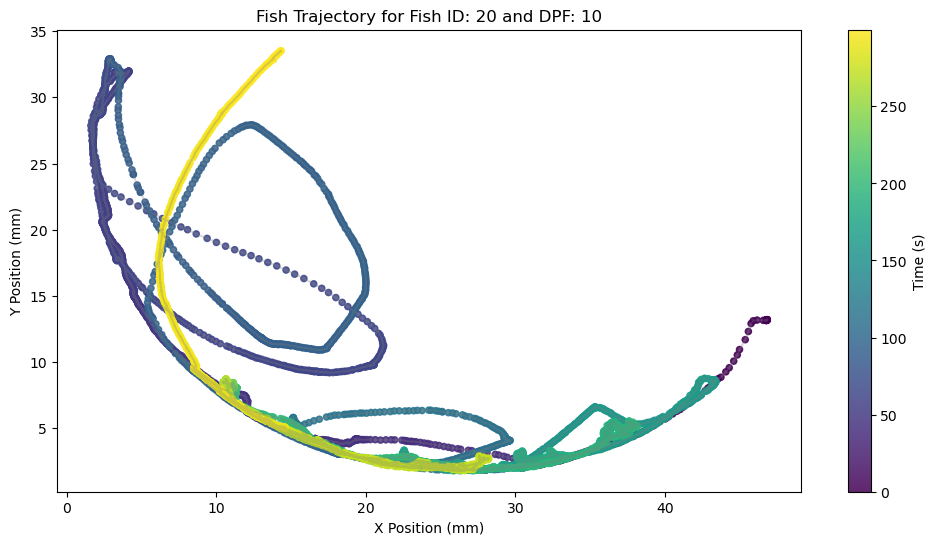

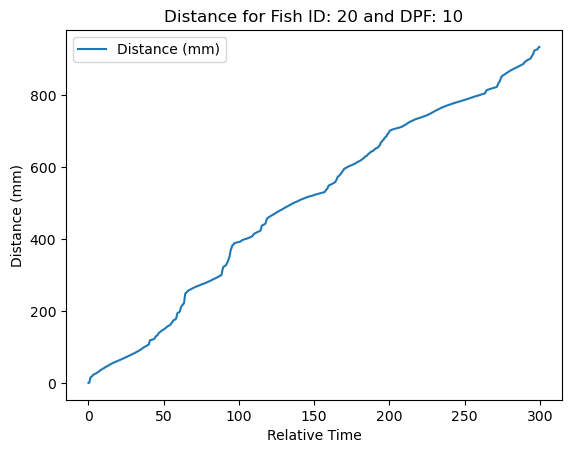

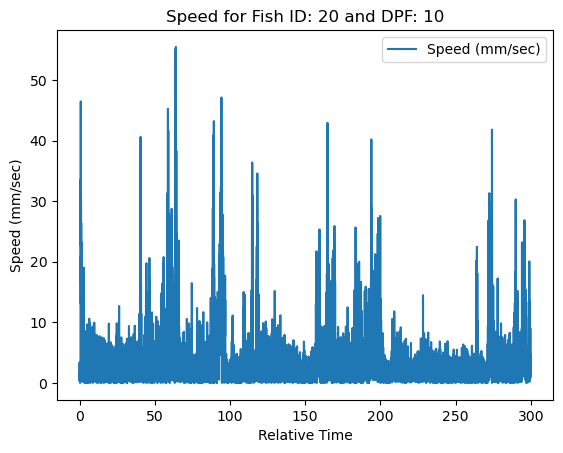

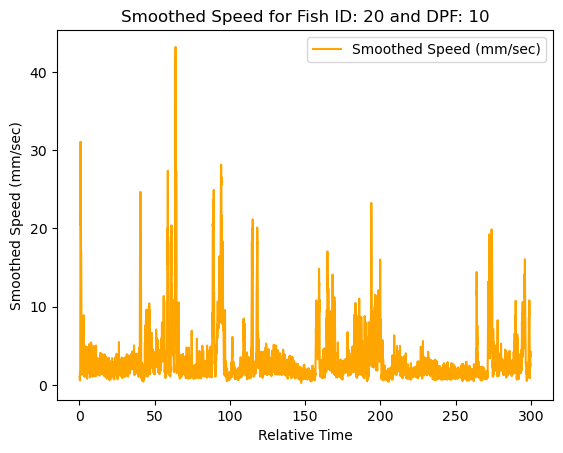

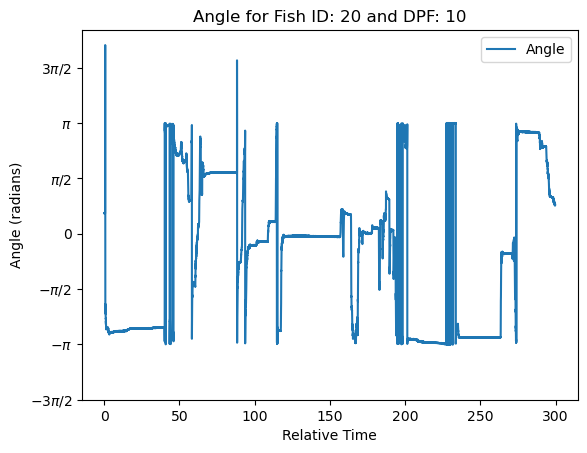

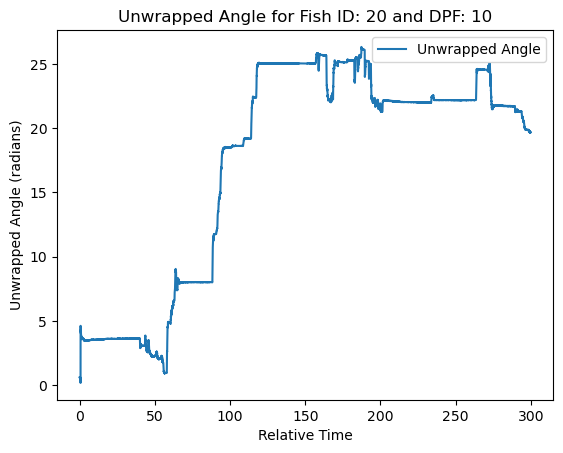

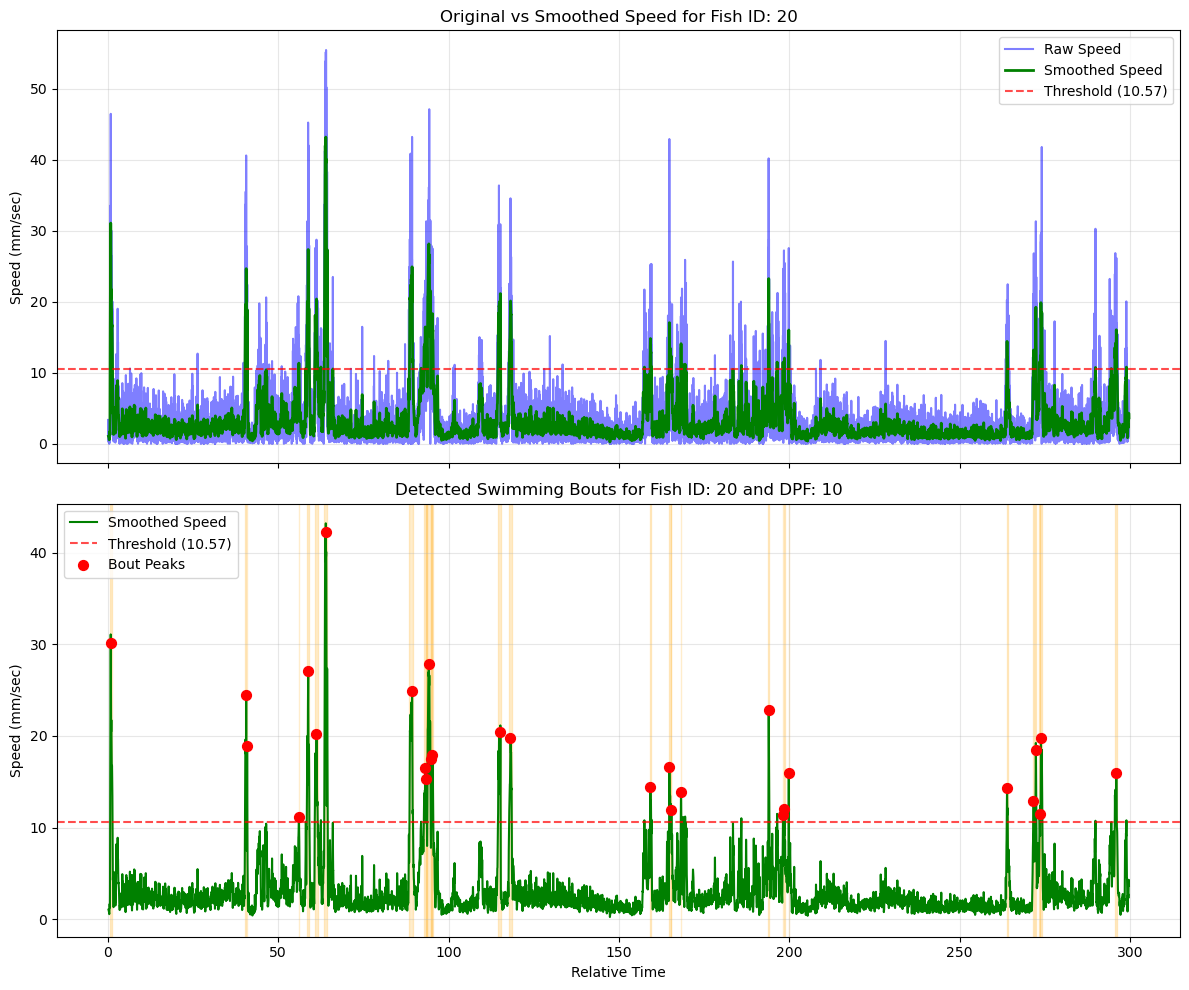

Histograms for Fish ID and DPF: 20, 10


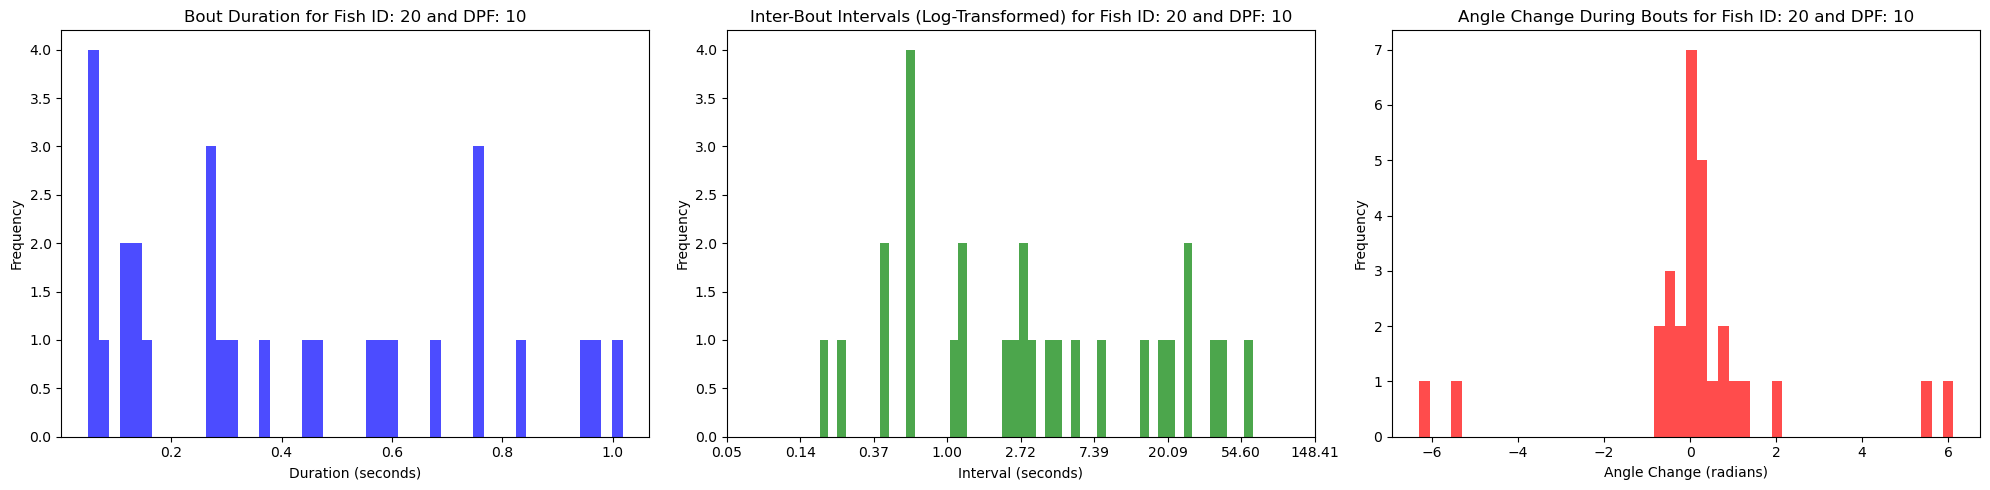

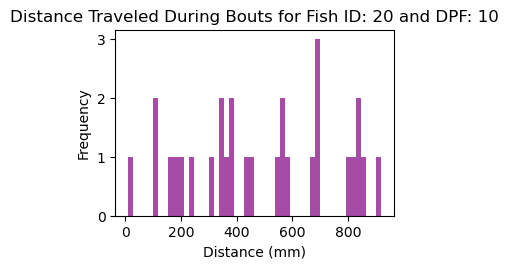

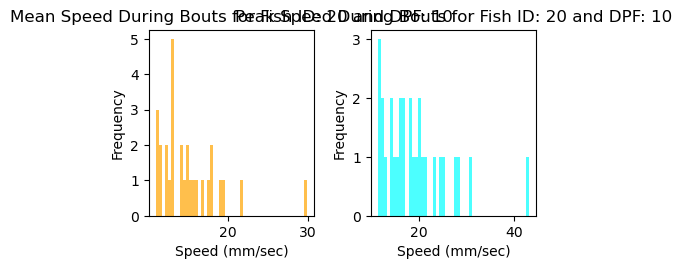

In [17]:
# Plot all metrics and print bout statistics for multiple fish_ids

#unique_fish_ids = derived_metrics_df_bright_all_dpf['fish_id'].unique()
#unique_dpfs = derived_metrics_df_bright_all_dpf['dpf'].unique()
unique_fish_ids =[20]
unique_dpfs = [7,10]
for fish_id in unique_fish_ids:
    for dpf in unique_dpfs:
        # Check if the dpf exists for the current fish_id
        if dpf in derived_metrics_df_bright_all_dpf[derived_metrics_df_bright_all_dpf['fish_id'] == fish_id]['dpf'].values:
            # Plot metrics for the current fish_id and dpf
            plot_all_metrics(derived_metrics_df_bright_all_dpf, bout_properties_df_bright_all_dpf, fish_id, dpf, bins=50)
        else :
            print(f"No data available for fish_id={fish_id} and dpf={dpf}. Skipping plotting.\n") 

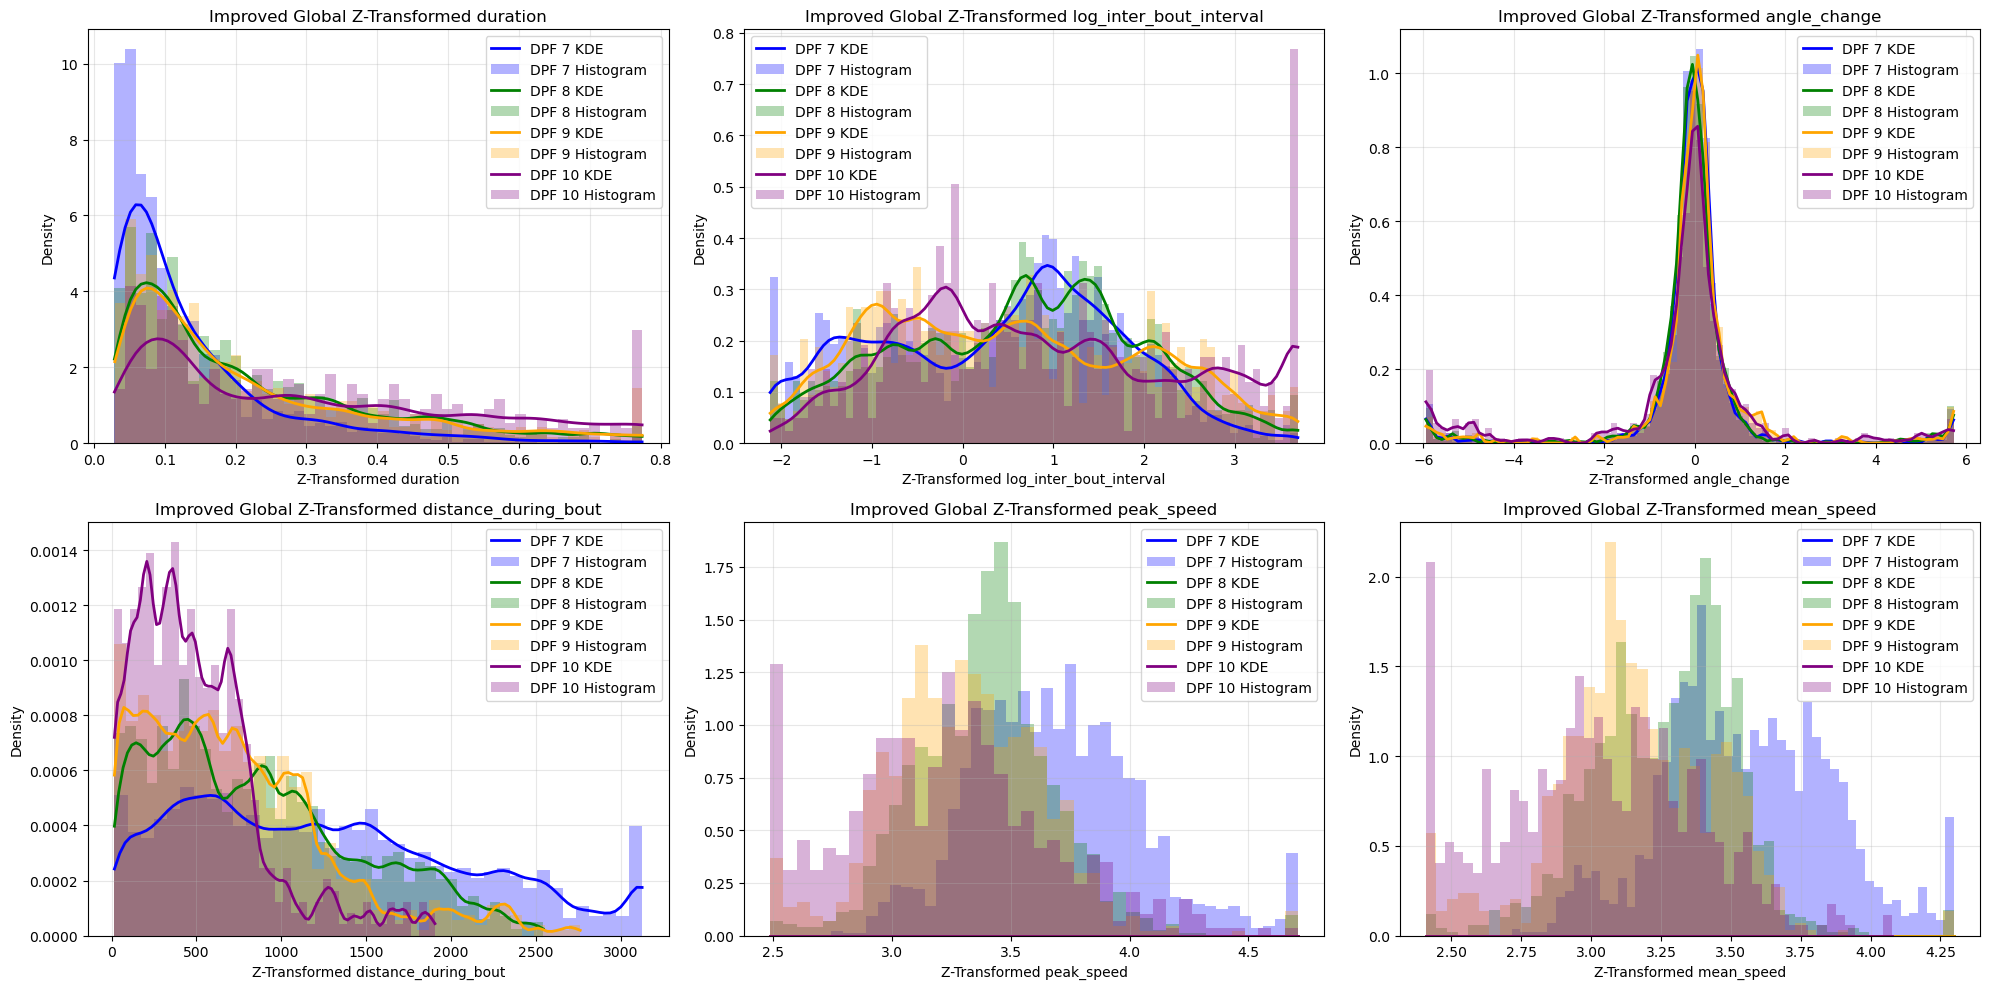

In [33]:
def global_z_transform(df, columns):
    """
    Apply a global z-transform to specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - columns (list): List of column names to normalize.

    Returns:
    - pd.DataFrame: DataFrame with globally z-transformed columns.
    """
    for column in columns:
        global_mean = df[column].mean()
        global_std = df[column].std()
        df[f'{column}_global'] = (df[column] - global_mean) / global_std
    return df

# Apply global z-transform to the bout properties DataFrame
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bout_properties_df_bright_all_dpf = global_z_transform(bout_properties_df_bright_all_dpf, columns_to_analyze)

def plot_global_z_transform_improved(kde_dicts, bout_properties_dfs, columns, dpf_values, colors, bins_dict):
    """
    Improved plotting function for globally z-transformed data with better KDE fitting and visualization.

    Parameters:
    - kde_dicts (dict): Dictionary of KDE objects for each DPF.
    - bout_properties_dfs (dict): Dictionary of DataFrames for each DPF.
    - columns (list): List of columns to plot.
    - dpf_values (list): List of DPF values.
    - colors (list): List of colors for each DPF.
    - bins_dict (dict): Dictionary of bins for each column.
    """
    plt.figure(figsize=(20, 10))
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(2, 3, i)
        
        for dpf, color in zip(dpf_values, colors):
            data = bout_properties_dfs[dpf][column].dropna().values  # Drop NaN values
            
            # Apply log transformation for skewed data
            if column in ['duration', 'peak_speed', 'mean_speed']:
                data = data[data >= 0]  # Remove negative values
                data = np.log1p(data)  # log(1 + x) to handle zeros
            
            if len(data) == 0:  # Skip if data is empty after cleaning
                continue
            
            kde = kde_dicts[dpf][column]
            
            # Generate x values for KDE
            x = np.linspace(data.min(), data.max(), 100)
            pdf = kde(x)
            
            # Plot KDE
            plt.plot(x, pdf, color=color, label=f'DPF {dpf} KDE', linewidth=2)
            
            # Plot histogram
            plt.hist(data, bins=bins_dict.get(column, 20), density=True, alpha=0.3, color=color, label=f'DPF {dpf} Histogram')
        
        plt.title(f'Improved Global Z-Transformed {column}')
        plt.xlabel(f'Z-Transformed {column}')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()



bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50
}
bandwidths_by_dpf = {
    7: {
        'duration': 0.2,
        'log_inter_bout_interval': 0.12,
        'angle_change': 0.06,
        'distance_during_bout': 0.09,
        'peak_speed': 0.01,
        'mean_speed': 0.02
    },
    8: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.08,
        'peak_speed': 0.01,
        'mean_speed': 0.01
    },
    9: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.09,
        'angle_change': 0.04,
        'distance_during_bout': 0.07,
        'peak_speed': 0.09,
        'mean_speed': 0.09
    },
    10: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.08,
        'peak_speed': 0.01,
        'mean_speed': 0.01
    }
}

dpf_values = [7, 8, 9, 10]
colors = ['blue', 'green', 'orange', 'purple']

# Calculate KDEs for each DPF using globally z-transformed columns
kde_dicts = {
    dpf: calculate_kdes(
        bout_properties_df_bright_all_dpf[bout_properties_df_bright_all_dpf['dpf'] == dpf],
        columns_to_analyze,
        bandwidths_by_dpf[dpf]
    )
    for dpf in dpf_values
}

# Group bout properties by DPF
bout_properties_dfs = {
    dpf: bout_properties_df_bright_all_dpf[bout_properties_df_bright_all_dpf['dpf'] == dpf]
    for dpf in dpf_values
}

# Plot global z-transformed data
plot_global_z_transform_improved(kde_dicts, bout_properties_dfs, columns_to_analyze, dpf_values, colors, bins_dict)


In [21]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
for column in columns_to_analyze:
    print(f"Summary statistics for {column}:")
    print(bout_properties_df_bright_all_dpf[column].describe())
    print(f"Skewness: {bout_properties_df_bright_all_dpf[column].skew()}")
    print(f"Kurtosis: {bout_properties_df_bright_all_dpf[column].kurtosis()}")

Summary statistics for duration:
count    4382.000000
mean        0.225422
std         0.246355
min         0.020808
25%         0.069953
50%         0.133146
75%         0.287806
max         2.926362
Name: duration, dtype: float64
Skewness: 2.7402259306468943
Kurtosis: 11.988171207272774
Summary statistics for log_inter_bout_interval:
count    4311.000000
mean        0.544251
std         1.404536
min        -2.702637
25%        -0.597026
50%         0.628987
75%         1.532565
max         4.958530
Name: log_inter_bout_interval, dtype: float64
Skewness: 0.089831762202677
Kurtosis: -0.6214776230231758
Summary statistics for angle_change:
count    4382.000000
mean       -0.067797
std         1.521428
min        -7.522809
25%        -0.289137
50%        -0.011384
75%         0.256318
max         6.577519
Name: angle_change, dtype: float64
Skewness: -0.4820370054321969
Kurtosis: 9.139668585212718
Summary statistics for distance_during_bout:
count    4382.000000
mean      957.203185
std  

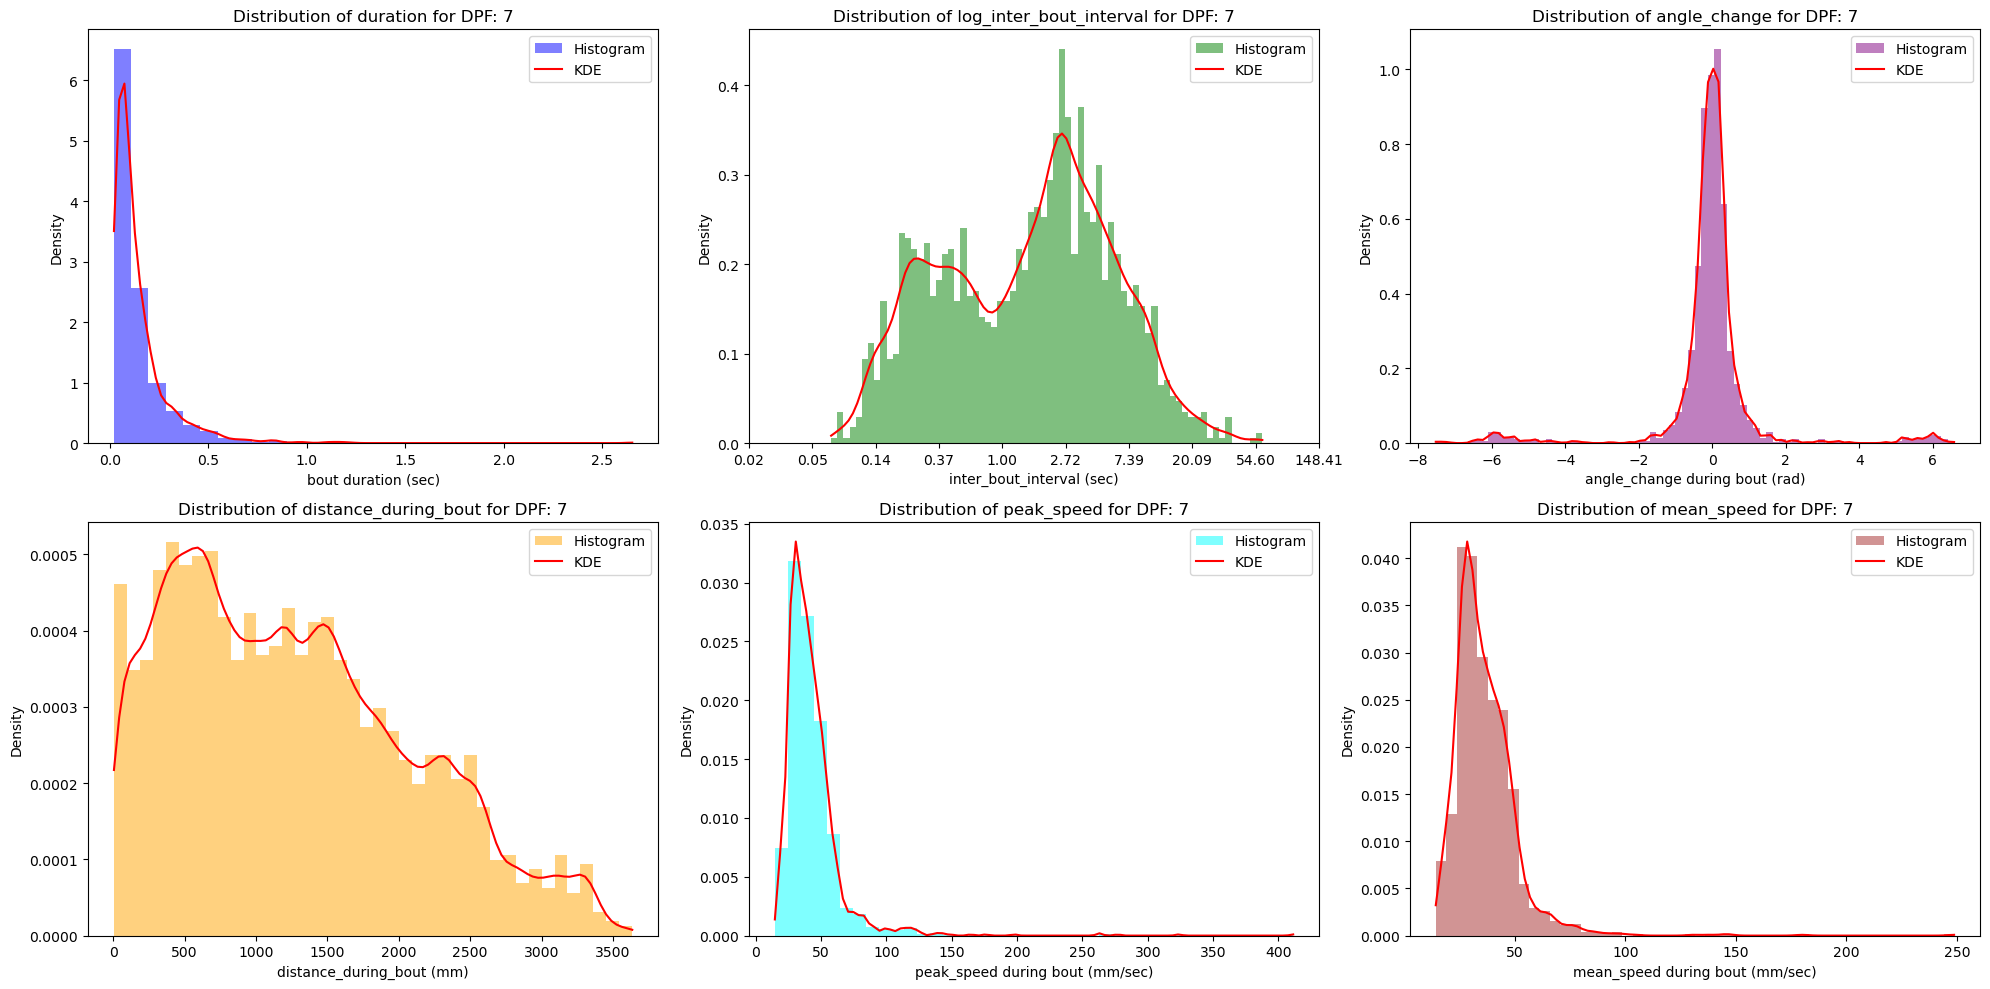

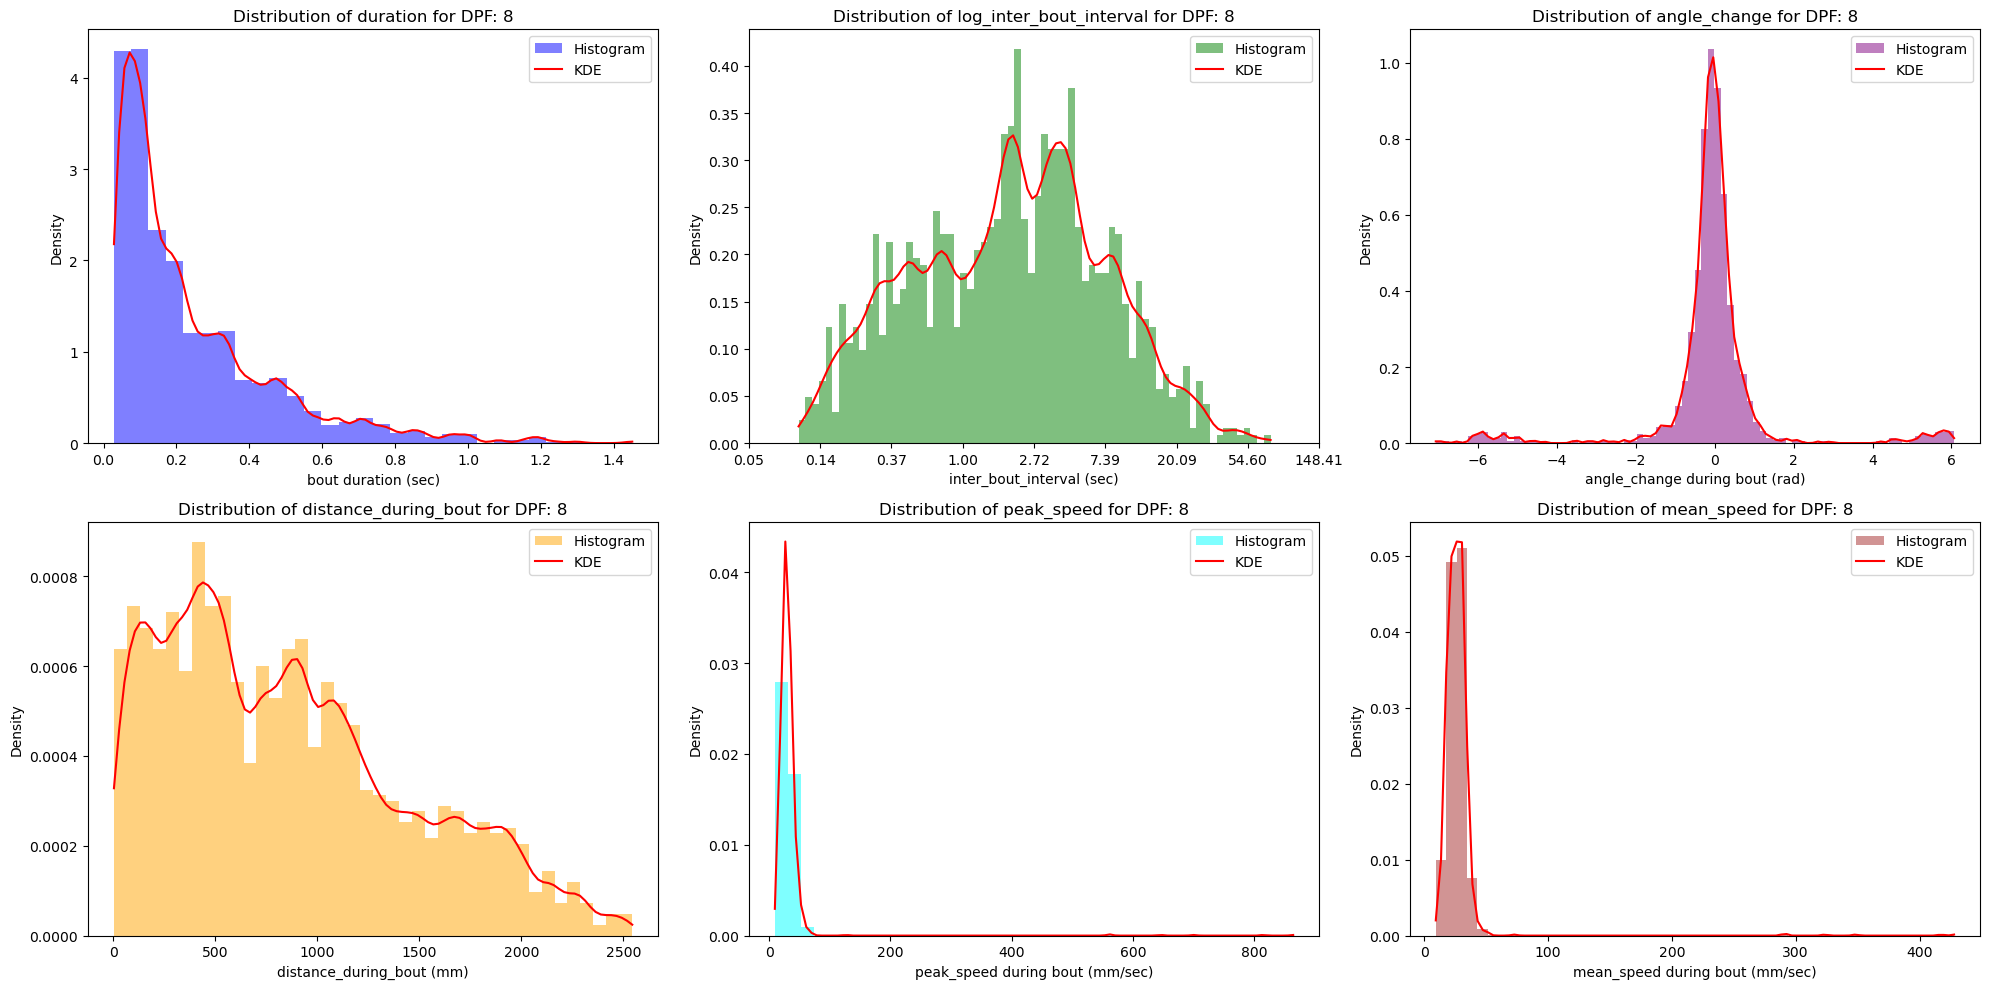

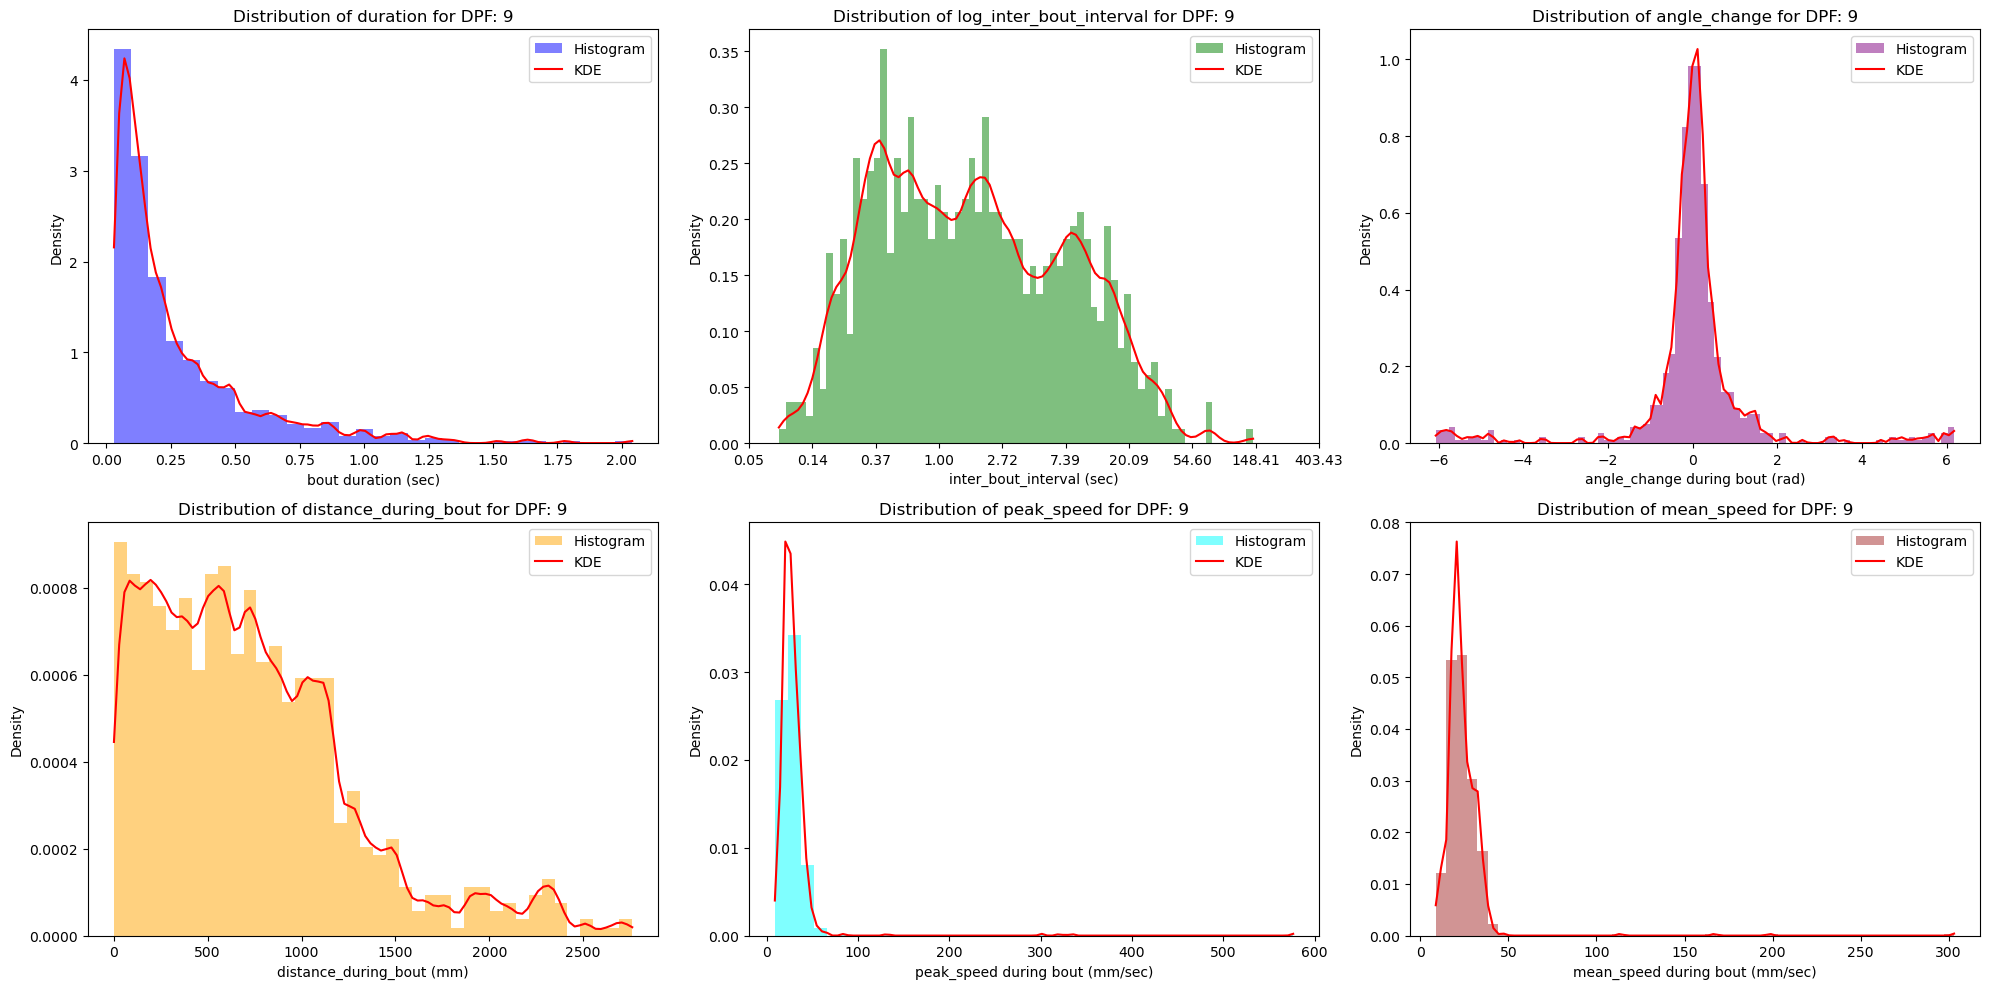

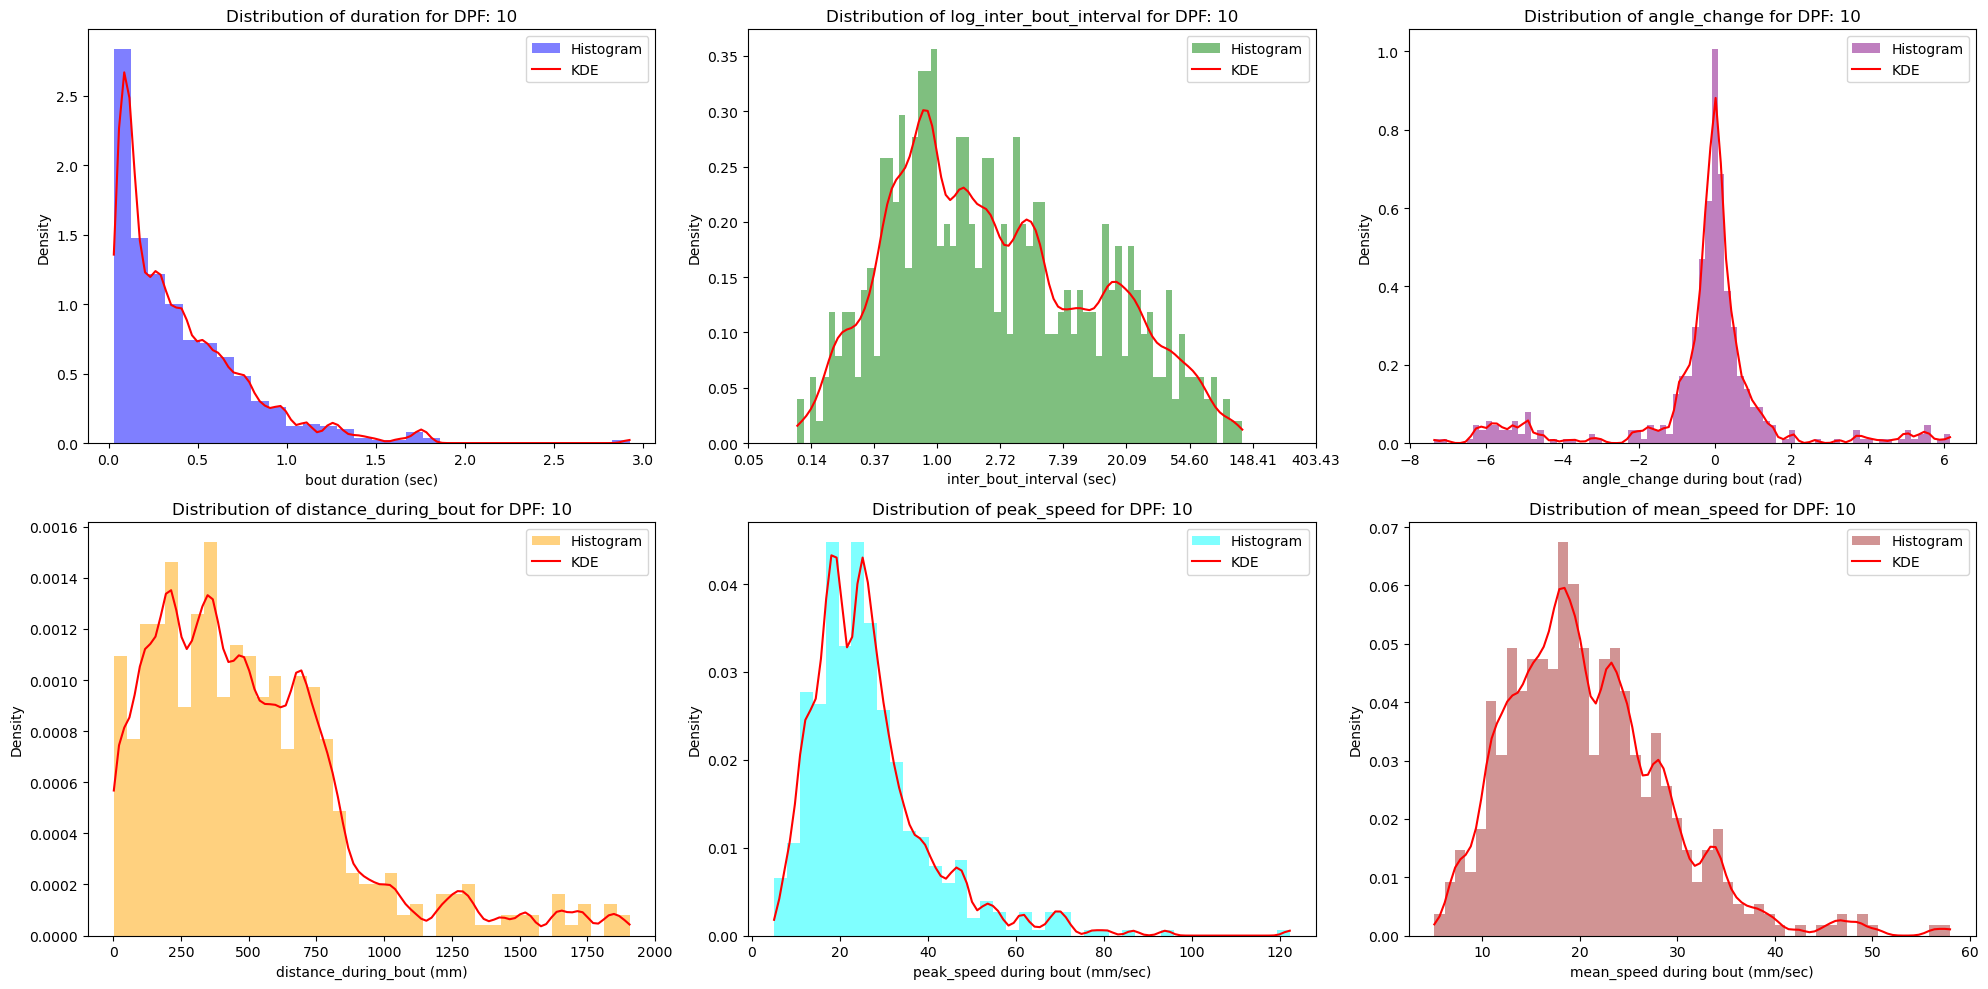

In [24]:
#Normal plotting

# Define bandwidths for each dpf
bandwidths_by_dpf = {
    7: {
        'duration': 0.2,
        'log_inter_bout_interval': 0.12,
        'angle_change': 0.06,
        'distance_during_bout': 0.09,
        'peak_speed': 0.1,
        'mean_speed': 0.2
    },
    8: {
        'duration': 0.09,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.08,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    },
    9: {
        'duration': 0.08,
        'log_inter_bout_interval': 0.09,
        'angle_change': 0.04,
        'distance_during_bout': 0.07,
        'peak_speed': 0.09,
        'mean_speed': 0.09
    },
    10: {
        'duration': 0.095,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.08,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    }
}

# Define columns to analyze
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']


# Loop through each dpf and apply the corresponding bandwidths
DPF = [7, 8, 9, 10]
for dpf in DPF:
    # Get the bandwidths for the current dpf
    bandwidths = bandwidths_by_dpf[dpf]
    
    # Filter the DataFrame for the current dpf
    bout_properties_df_bright_grouped_dpf = bout_properties_df_bright_all_dpf[bout_properties_df_bright_all_dpf['dpf'] == dpf]
    
    # Step 1: Calculate KDEs using the specific bandwidths for this dpf
    kde_dict_bright = calculate_kdes(bout_properties_df_bright_grouped_dpf, columns_to_analyze, bandwidths)
    
    # Step 2: Plot histograms and KDEs
    plot_kde_histograms(
        kde_dict_bright, 
        bout_properties_df_bright_grouped_dpf, 
        bins_dict={
            'duration': 30,
            'log_inter_bout_interval': 70,
            'angle_change': 80,
            'distance_during_bout': 40,
            'peak_speed': 40,
            'mean_speed': 50
        },
        dpf=dpf,
    )

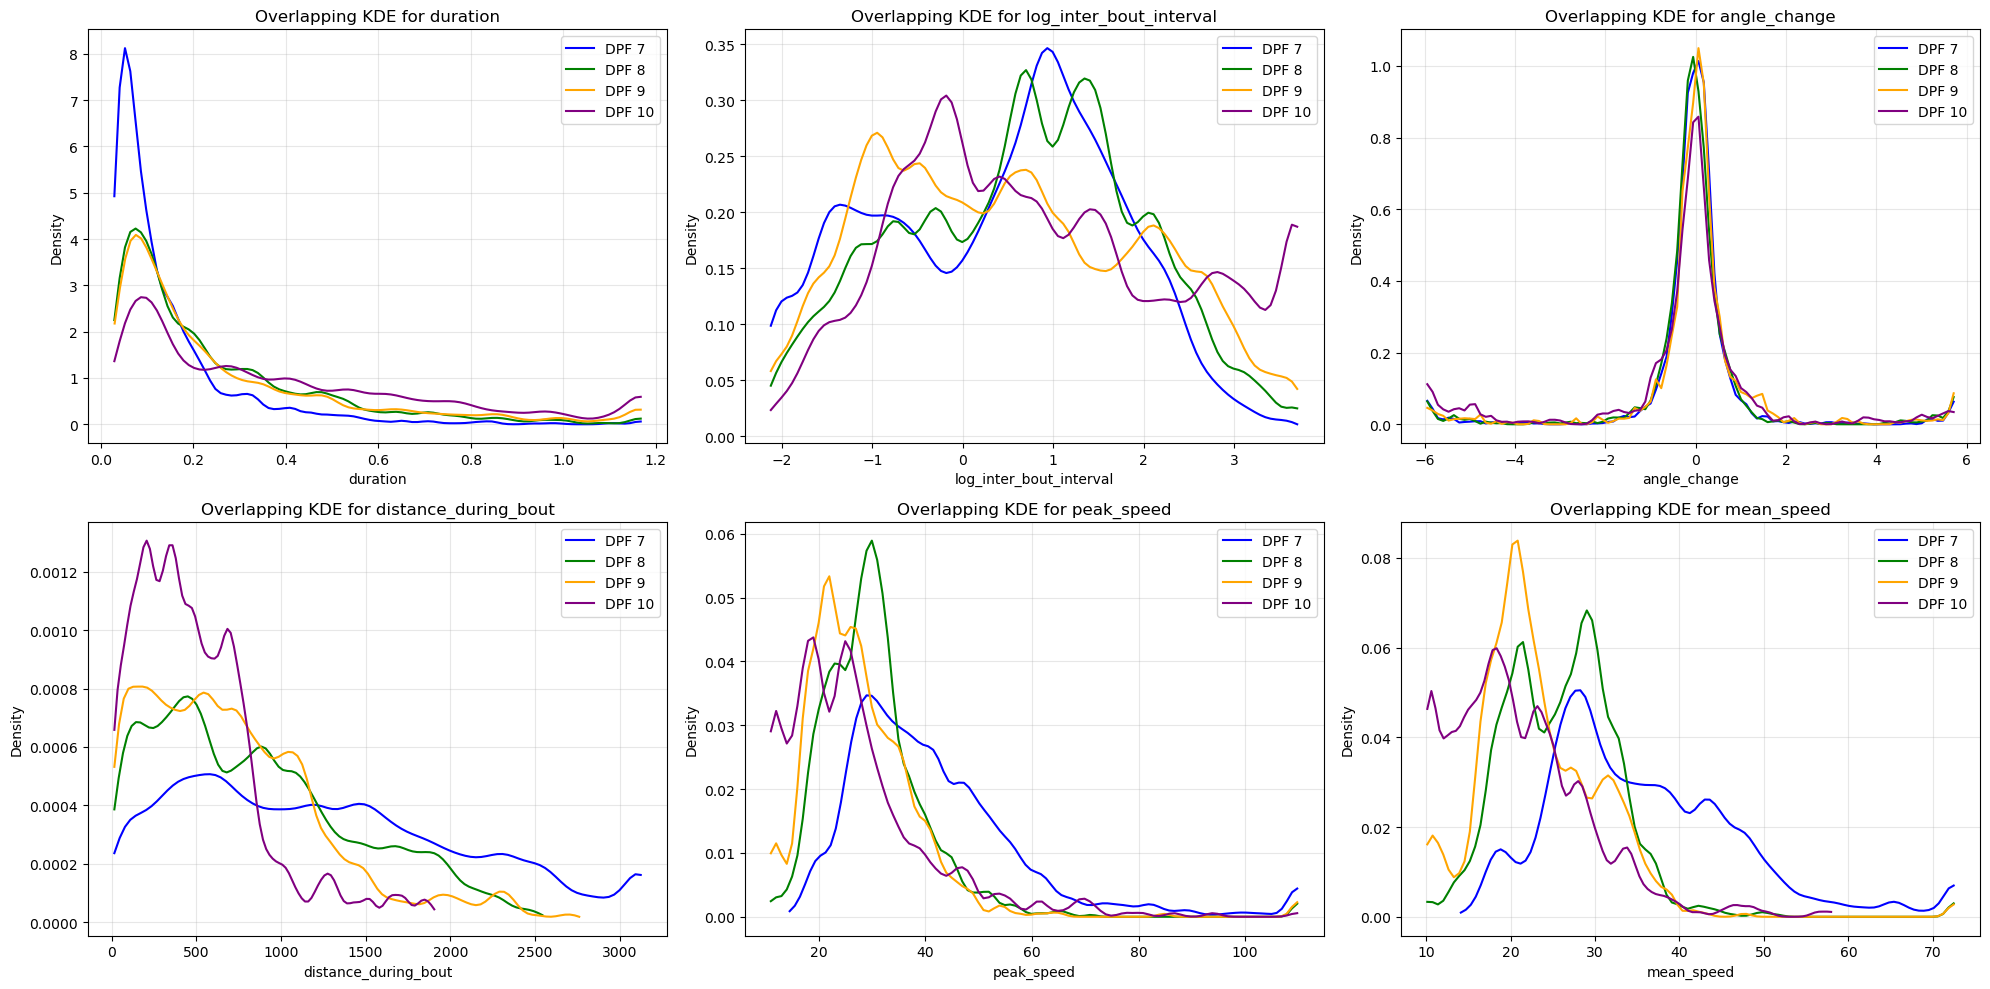

In [36]:
def plot_overlapping_kde(kde_dicts, bout_properties_dfs, columns, dpf_values, colors, bins_dict):
    """
    Plot overlapping KDEs for all DPFs for each column.

    Parameters:
    - kde_dicts (dict): Dictionary of KDE objects for each DPF.
    - bout_properties_dfs (dict): Dictionary of DataFrames for each DPF.
    - columns (list): List of columns to plot.
    - dpf_values (list): List of DPF values.
    - colors (list): List of colors for each DPF.
    - bins_dict (dict): Dictionary of bins for each column.
    """
    plt.figure(figsize=(20, 10))
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(2, 3, i)
        
        for dpf, color in zip(dpf_values, colors):
            data = bout_properties_dfs[dpf][column].dropna().values
            kde = kde_dicts[dpf][column]
            
            # Generate x values for KDE
            x = np.linspace(data.min(), data.max(), 100)
            pdf = kde(x)
            
            # Plot KDE
            plt.plot(x, pdf, color=color, label=f'DPF {dpf}')
            # Apply zoom for duration column
        #if column == 'duration':
         #   plt.xlim(0, 1)  # Zoom into values between 0 and 1
        
            # Plot histogram
            #plt.hist(data, bins=bins_dict.get(column, 20), density=True, alpha=0.3, color=color, label=f'DPF {dpf} Histogram')
        
        plt.title(f'Overlapping KDE for {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Define parameters
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 20,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50
}

bandwidths_by_dpf = {
    7: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.12,
        'angle_change': 0.06,
        'distance_during_bout': 0.1,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    },
    8: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.1,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    },
    9: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.09,
        'angle_change': 0.04,
        'distance_during_bout': 0.1,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    },
    10: {
        'duration': 0.1,
        'log_inter_bout_interval': 0.1,
        'angle_change': 0.05,
        'distance_during_bout': 0.1,
        'peak_speed': 0.1,
        'mean_speed': 0.1
    }
}


dpf_values = [7, 8, 9, 10]
colors = ['blue', 'green', 'orange', 'purple']

def clip_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply clipping to duration, peak_speed, and mean_speed
columns_to_clip = ['duration', 'peak_speed', 'mean_speed']
for column in columns_to_analyze:
    bout_properties_df_bright_all_dpf = clip_outliers(bout_properties_df_bright_all_dpf, column)

# Calculate KDEs for each DPF
kde_dicts = {
    dpf: calculate_kdes(
        bout_properties_df_bright_all_dpf[bout_properties_df_bright_all_dpf['dpf'] == dpf],
        columns_to_analyze,
        bandwidths_by_dpf[dpf]
    )
    for dpf in dpf_values
}

# Group bout properties by DPF
bout_properties_dfs = {
    dpf: bout_properties_df_bright_all_dpf[bout_properties_df_bright_all_dpf['dpf'] == dpf]
    for dpf in dpf_values
}

# Plot overlapping KDEs
plot_overlapping_kde(kde_dicts, bout_properties_dfs, columns_to_analyze, dpf_values, colors, bins_dict)

Estimated bouts_per_path: 29


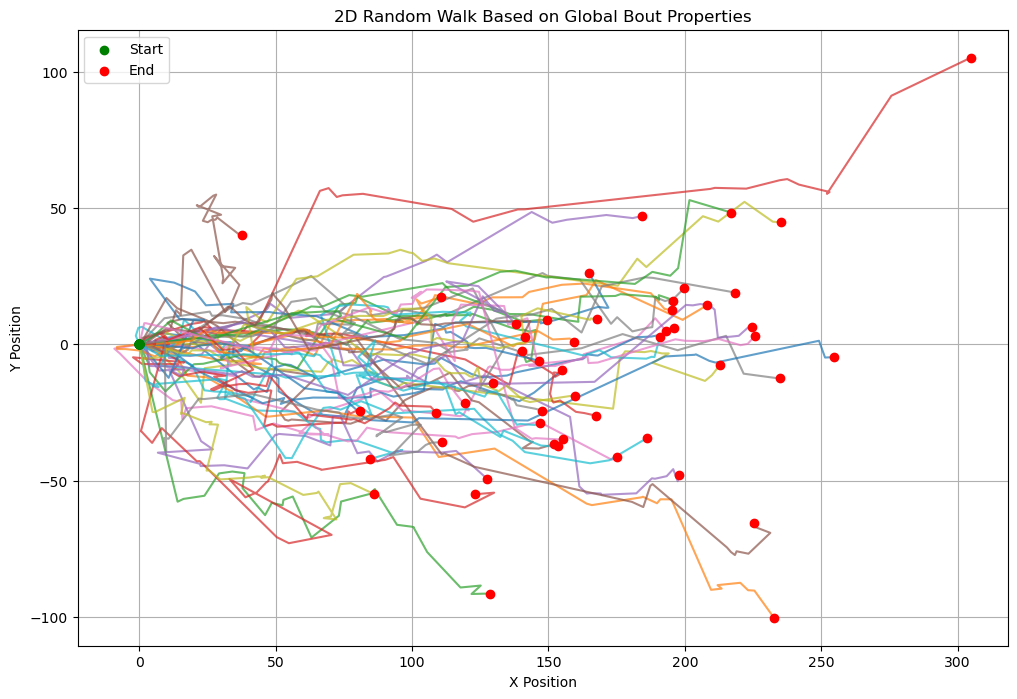

In [273]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_bright,bout_properties_df_bright, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [274]:
dark_df = pd.read_csv(r'.\processed_data\dark_data_20250409.csv')
derived_metrics_df_dark_og = calculate_derived_metrics(data=dark_df,
    label='dark', output_folder=r'.\processed_data') #change the label to dark

filtered_df_dark = filter_extreme_angle_changes(derived_metrics_df_dark_og, fish_id=None, window_ms=200)

save_csv(filtered_df_bright, label='filtered_dark', output_folder=r'.\processed_data')
derived_metrics_df_dark = filtered_df_dark.copy()

bout_properties_df_dark = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_dark,
    label='dark', output_folder=r'.\processed_data', #change the label to dark
    smoothing_method='gaussian', sigma=2)

Derived metrics saved to .\processed_data\derived_metrics_dark_20250527.csv
Processing fish_id: 2
Fish ID: 2, Index: 6, Relative Time: 0.0825382330000366
Angle before adjustment: -0.7645861486826948, Angle Diff: 1.6686756467618757
Angle after adjustment: 2.377006504907098
Fish ID: 2, Index: 7, Relative Time: 0.09513410200003136
Angle before adjustment: -0.9733207191794649, Angle Diff: 1.5748047013822797
Angle after adjustment: 2.168271934410328
Appending processed data for Fish ID: 2, Shape: (18004, 37)
Processing fish_id: 3
Appending processed data for Fish ID: 3, Shape: (18004, 37)
Processing fish_id: 4
Fish ID: 4, Index: 3243, Relative Time: 54.074627808
Angle before adjustment: 1.1406135580088637, Angle Diff: 1.73343936737628
Angle after adjustment: 4.282206211598657
Fish ID: 4, Index: 3244, Relative Time: 54.08321961199999
Angle before adjustment: 1.136724191286276, Angle Diff: 1.8728303306144871
Angle after adjustment: 4.278316844876069
Fish ID: 4, Index: 3245, Relative Time: 54.

Summary of Threshold Filtering Dark:
Fish ID: 2, Passed: 18002, Failed: 2
Fish ID: 3, Passed: 18004, Failed: 0
Fish ID: 4, Passed: 17991, Failed: 12
Fish ID: 6, Passed: 18005, Failed: 0
Fish ID: 7, Passed: 17982, Failed: 24
Fish ID: 8, Passed: 17995, Failed: 10
Fish ID: 9, Passed: 17999, Failed: 7
Fish ID: 10, Passed: 17999, Failed: 7
Fish ID: 11, Passed: 18002, Failed: 4
Fish ID: 12, Passed: 18003, Failed: 0
Fish ID: 13, Passed: 18006, Failed: 0
Fish ID: 14, Passed: 18004, Failed: 0
Fish ID: 15, Passed: 17982, Failed: 17
Fish ID: 16, Passed: 17979, Failed: 28
Fish ID: 17, Passed: 17995, Failed: 9
Fish ID: 18, Passed: 18001, Failed: 4
Fish ID: 19, Passed: 18005, Failed: 1
Fish ID: 20, Passed: 18002, Failed: 3
Fish ID: 21, Passed: 17969, Failed: 36
Fish ID: 22, Passed: 17999, Failed: 6
Fish ID: 23, Passed: 17952, Failed: 53
Fish ID: 24, Passed: 18003, Failed: 2

Plotting metrics and printing statistics for Fish ID: 2
Total Number of bouts detected: 3
Average bout duration: 0.16 time units
Average bout peak speed: 13.13 mm/sec
Average bout mean speed: 6.21 mm/sec
Average inter-bout interval: 94.05 time units
Average angle change: -0.57 radians
Average distance traveled: 121.29 mm

Top 5 bouts by peak speed:
   bout_id  start_time  duration  peak_speed
0        1    0.028577  0.404272   33.632253
1        2  151.326491  0.040561    2.992984
2        3  188.129628  0.036880    2.774885


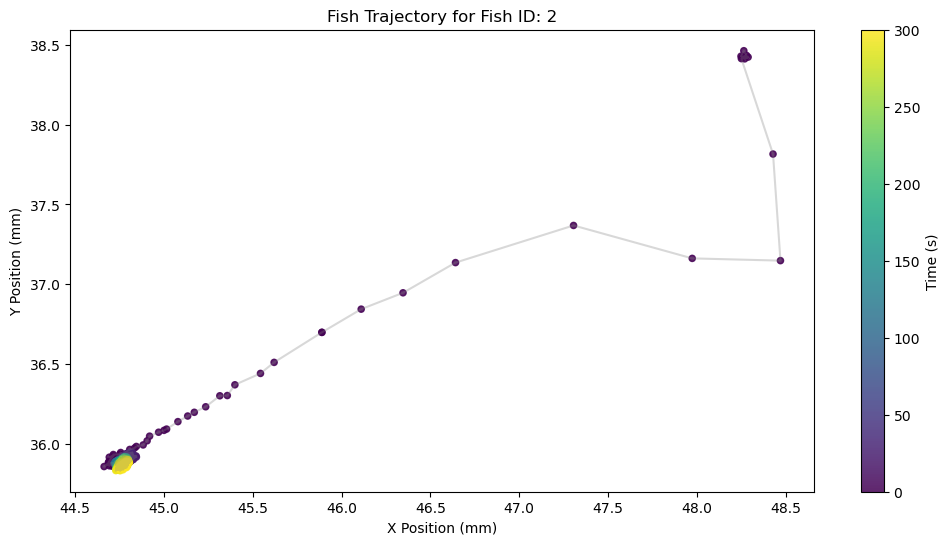

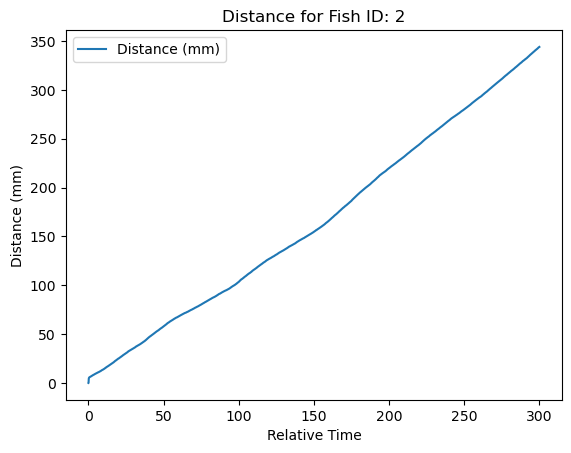

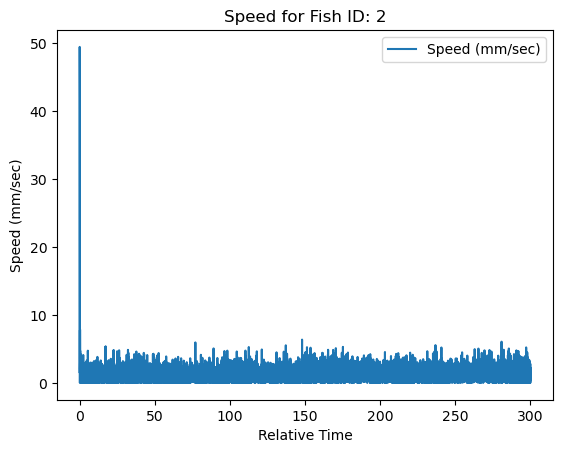

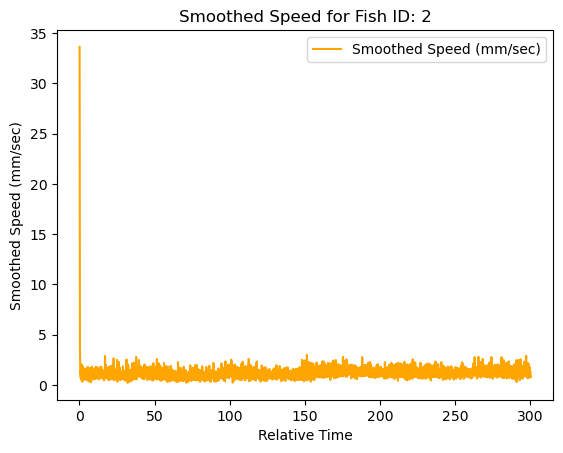

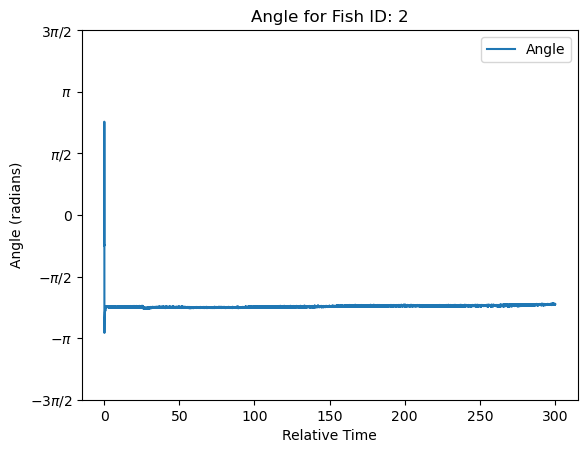

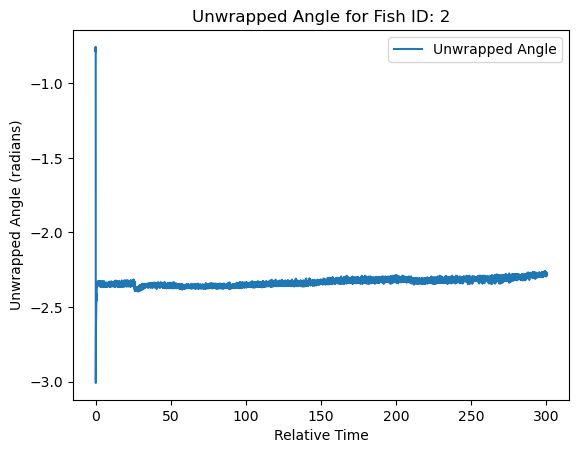

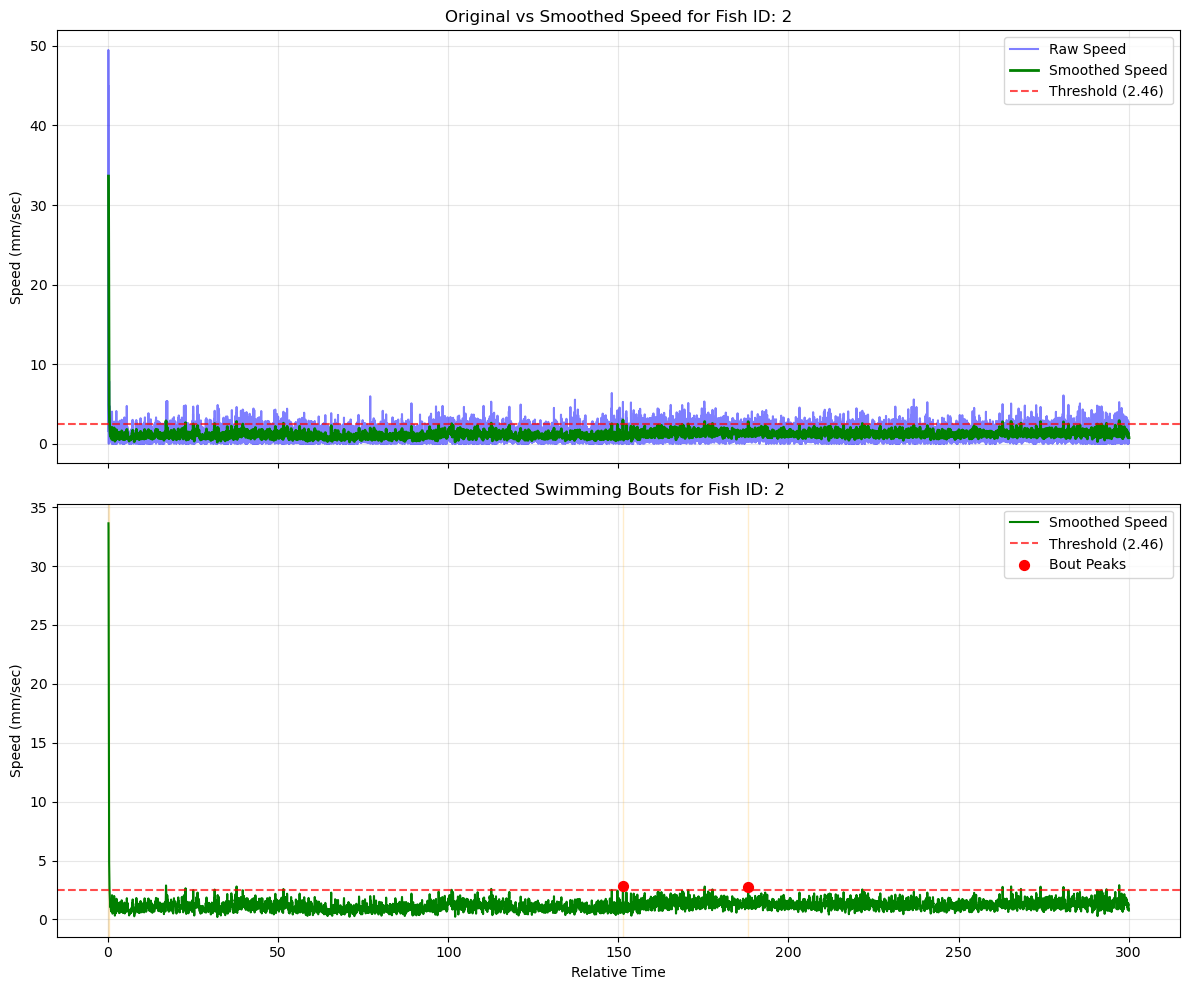

Histograms for Fish ID: 2


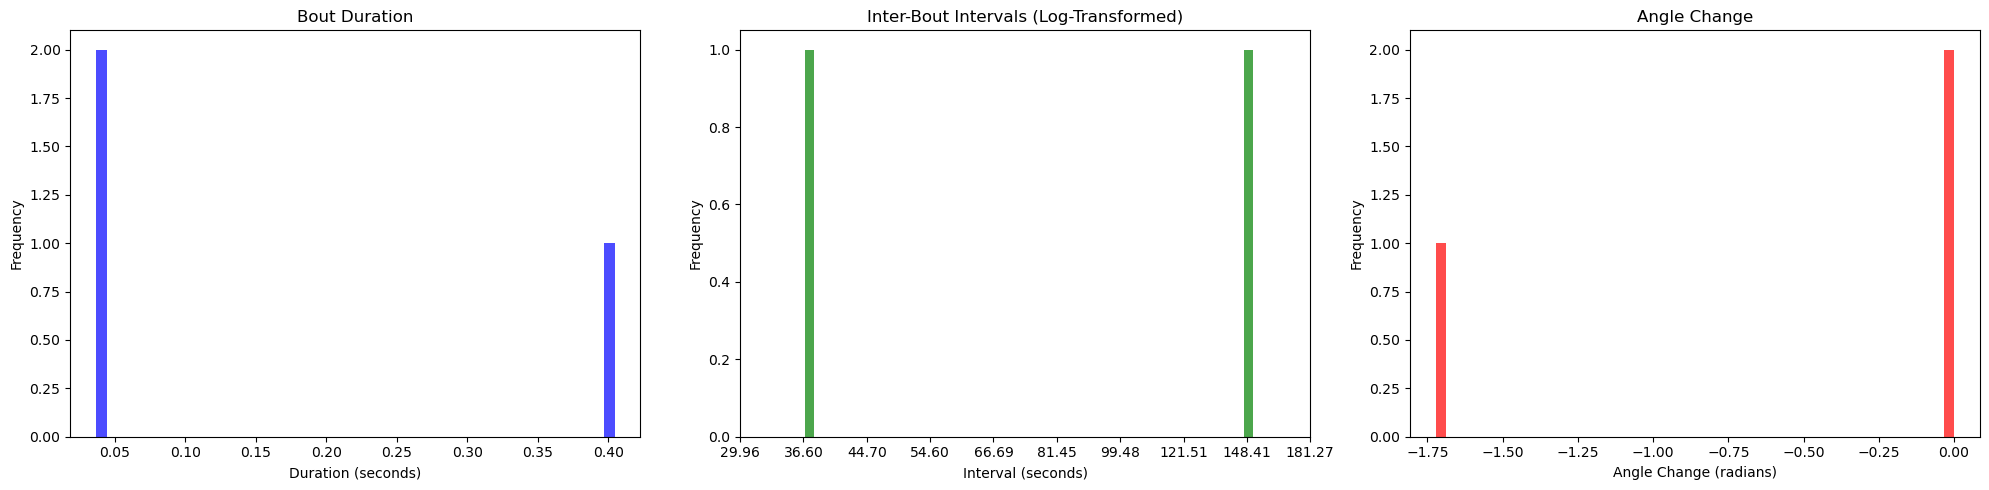

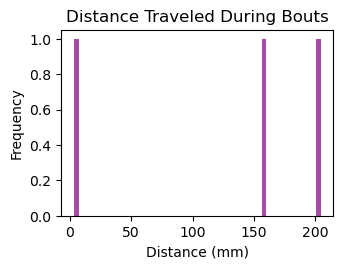

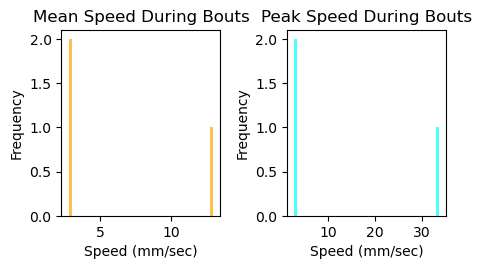

In [275]:
# Example: Plot all metrics and print bout statistics for multiple fish_ids
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_dark, bout_properties_df_dark, fish_id, bins=50)

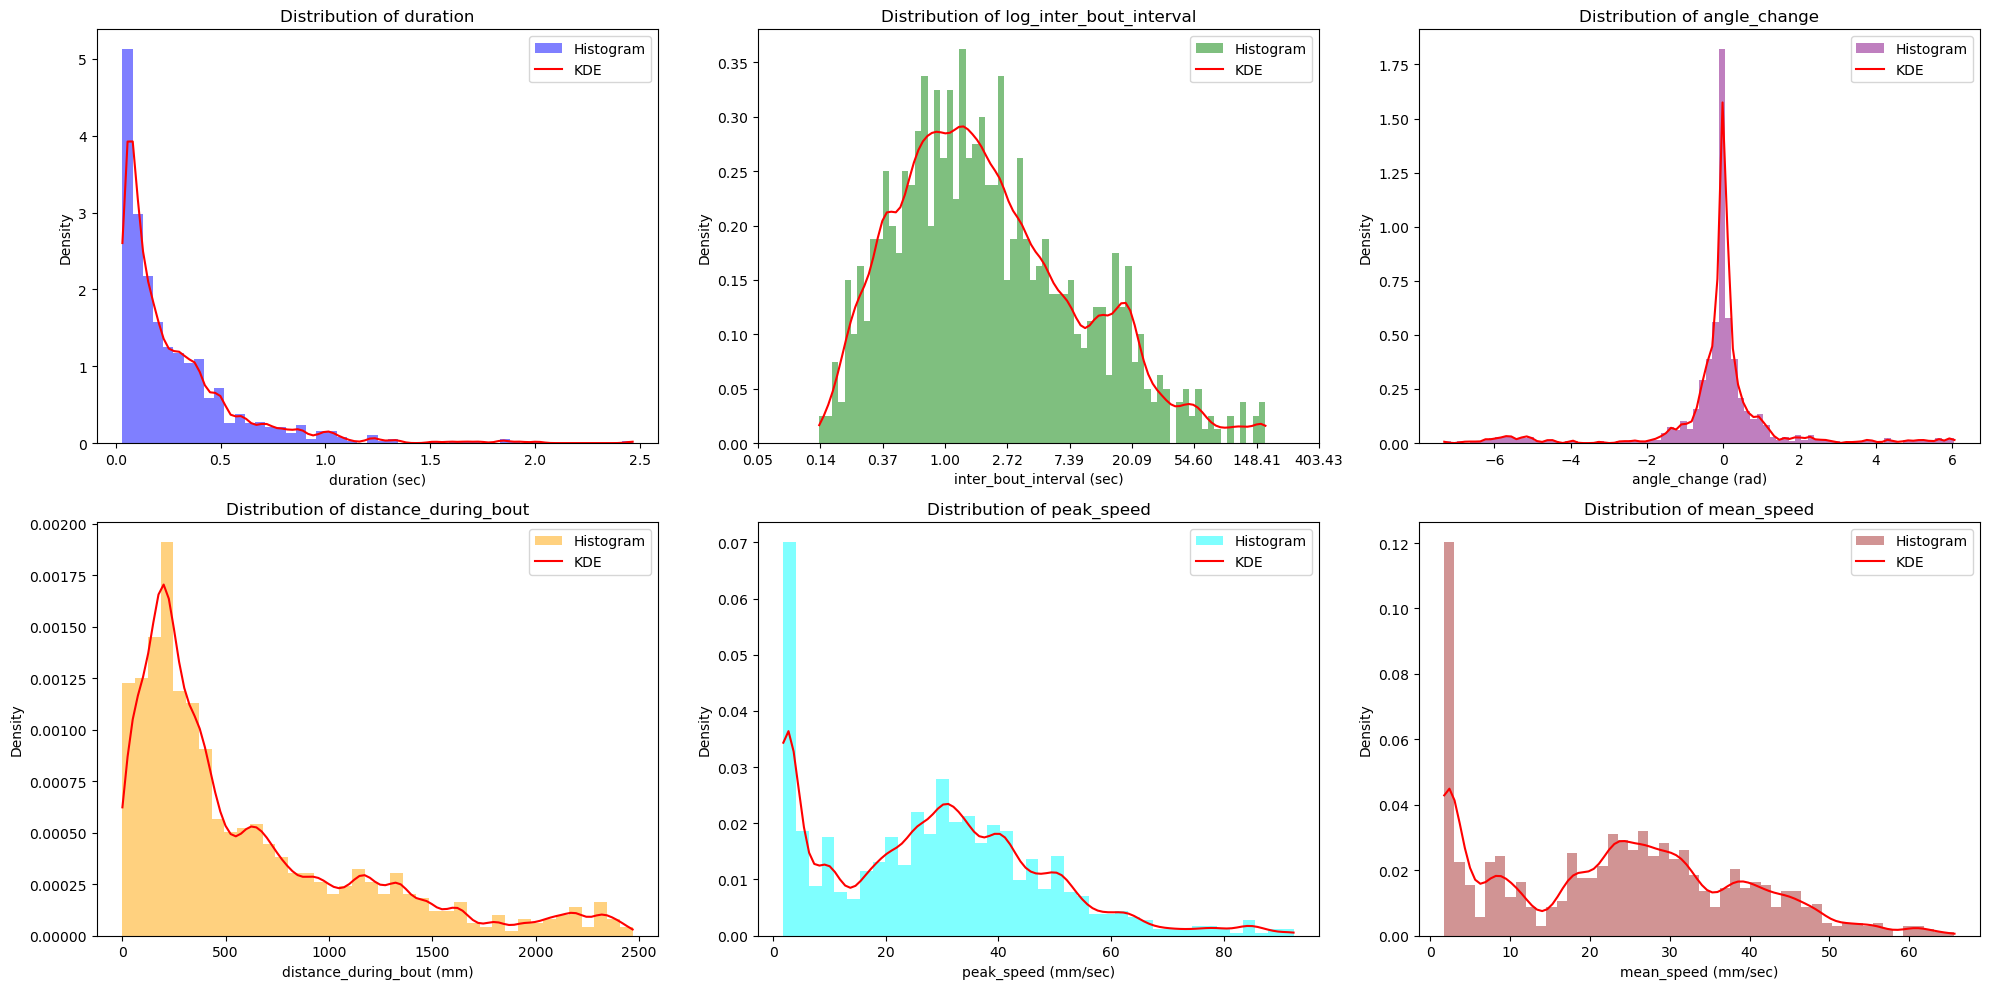

In [276]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }

# Step 1: Calculate KDEs
kde_dict_dark = calculate_kdes(bout_properties_df_dark, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_dark, bout_properties_df_dark, bins_dict)

Estimated bouts_per_path: 37


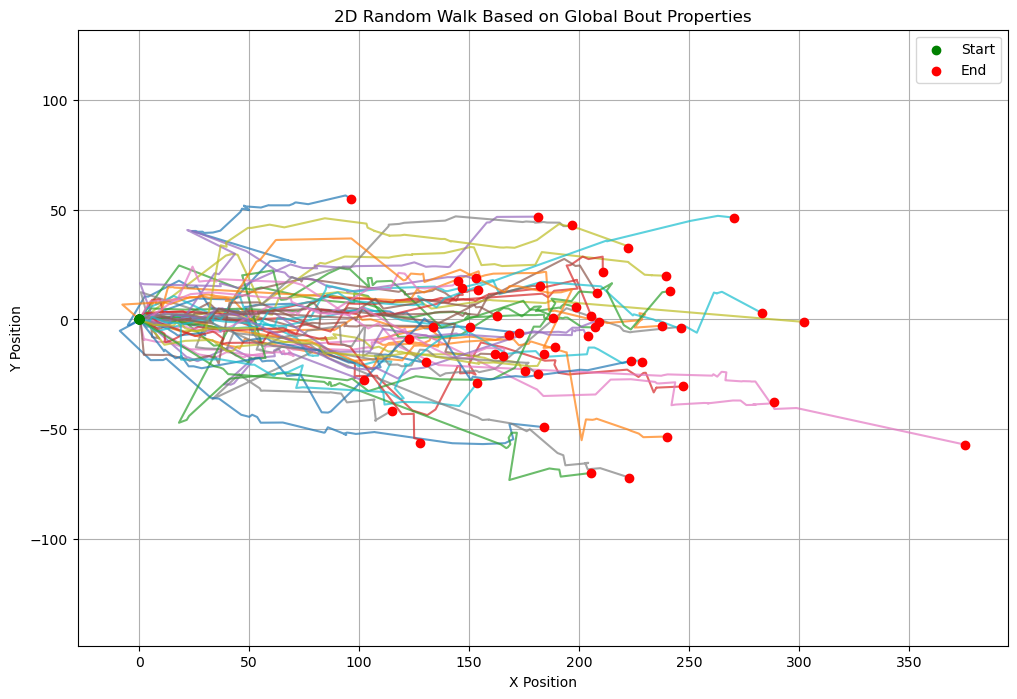

In [277]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_dark,bout_properties_df_dark, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [278]:
phototaxis_df = pd.read_csv(r'.\processed_data\phototaxis_data_20250409.csv')
#the column 'phototaxis_polarity' indicates whether 
# the dark region is to the left (-1) or to the right (+1) of the fish
phototaxis_df_left = phototaxis_df[phototaxis_df['phototaxis_polarity'] == 1]
phototaxis_df_right = phototaxis_df[phototaxis_df['phototaxis_polarity'] == -1]

derived_metrics_df_phototaxis_og = calculate_derived_metrics(data=phototaxis_df,
    label='phototaxis', output_folder=r'.\processed_data')
#filtered_df_phototaxis = filter_extreme_angle_changes(derived_metrics_df_phototaxis, fish_id=None, window_ms=200)
#save_csv(filtered_df_phototaxis, label='filtered_phototaxis', output_folder=r'.\processed_data')
#derived_metrics_df_phototaxis = filtered_df_phototaxis.copy()


#Dark left
derived_metrics_df_phototaxis_left_og = calculate_derived_metrics(data=phototaxis_df_left,
    label='phototaxis_left', output_folder=r'.\processed_data')

filtered_df_phototaxis_left = filter_extreme_angle_changes(derived_metrics_df_phototaxis_left_og, fish_id=None, window_ms=200)
save_csv(filtered_df_phototaxis_left, label='filtered_phototaxis_left', output_folder=r'.\processed_data')
derived_metrics_df_phototaxis_left = filtered_df_phototaxis_left.copy()

bout_properties_df_phototaxis_left = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_phototaxis_left,
    label='phototaxis_left', output_folder=r'.\processed_data',
    smoothing_method='gaussian', sigma=2)

#Dark right
derived_metrics_df_phototaxis_right_og = calculate_derived_metrics(data=phototaxis_df_right,
    label='phototaxis_right', output_folder=r'.\processed_data')

filtered_df_phototaxis_right = filter_extreme_angle_changes(derived_metrics_df_phototaxis_right_og, fish_id=None, window_ms=200)
save_csv(filtered_df_phototaxis_right, label='filtered_phototaxis_right', output_folder=r'.\processed_data')    
derived_metrics_df_phototaxis_right = filtered_df_phototaxis_right.copy()

bout_properties_df_phototaxis_right = detect_and_save_bouts(derived_metrics_df=derived_metrics_df_phototaxis_right,
    label='phototaxis_right', output_folder=r'.\processed_data',
    smoothing_method='gaussian', sigma=2)

Derived metrics saved to .\processed_data\derived_metrics_phototaxis_20250527.csv
Derived metrics saved to .\processed_data\derived_metrics_phototaxis_left_20250527.csv
Processing fish_id: 2
Fish ID: 2, Index: 11198, Relative Time: 186.6312130350002
Angle before adjustment: -1.9730672433665903, Angle Diff: -2.5650638680765643
Angle after adjustment: 1.1685254102232028
Fish ID: 2, Index: 11199, Relative Time: 186.64784761600004
Angle before adjustment: -2.398160623870691, Angle Diff: -3.0596992024743175
Angle after adjustment: 0.7434320297191022
Fish ID: 2, Index: 14215, Relative Time: 236.915418068
Angle before adjustment: -0.9963501301167641, Angle Diff: -1.598034553254355
Angle after adjustment: 2.145242523473029
Fish ID: 2, Index: 30204, Relative Time: 503.4354584150001
Angle before adjustment: -0.9790965436035113, Angle Diff: -1.7345953200411506
Angle after adjustment: 2.162496109986282
Fish ID: 2, Index: 30205, Relative Time: 503.4524228150003
Angle before adjustment: -0.979096543

Summary of Threshold Filtering Phototaxis_LEFT:
Fish ID: 2, Passed: 71955, Failed: 46
Fish ID: 3, Passed: 71955, Failed: 42
Fish ID: 4, Passed: 71919, Failed: 83
Fish ID: 6, Passed: 71894, Failed: 108
Fish ID: 7, Passed: 71836, Failed: 170
Fish ID: 8, Passed: 35992, Failed: 11
Fish ID: 9, Passed: 35987, Failed: 17
Fish ID: 10, Passed: 35977, Failed: 28
Fish ID: 11, Passed: 35980, Failed: 25
Fish ID: 12, Passed: 35995, Failed: 11
Fish ID: 13, Passed: 35993, Failed: 12
Fish ID: 14, Passed: 71979, Failed: 8
Fish ID: 15, Passed: 71910, Failed: 86
Fish ID: 16, Passed: 71985, Failed: 16
Fish ID: 17, Passed: 71973, Failed: 31
Fish ID: 18, Passed: 71862, Failed: 143
Fish ID: 19, Passed: 71987, Failed: 18
Fish ID: 20, Passed: 71921, Failed: 81
Fish ID: 21, Passed: 71902, Failed: 99
Fish ID: 22, Passed: 71991, Failed: 11
Fish ID: 23, Passed: 71756, Failed: 247
Fish ID: 24, Passed: 71896, Failed: 108

Plotting metrics and printing statistics for Fish ID: 2
Total Number of bouts detected: 149
Average bout duration: 0.29 time units
Average bout peak speed: 15.52 mm/sec
Average bout mean speed: 11.54 mm/sec
Average inter-bout interval: 8.18 time units
Average angle change: -0.19 radians
Average distance traveled: 1383.28 mm

Top 5 bouts by peak speed:
     bout_id   start_time  duration  peak_speed
75        81   727.771772  0.282712   70.514679
113      120   935.754909  0.571093   48.310966
80        86   786.075546  0.497096   46.889319
101      108   895.088953  0.375862   45.523552
135      142  1067.990875  0.433669   43.218654


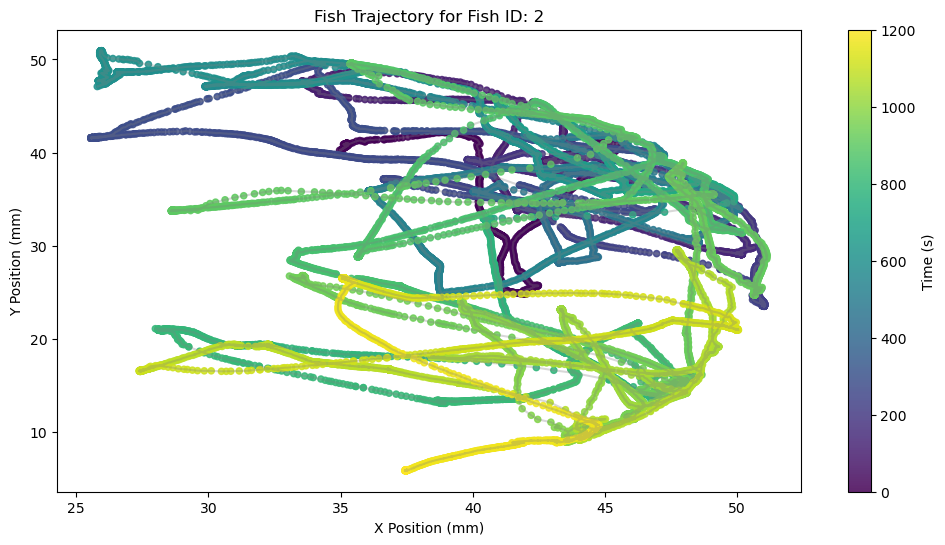

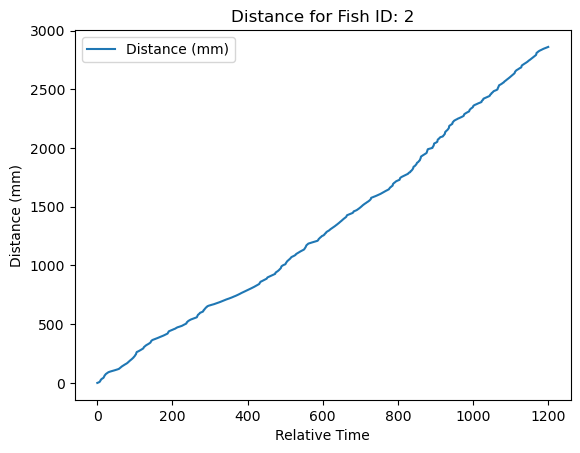

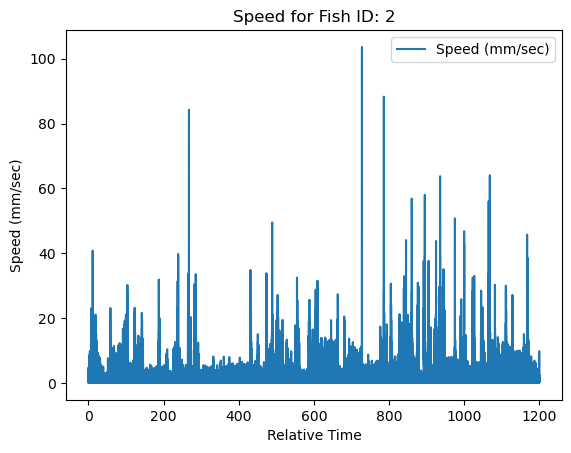

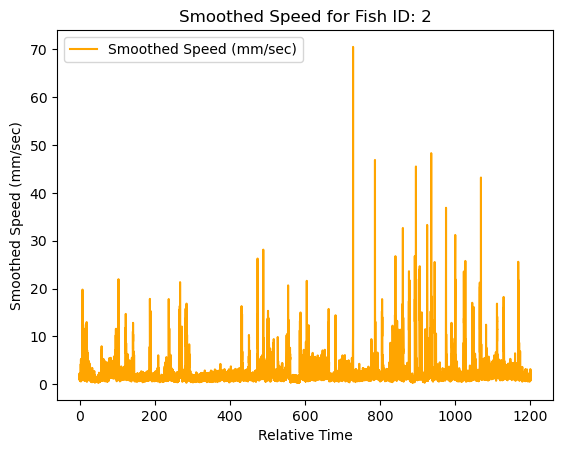

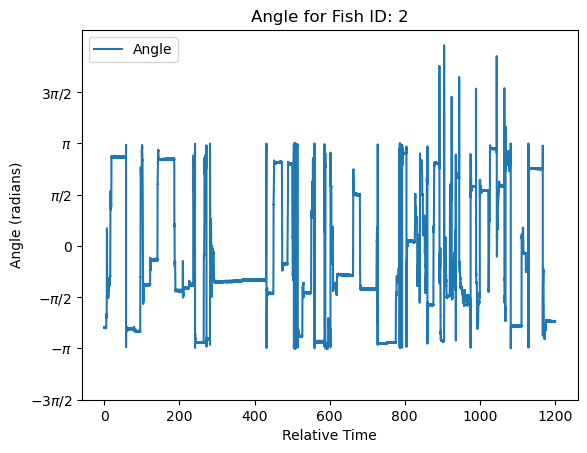

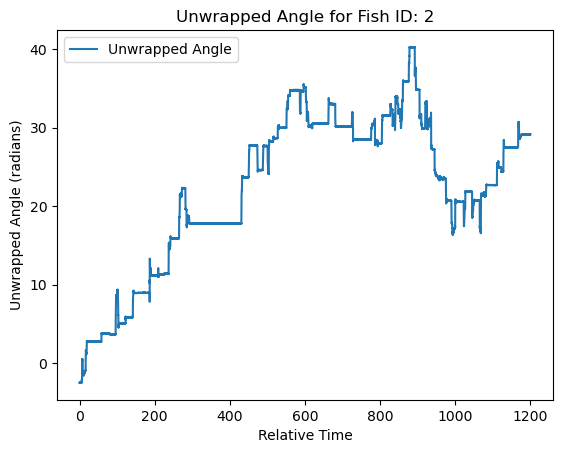

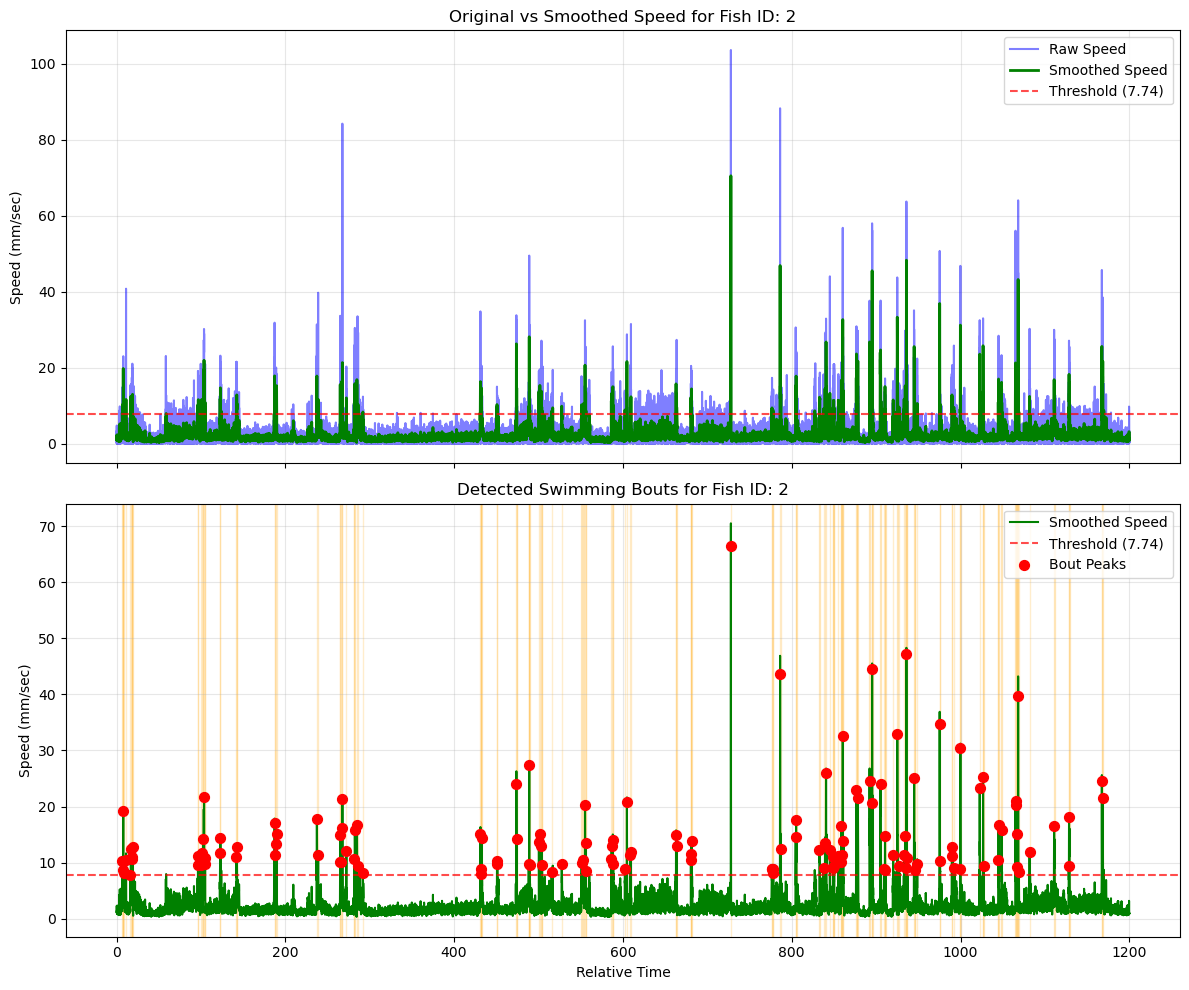

Histograms for Fish ID: 2


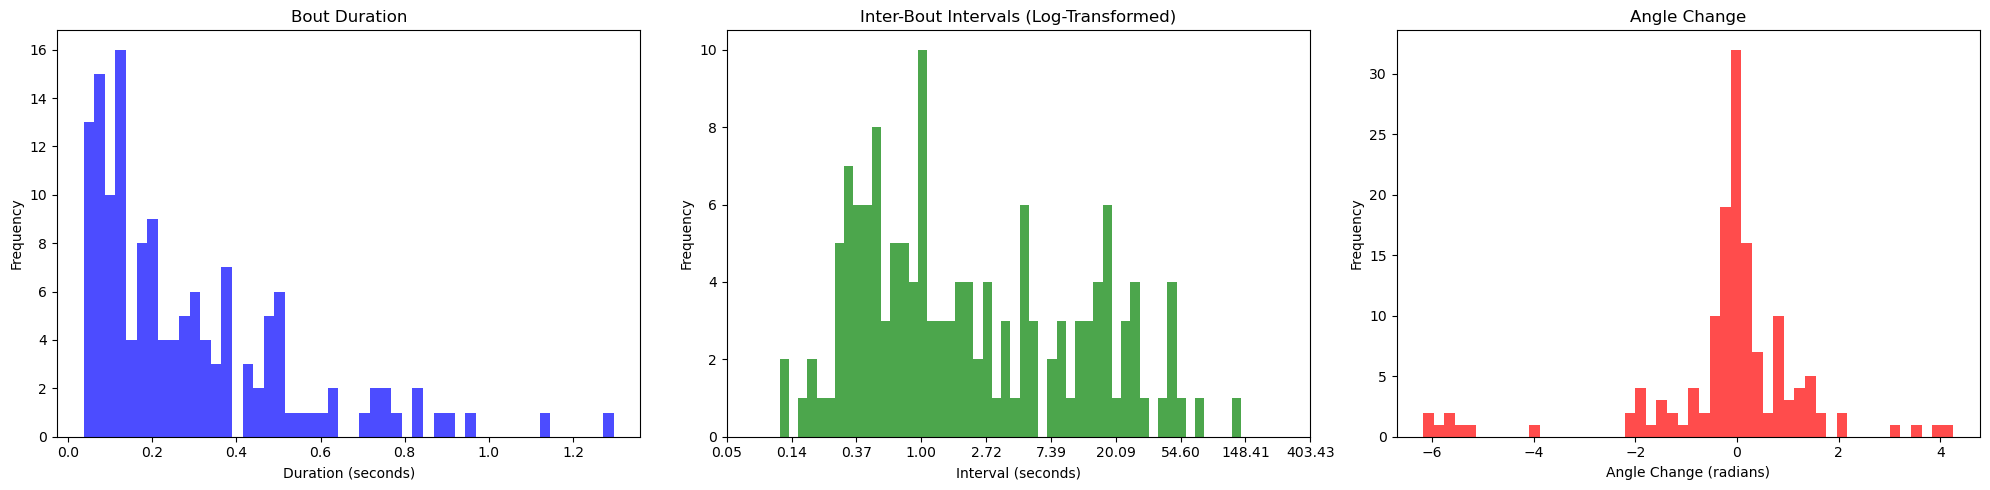

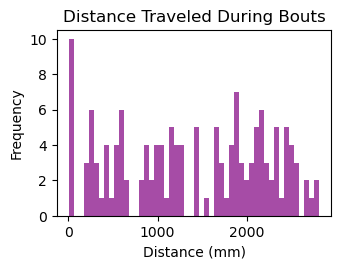

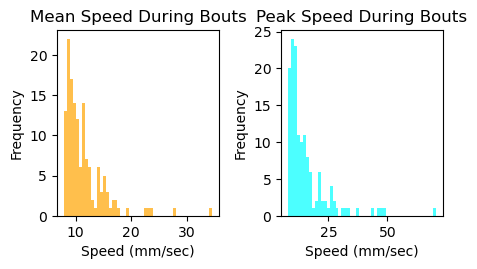

In [248]:
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_phototaxis_left, bout_properties_df_phototaxis_left, fish_id, bins=50)

In [ ]:
selected_fish_ids = [2]  # Replace with the desired fish_ids
for fish_id in selected_fish_ids:
    plot_all_metrics(derived_metrics_df_phototaxis_right, bout_properties_df_phototaxis_right, fish_id, bins=50)

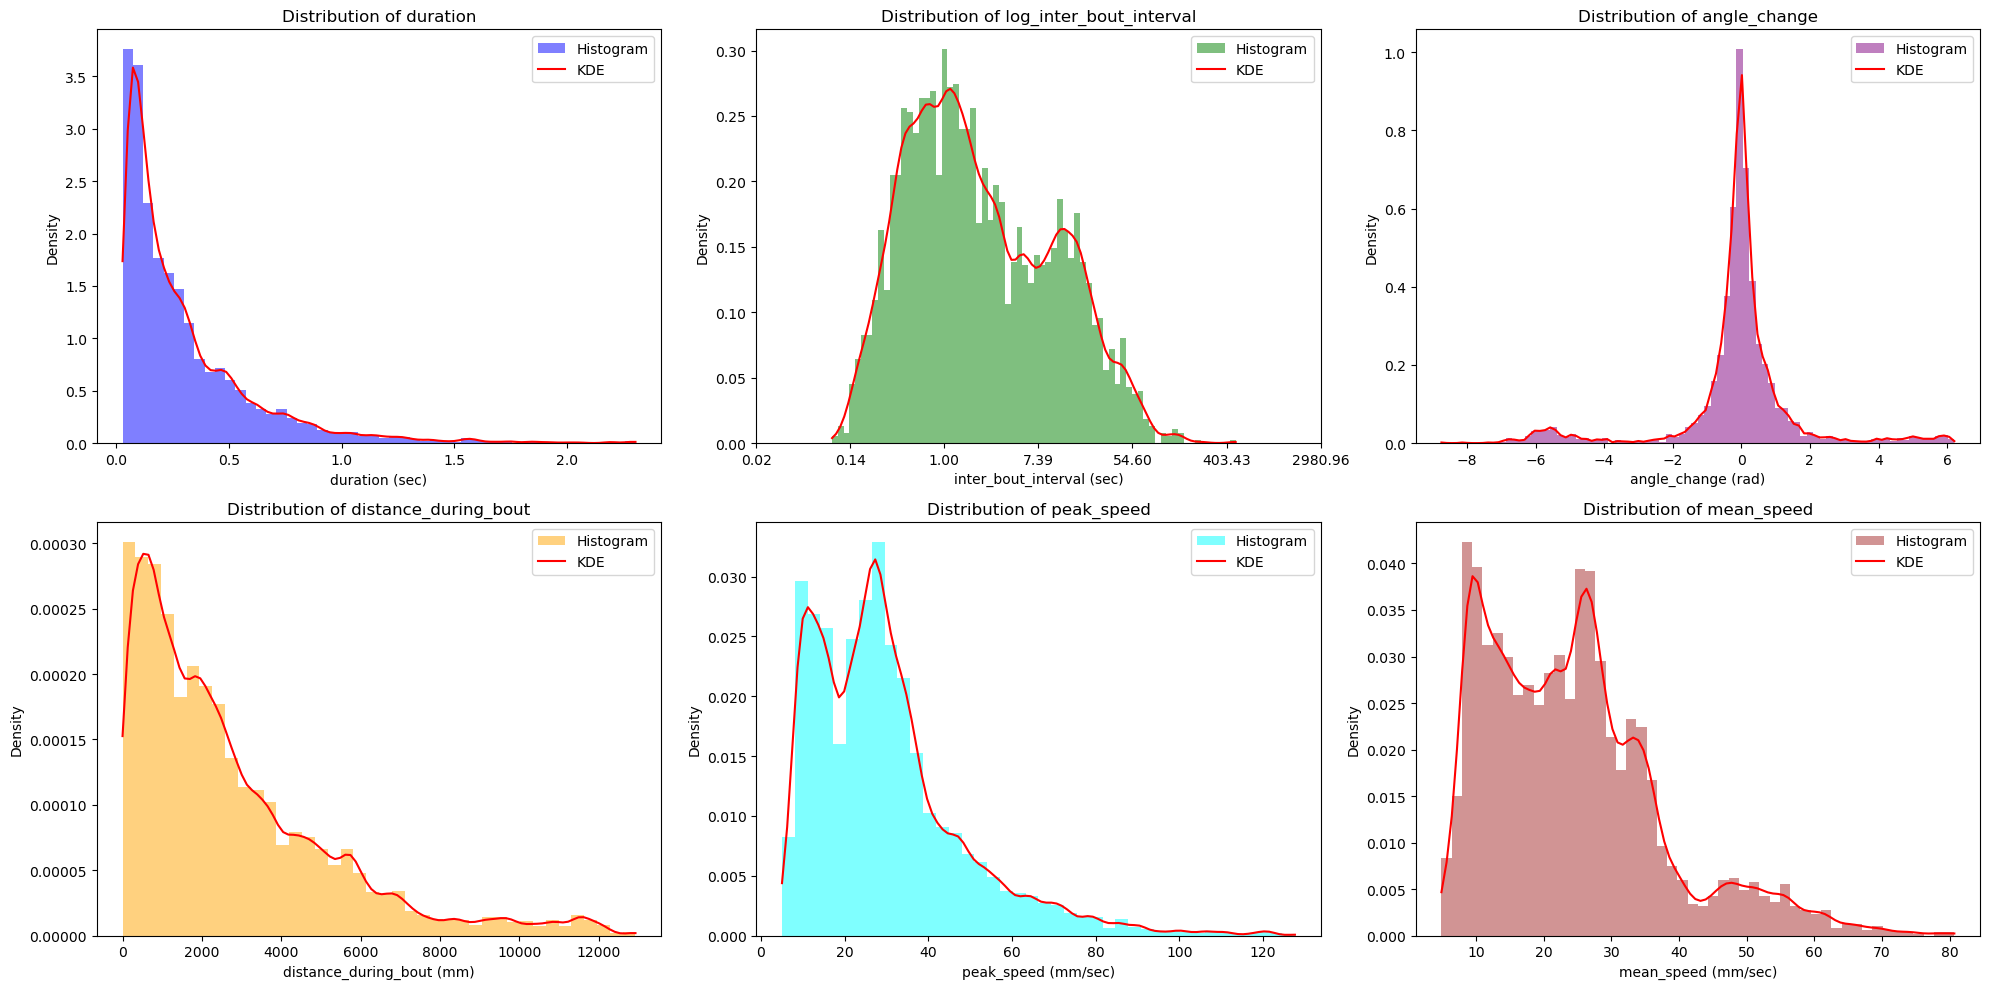

In [279]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }
# Step 1: Calculate KDEs
kde_dict_phototaxis_left = calculate_kdes(bout_properties_df_phototaxis_left, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_phototaxis_left, bout_properties_df_phototaxis_left, bins_dict)

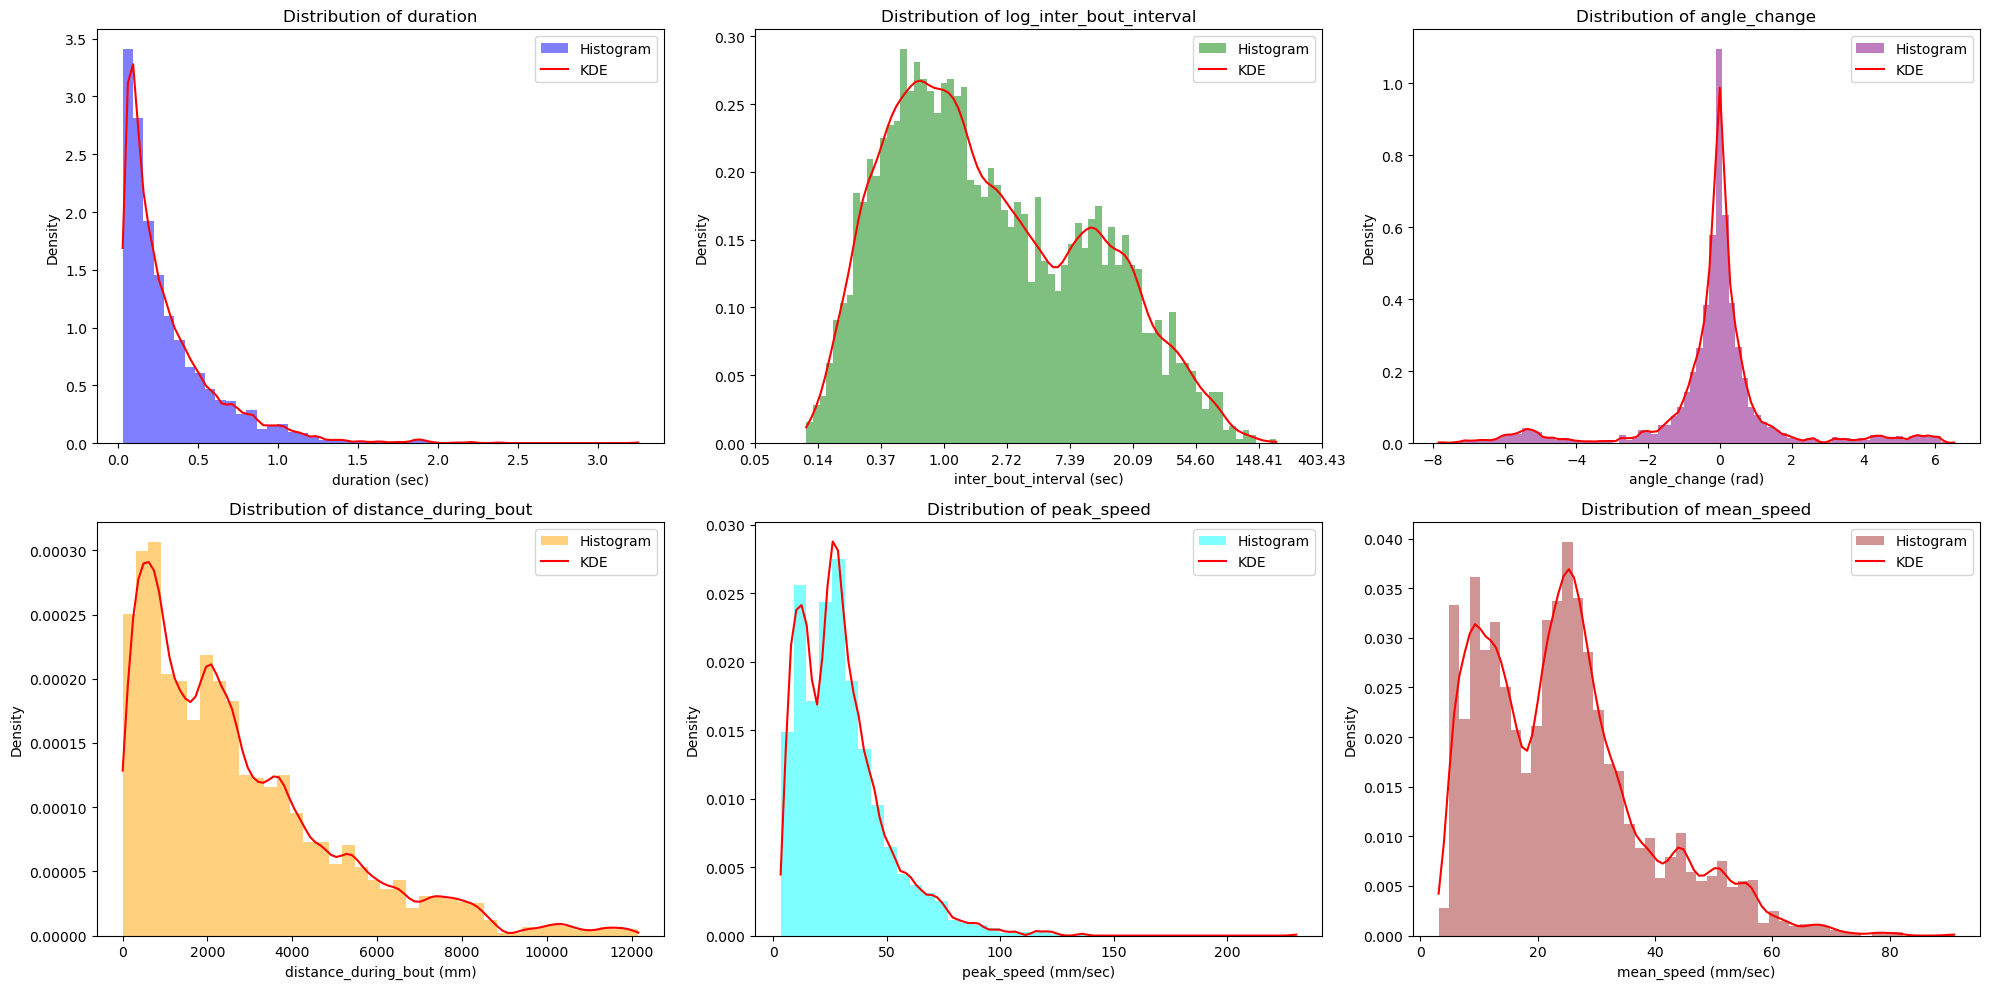

In [280]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']
bins_dict = {
    'duration': 50,
    'log_inter_bout_interval': 70,
    'angle_change': 80,
    'distance_during_bout': 40,
    'peak_speed': 40,
    'mean_speed': 50 }
bandwidths = {
    'duration': 0.095,
    'log_inter_bout_interval': 0.1,
    'angle_change': 0.05,
    'distance_during_bout': 0.08,
    'peak_speed': 0.1,
    'mean_speed': 0.1 }

# Step 1: Calculate KDEs
kde_dict_phototaxis_right = calculate_kdes(bout_properties_df_phototaxis_right, columns_to_analyze, bandwidths)

# Step 2: Plot histograms and KDEs
plot_kde_histograms(kde_dict_phototaxis_right, bout_properties_df_phototaxis_right, bins_dict)

Estimated bouts_per_path: 147


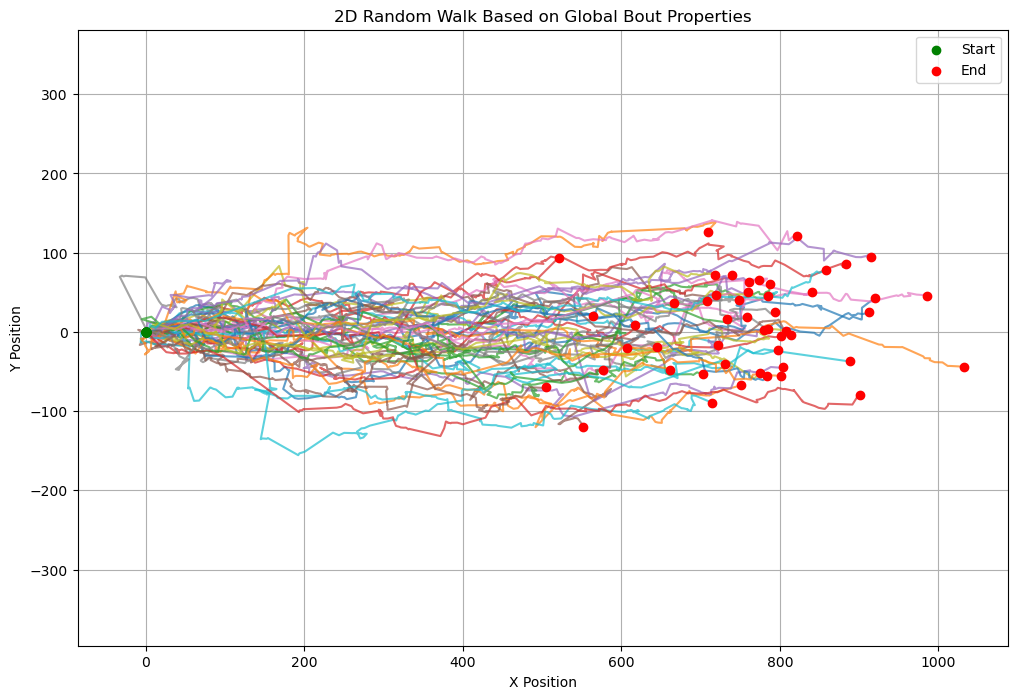

In [89]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_phototaxis_left,bout_properties_df_phototaxis_left, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

Estimated bouts_per_path: 144


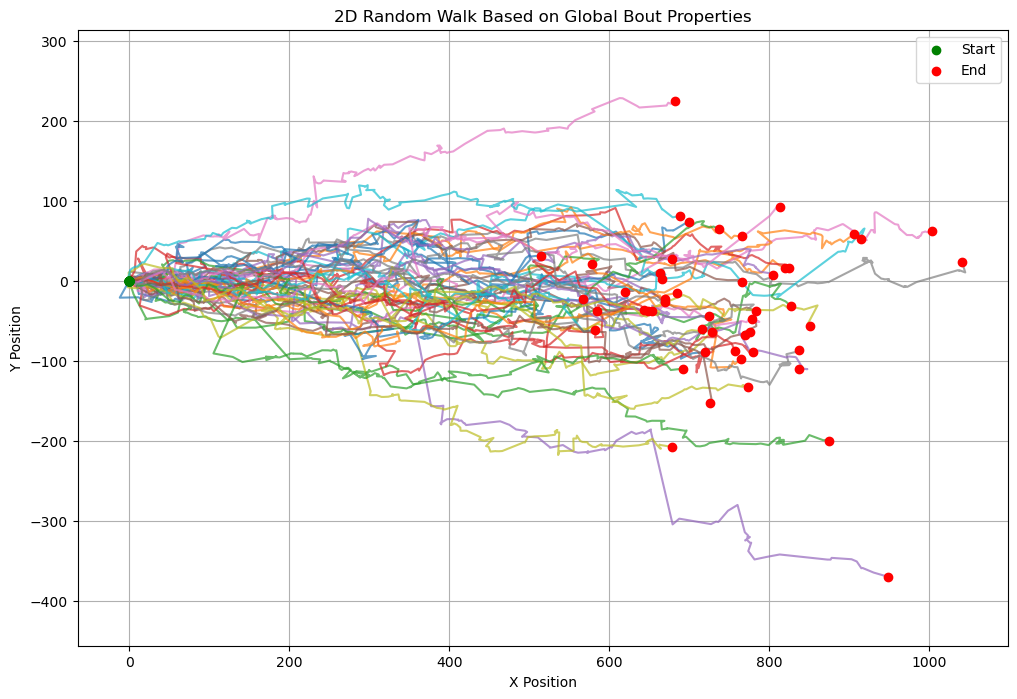

In [90]:
# Simulate the random walk
X, Y, time = simulate_2d_random_walk(kde_dict_phototaxis_right,bout_properties_df_phototaxis_right, paths=50, bouts_per_path=None) #bouts_per_path=None will estimate the number of bouts per path based on the data

# Plot the random walk
plot_random_walk(X, Y)

In [281]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

def plot_bout_property_comparison(bout_properties_df1, bout_properties_df2, label1, label2, column, bins=100):
    """
    Plot QQ plot and overlay histograms for a specified bout property between two datasets.

    Parameters:
    - bout_properties_df1 (pd.DataFrame): First bout properties DataFrame.
    - bout_properties_df2 (pd.DataFrame): Second bout properties DataFrame.
    - label1 (str): Label for the first dataset (e.g., 'Bright').
    - label2 (str): Label for the second dataset (e.g., 'Phototaxis Left').
    - column (str): Column to compare (e.g., 'duration', 'angle_change').
    - bins (int): Number of bins for the histograms (default: 100).
    """
    # Extract data for the specified column
    data1 = bout_properties_df1[column].dropna()
    data2 = bout_properties_df2[column].dropna()

    # Create histograms for the data
    hist_data1 = np.histogram(data1, bins=bins, density=False)[0]
    hist_data2 = np.histogram(data2, bins=bins, density=False)[0]

    # Create ProbPlot objects for QQ plot
    pp_x = sm.ProbPlot(data1)
    pp_y = sm.ProbPlot(data2)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    #  Plot the QQ plot on the first subplot
    qqplot_2samples(pp_x, pp_y, xlabel=None, ylabel=None, line='45', ax=axes[0])
    axes[0].set_title(f'QQ Plot of {column.capitalize()}: {label1} vs {label2}')
    axes[0].grid()

    # Automatically set x-axis limits based on observed quantiles
    observed_min = min(data1.min(), data2.min())
    observed_max = max(data1.max(), data2.max())
    axes[0].set_xlim(observed_min, observed_max)

    # Overlay the histograms on the second subplot
    bins_range = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), bins)
    axes[1].hist(data1, bins=bins_range, alpha=0.7, label=label1, color='blue', density=True)
    axes[1].hist(data2, bins=bins_range, alpha=0.5, label=label2, color='green', density=True)
    axes[1].set_title(f'Histogram of {column.capitalize()}: {label1} vs {label2}')
    axes[1].set_xlabel(f'{column.capitalize()}')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

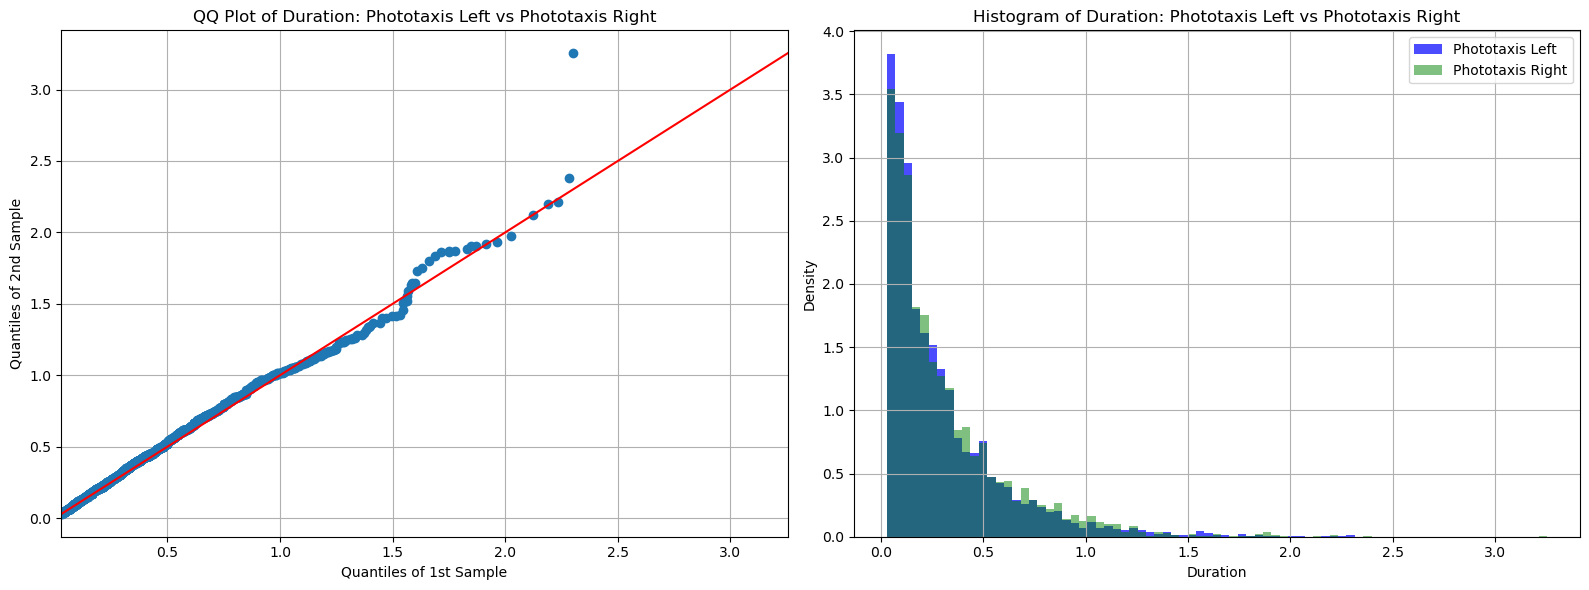

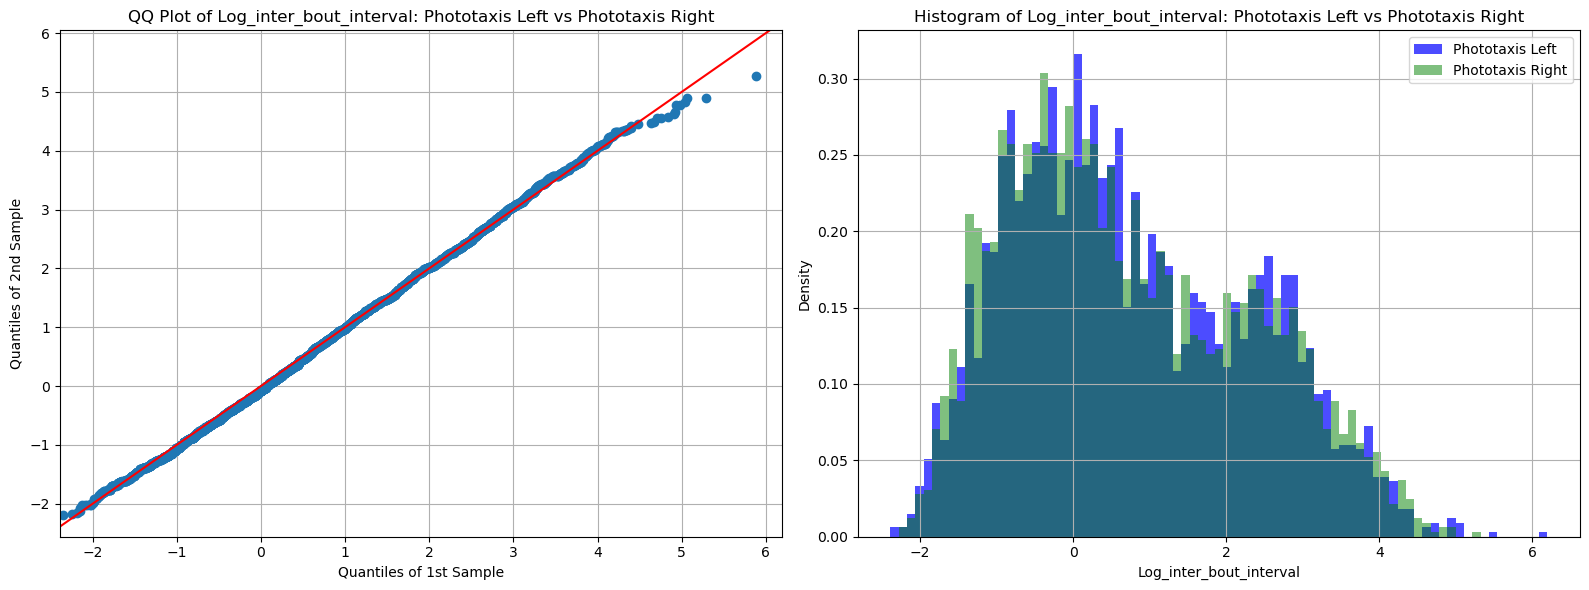

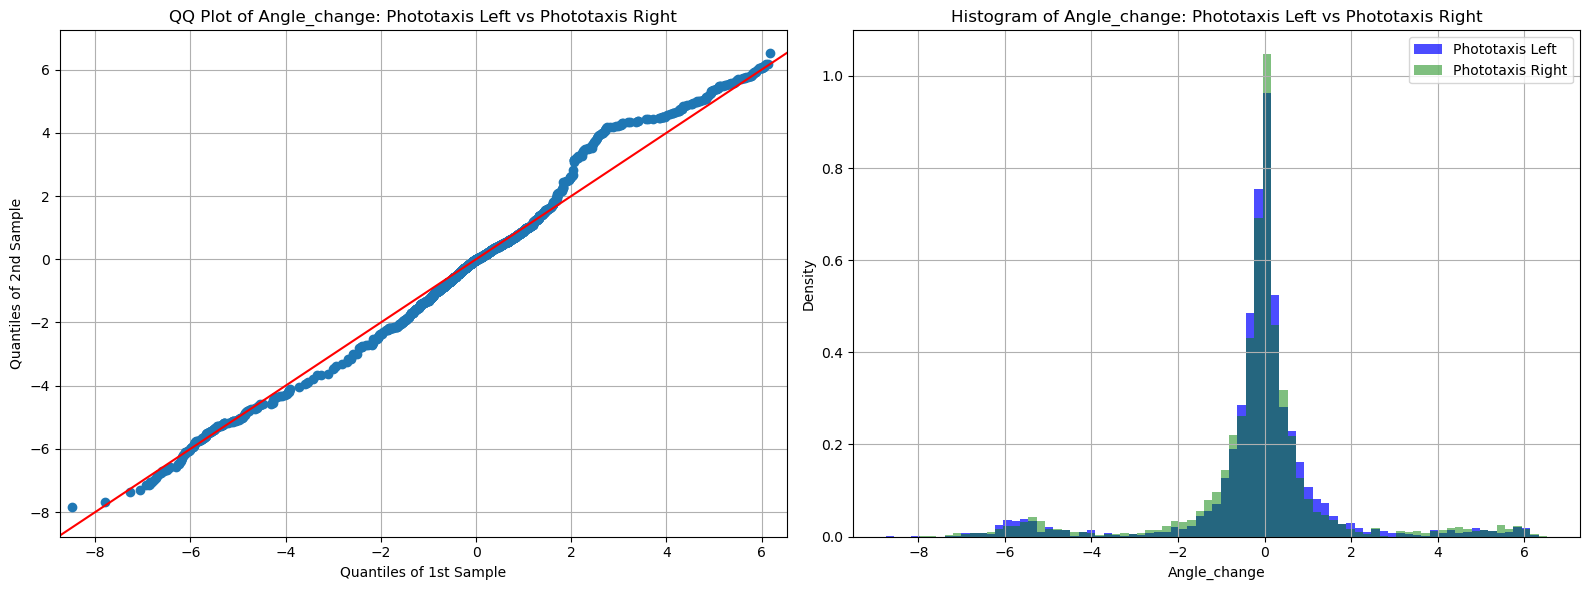

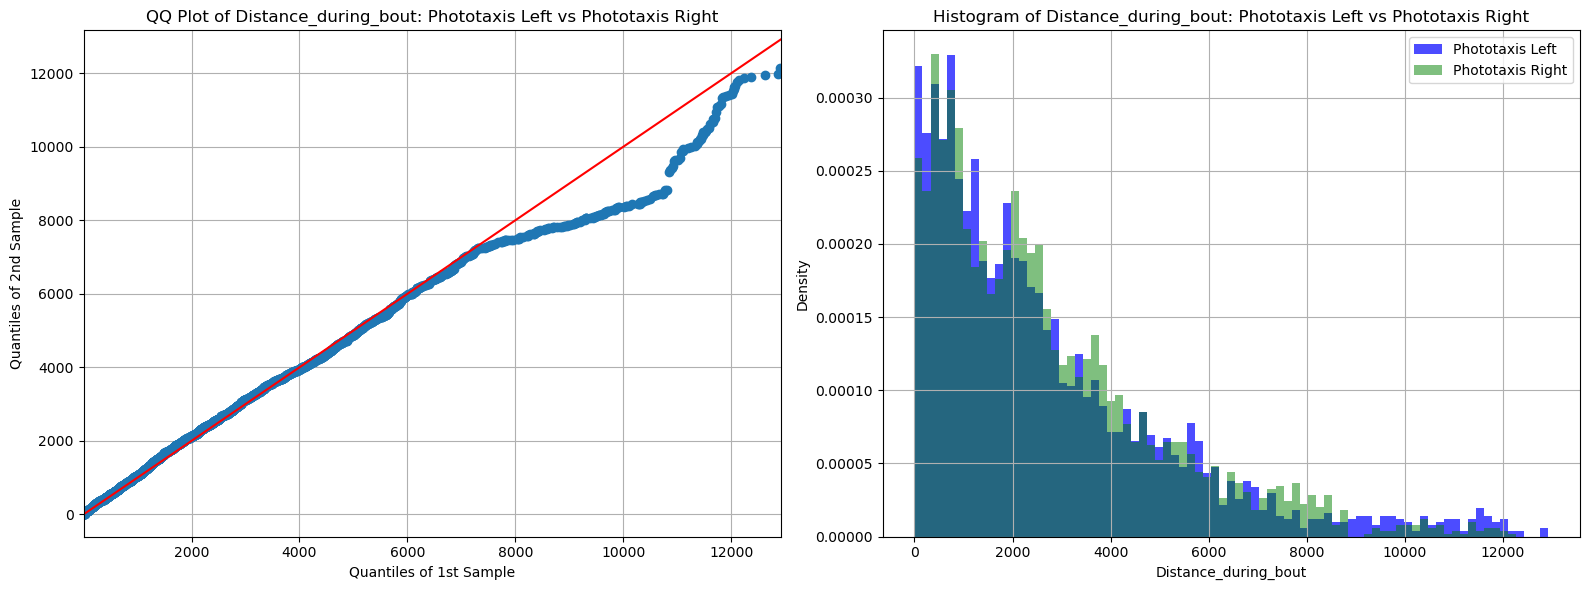

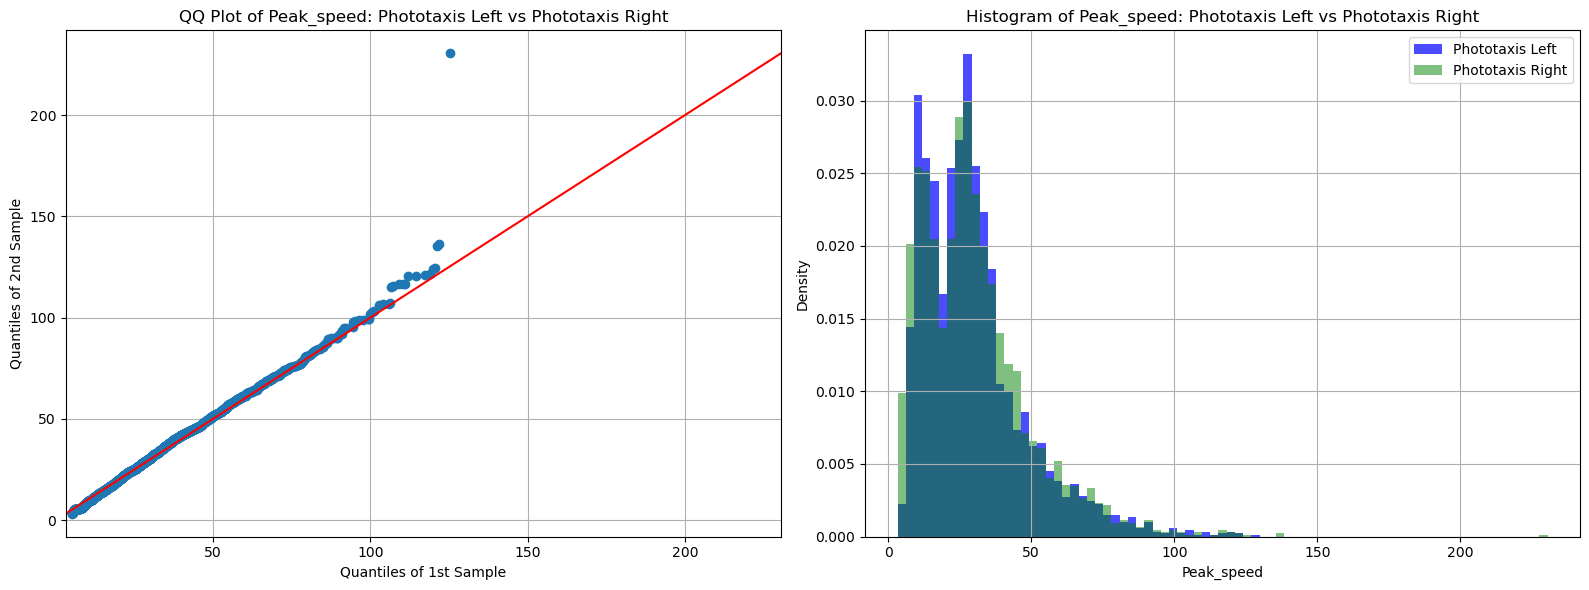

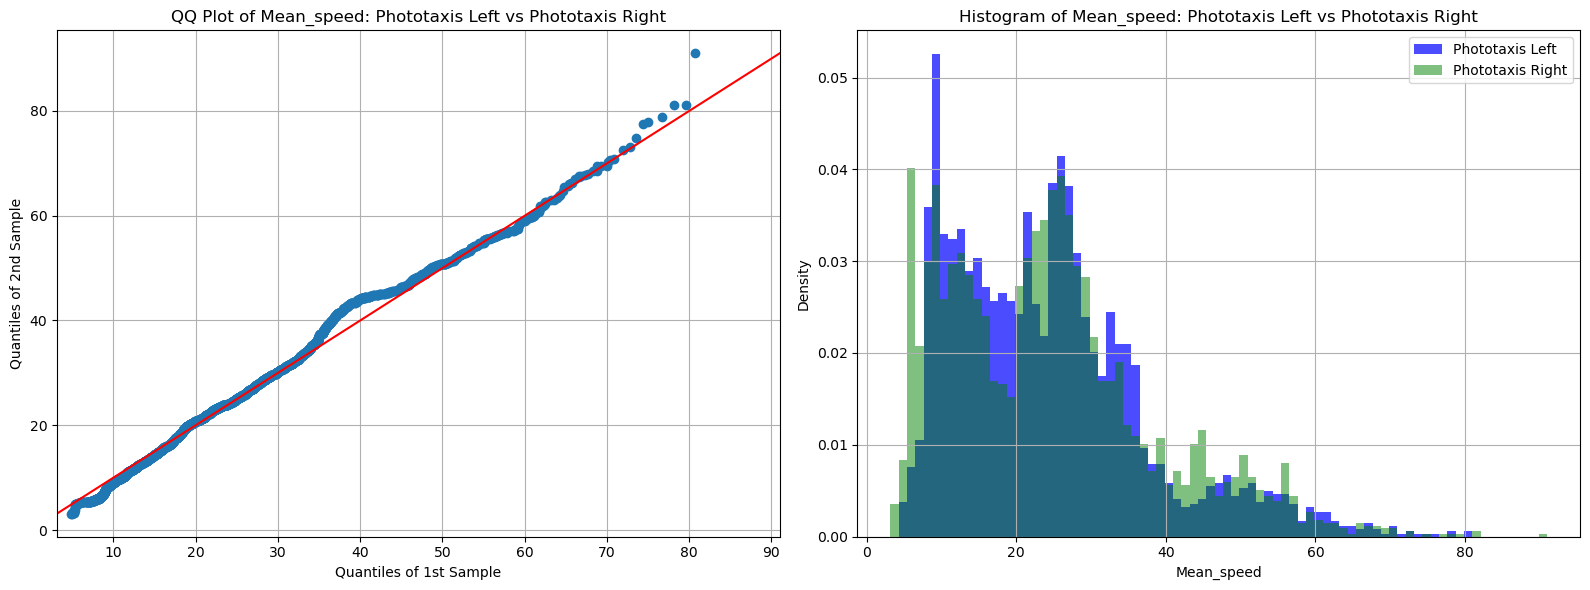

In [287]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_phototaxis_left,
        bout_properties_df2=bout_properties_df_phototaxis_right,
        label1='Phototaxis Left',
        label2='Phototaxis Right',
        column=column,
        bins=80
    )

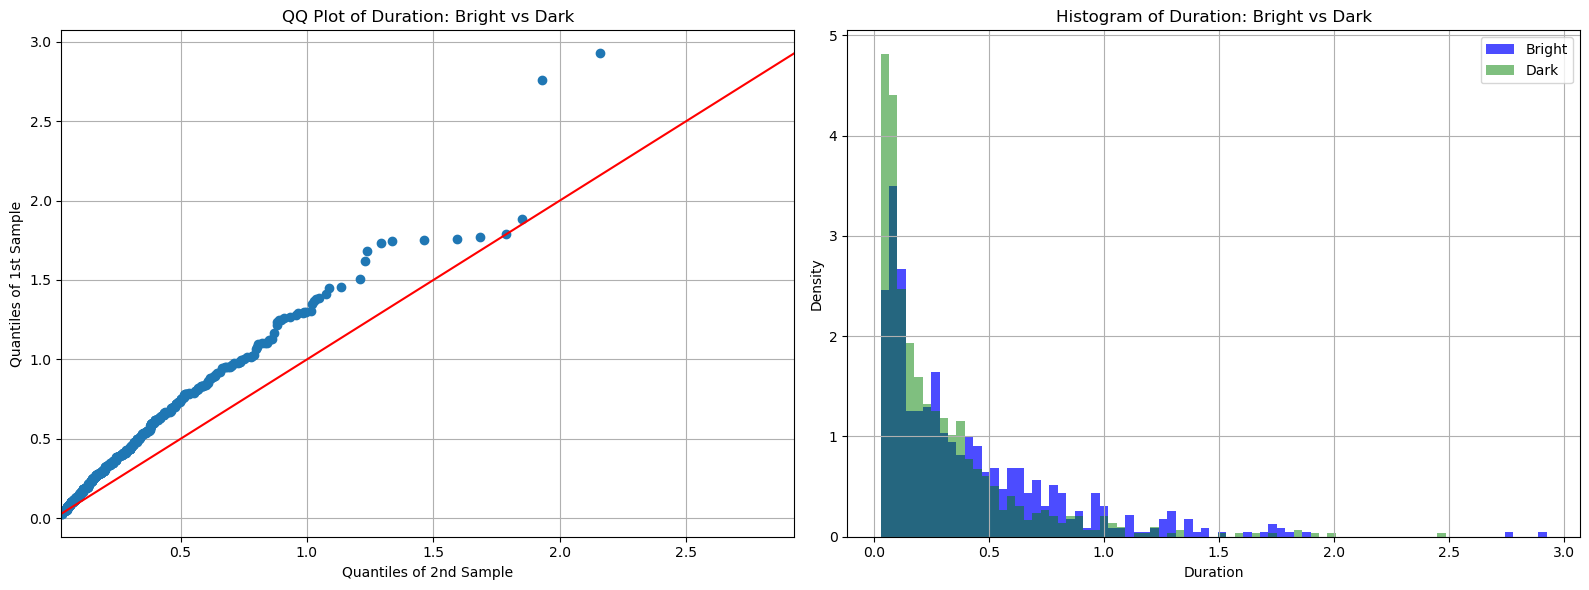

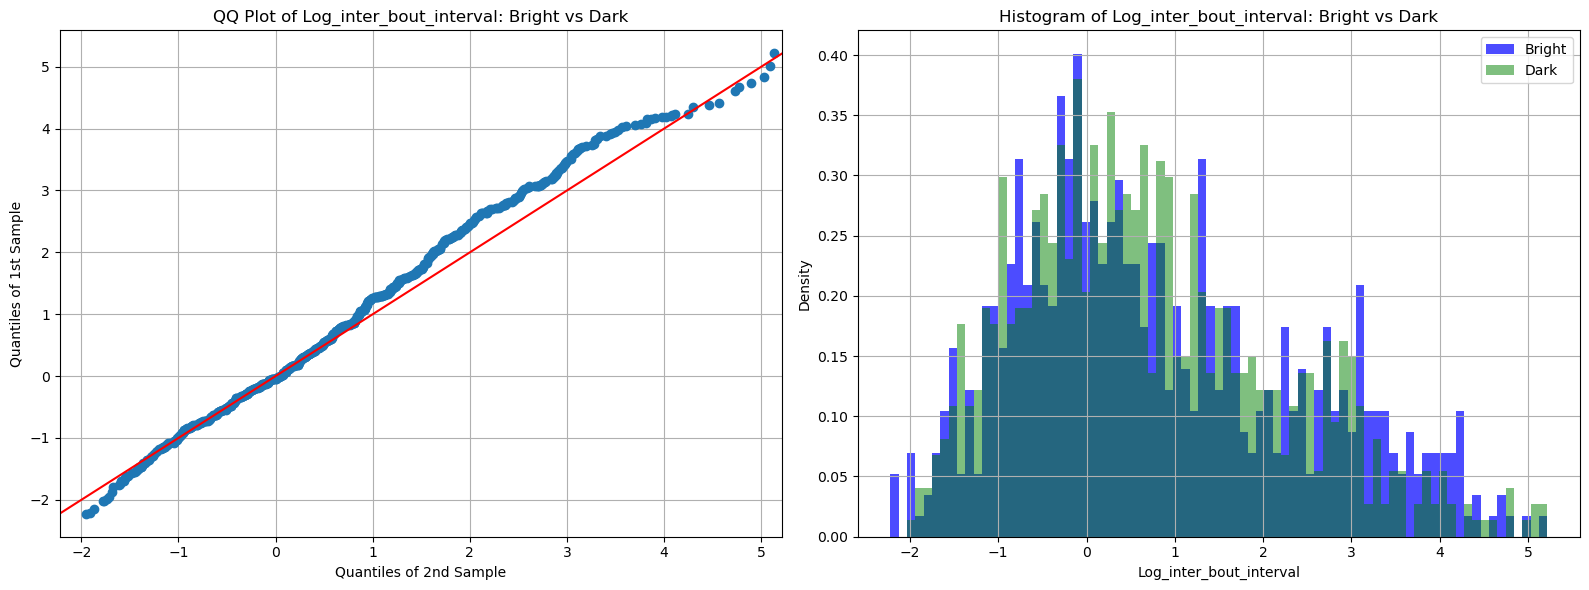

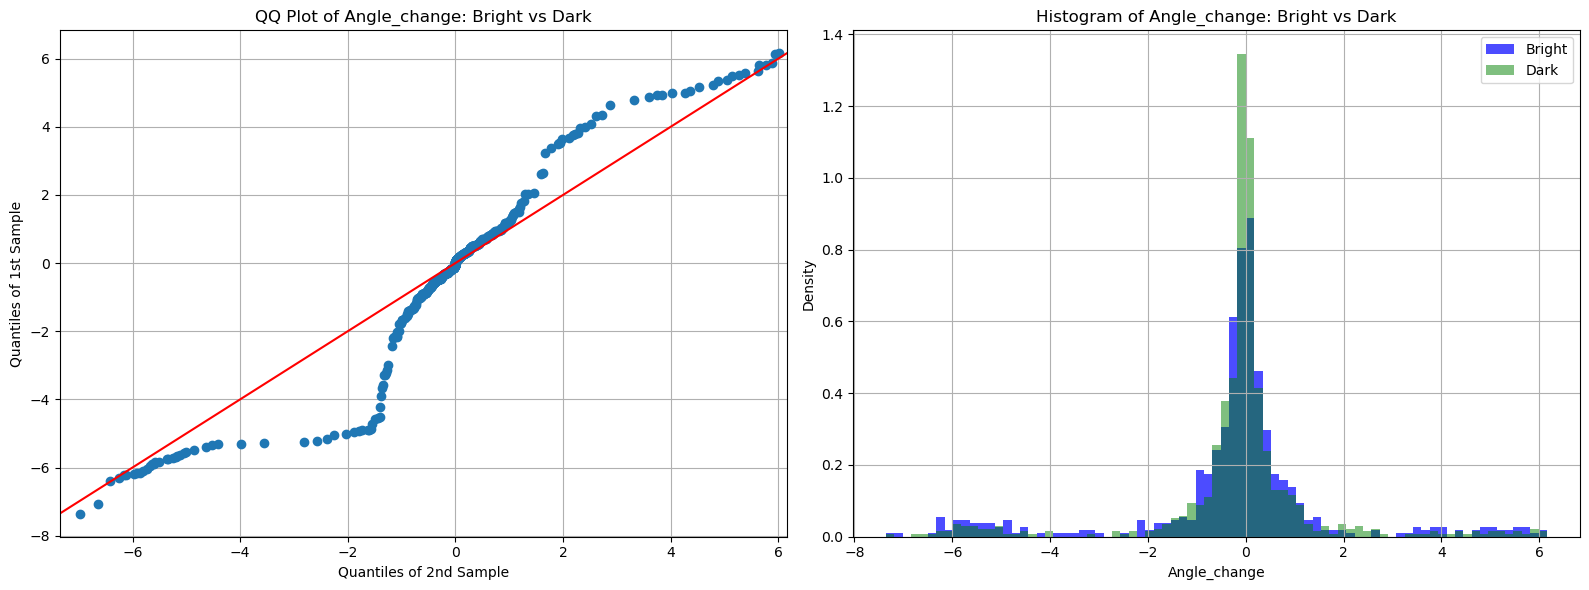

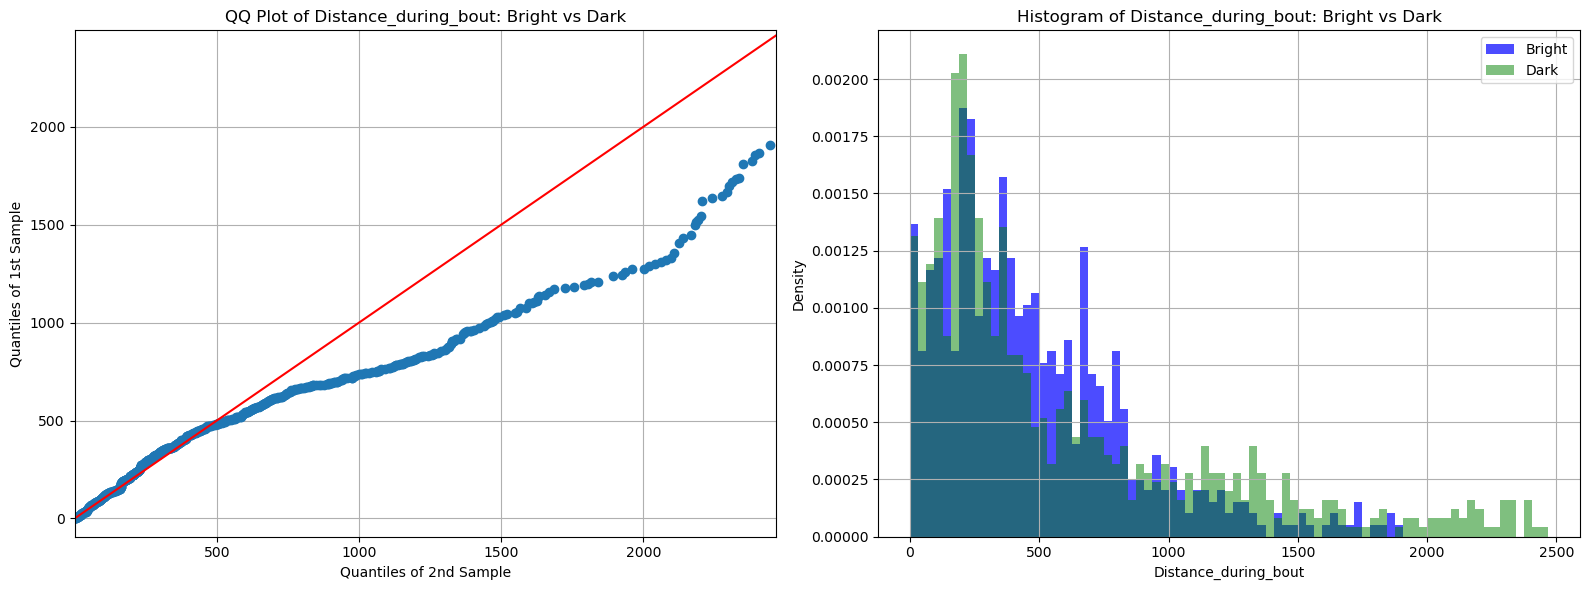

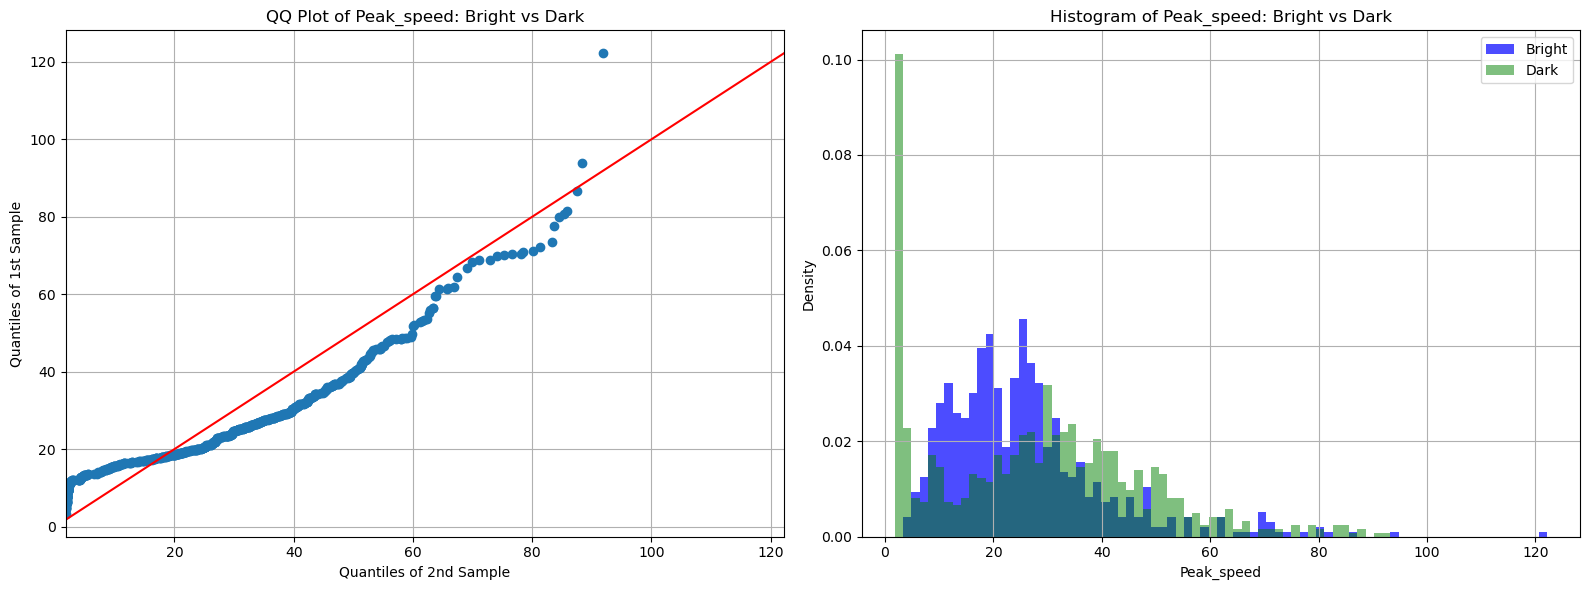

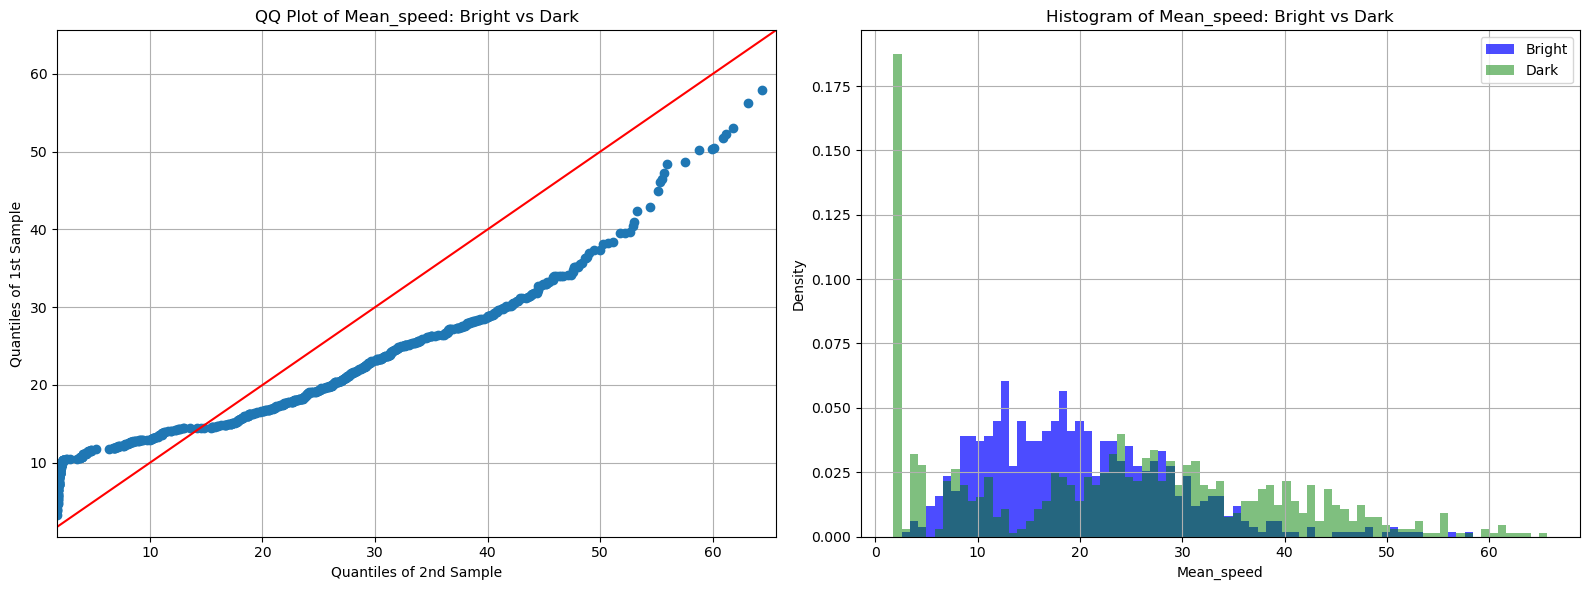

In [288]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_bright,
        bout_properties_df2=bout_properties_df_dark,
        label1='Bright',
        label2='Dark',
        column=column,
        bins=80
    )

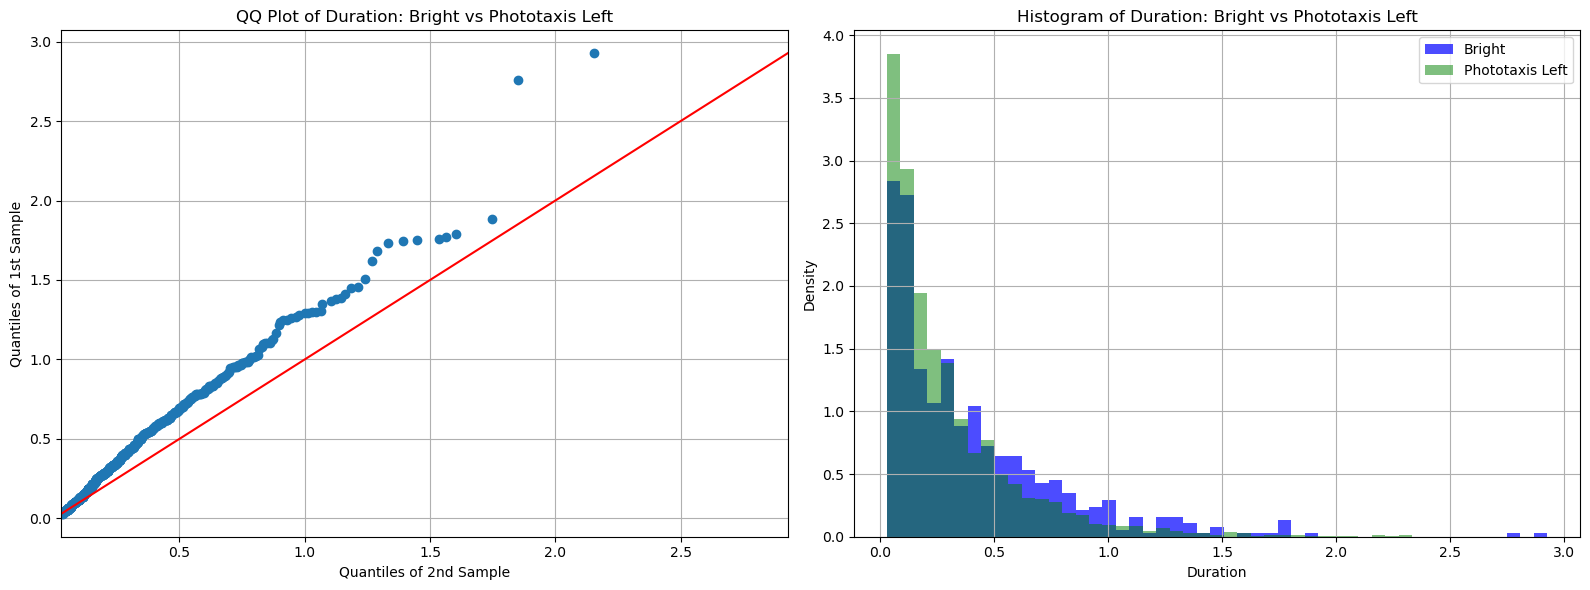

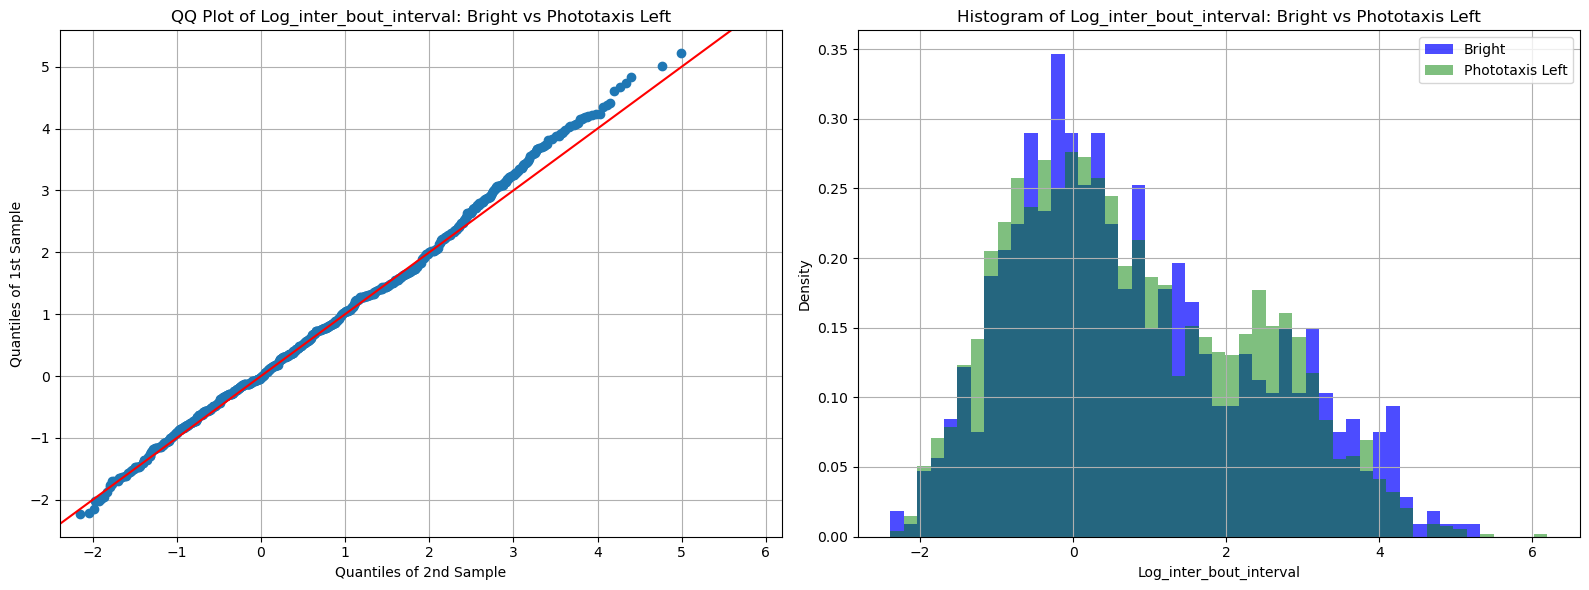

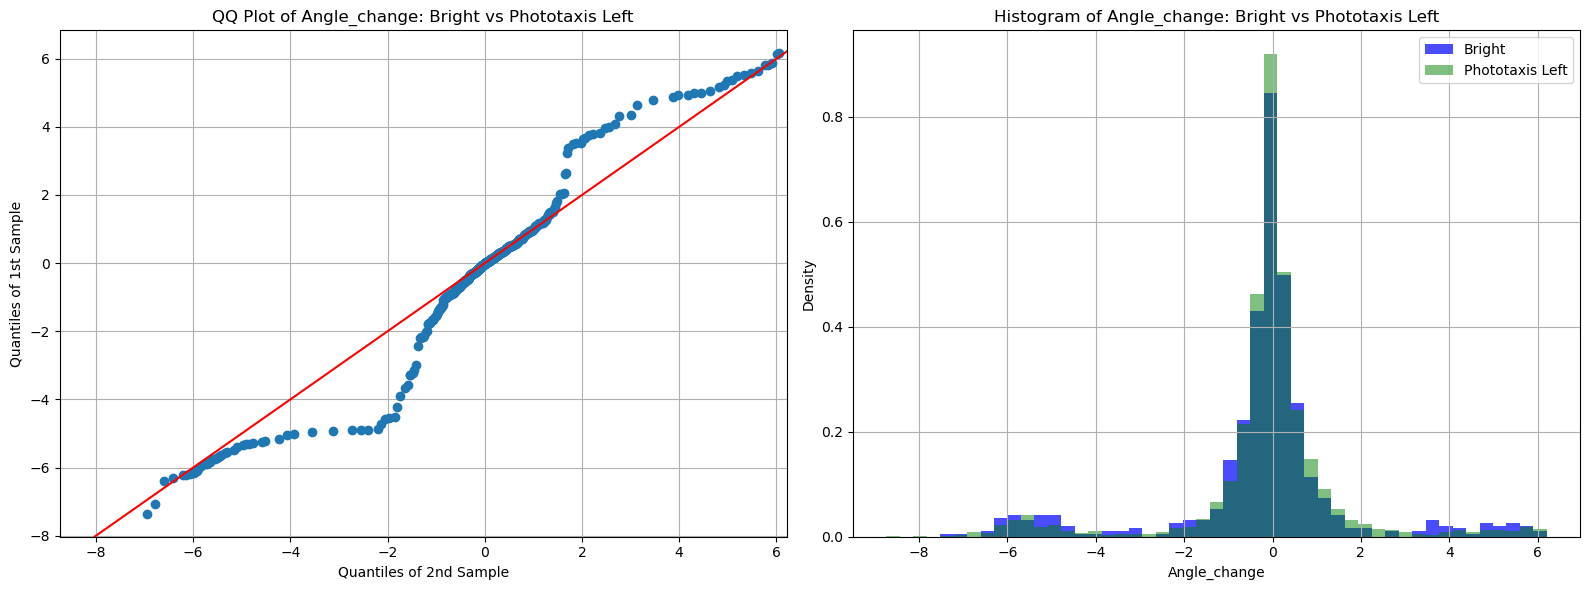

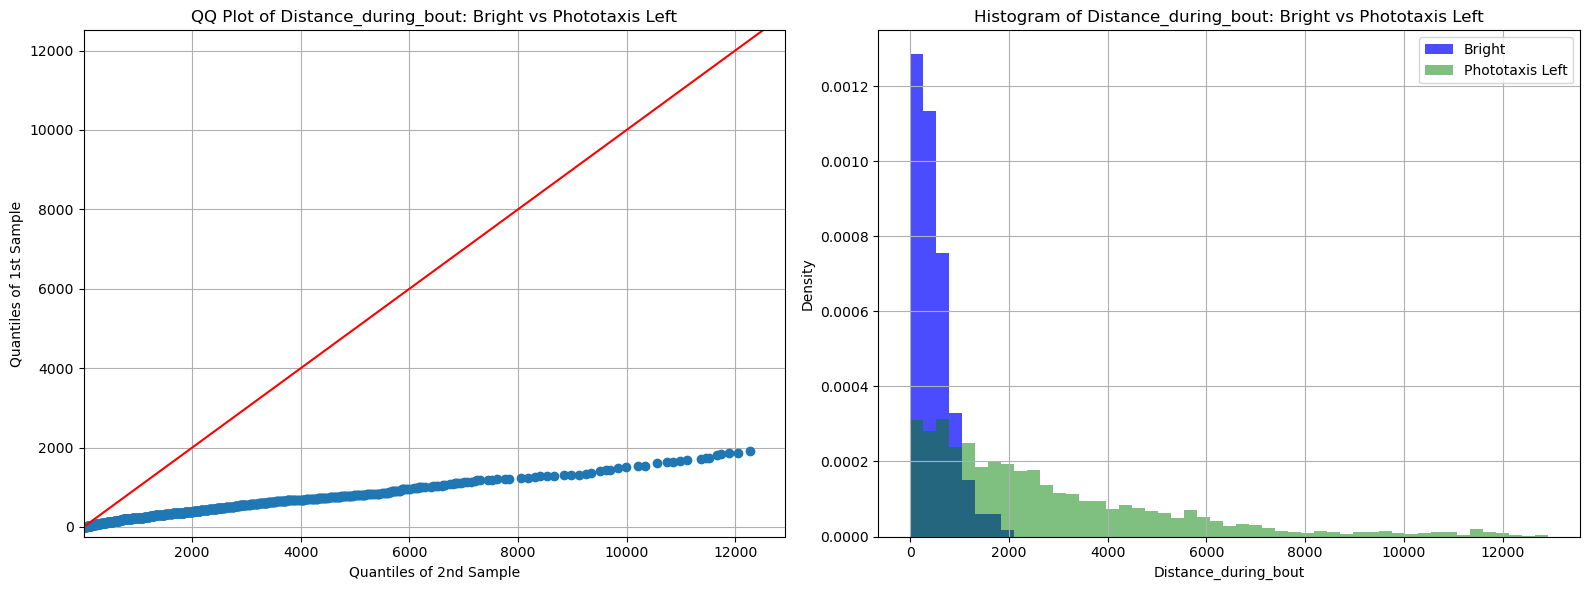

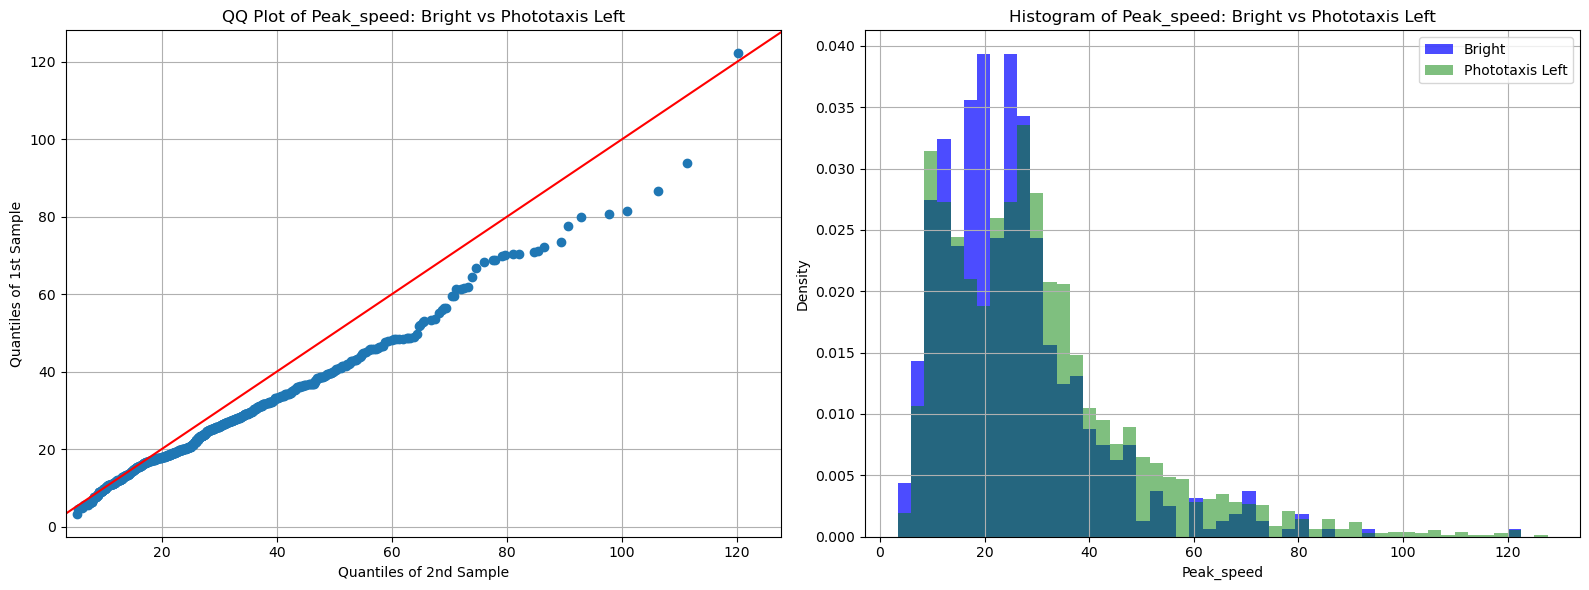

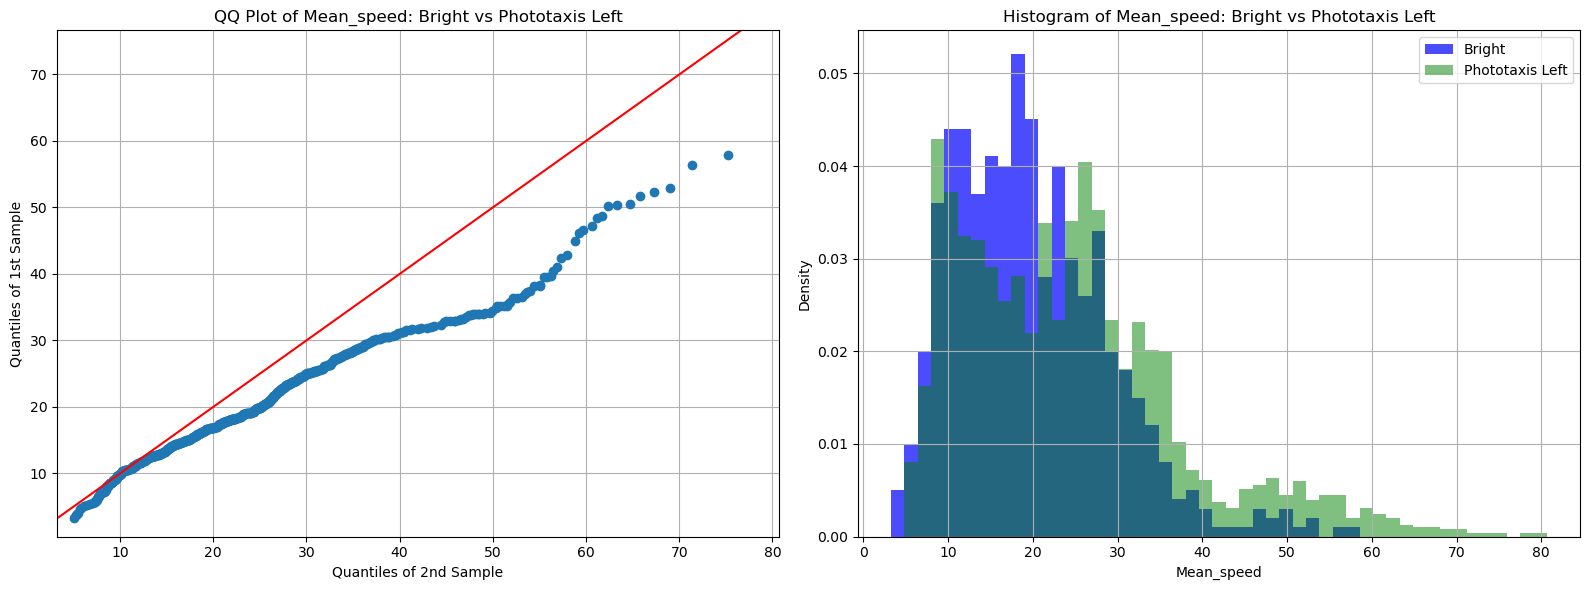

In [284]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_bright,
        bout_properties_df2=bout_properties_df_phototaxis_left,
        label1='Bright',
        label2='Phototaxis Left',
        column=column,
        bins=50
    )

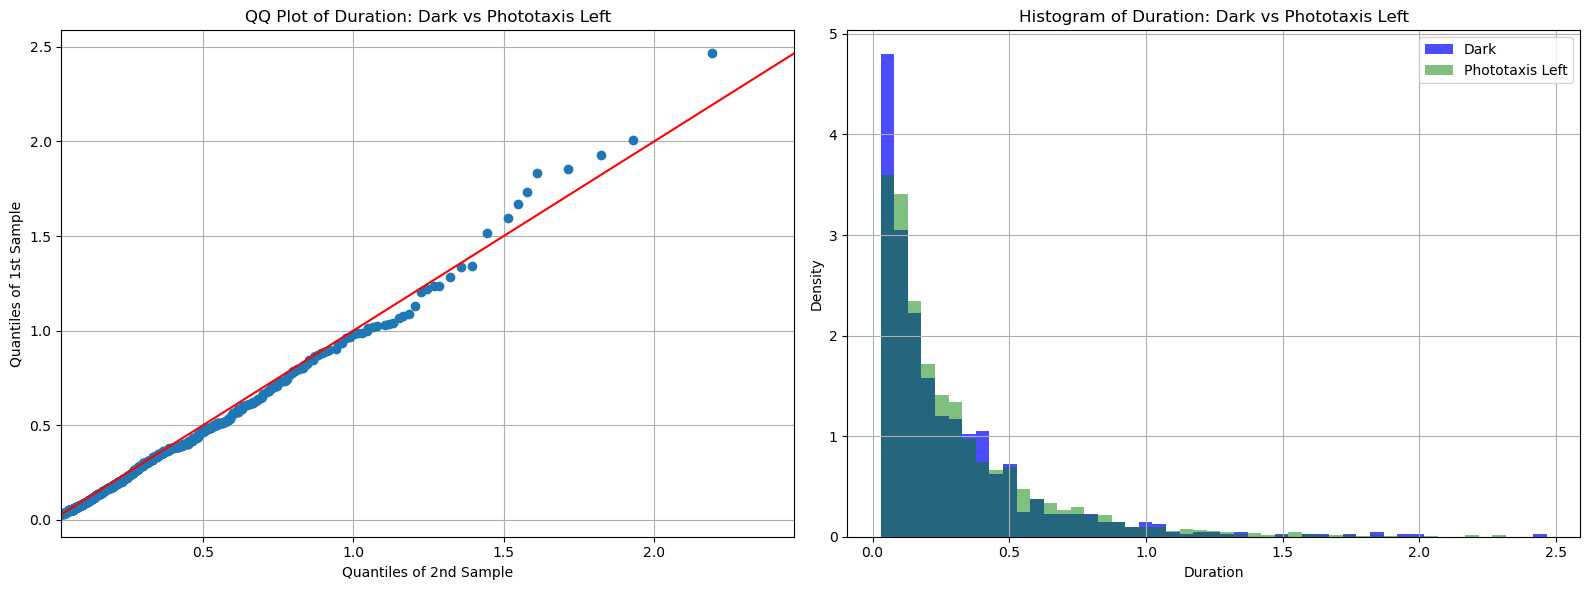

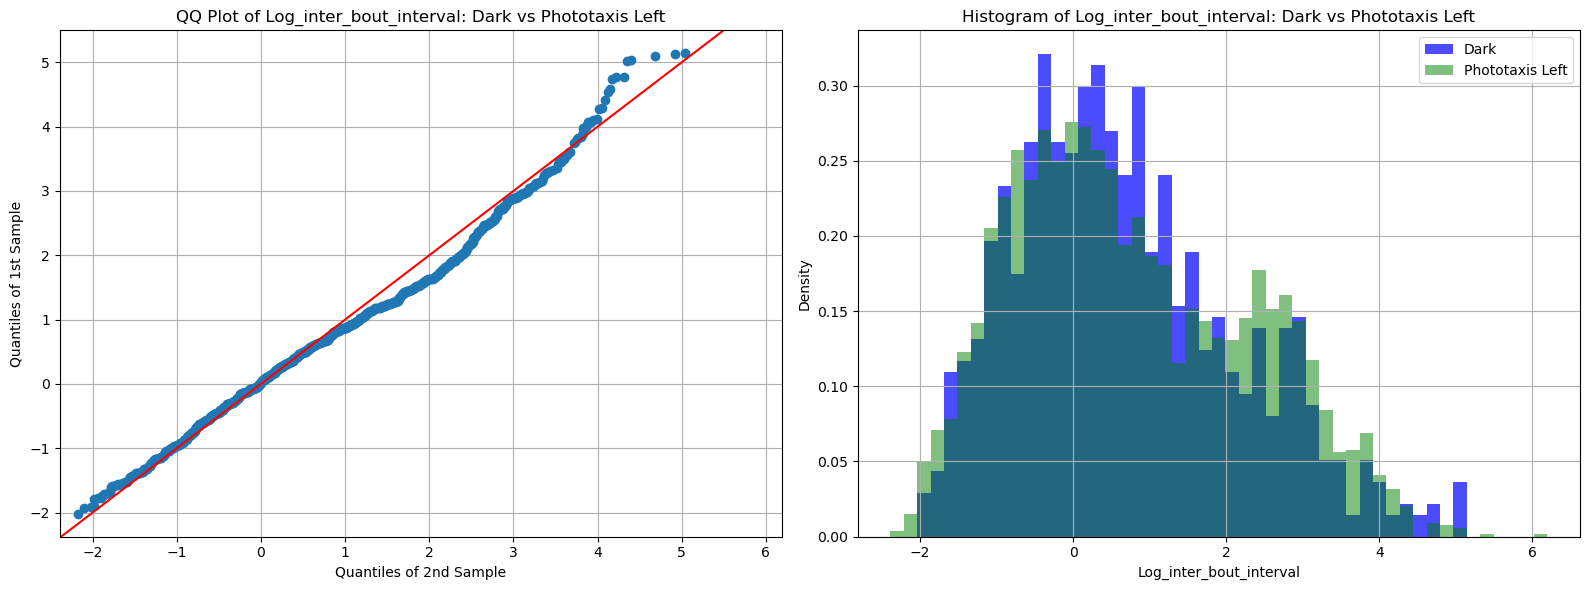

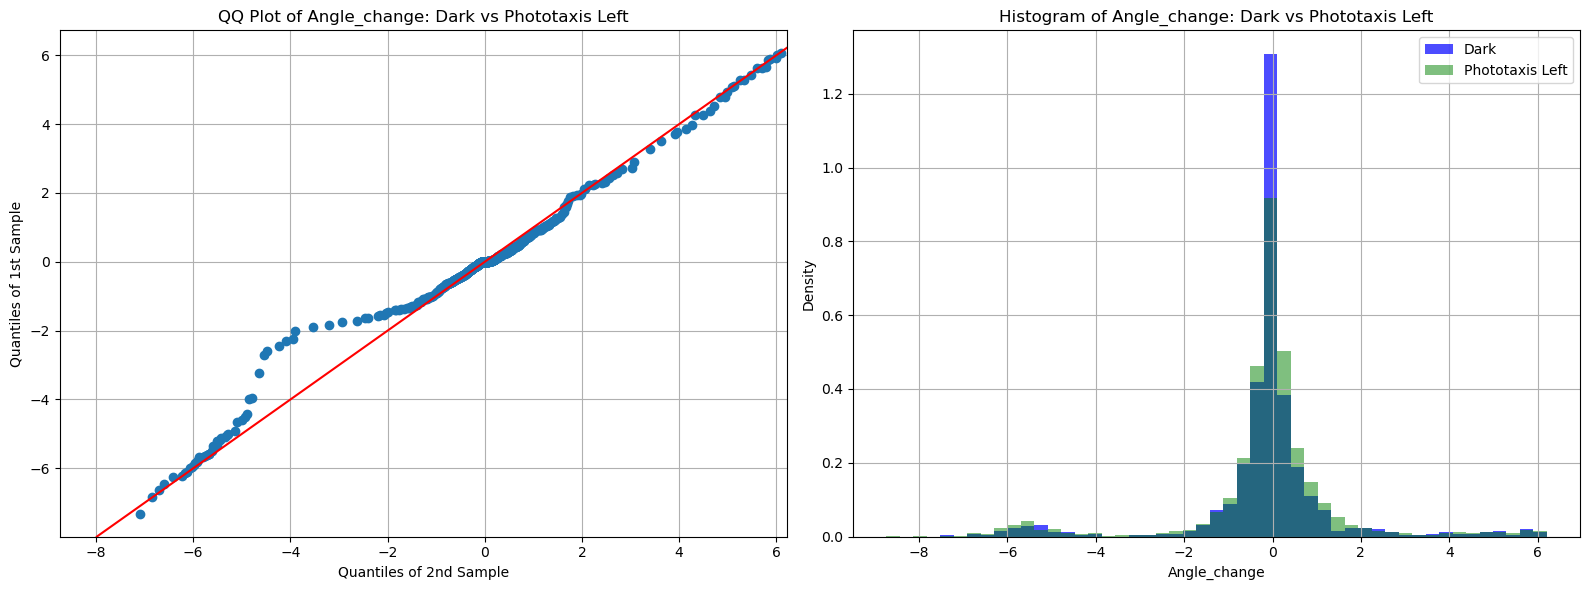

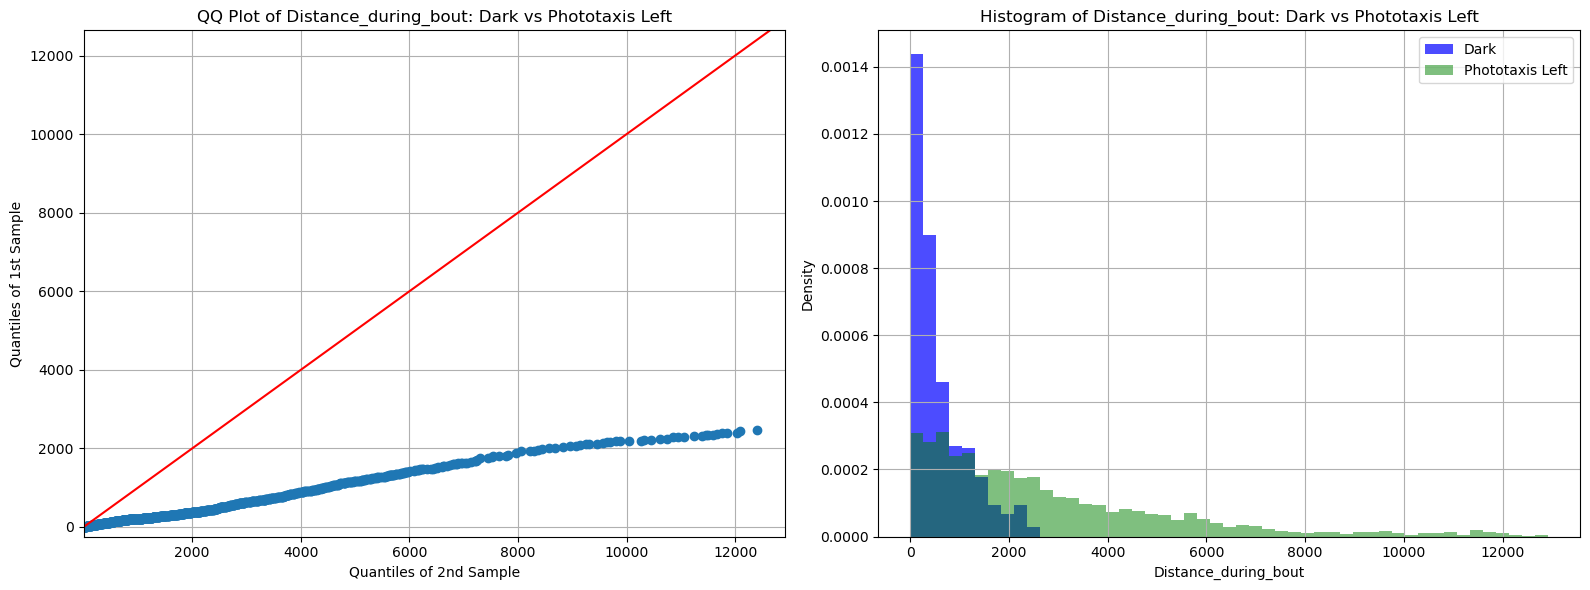

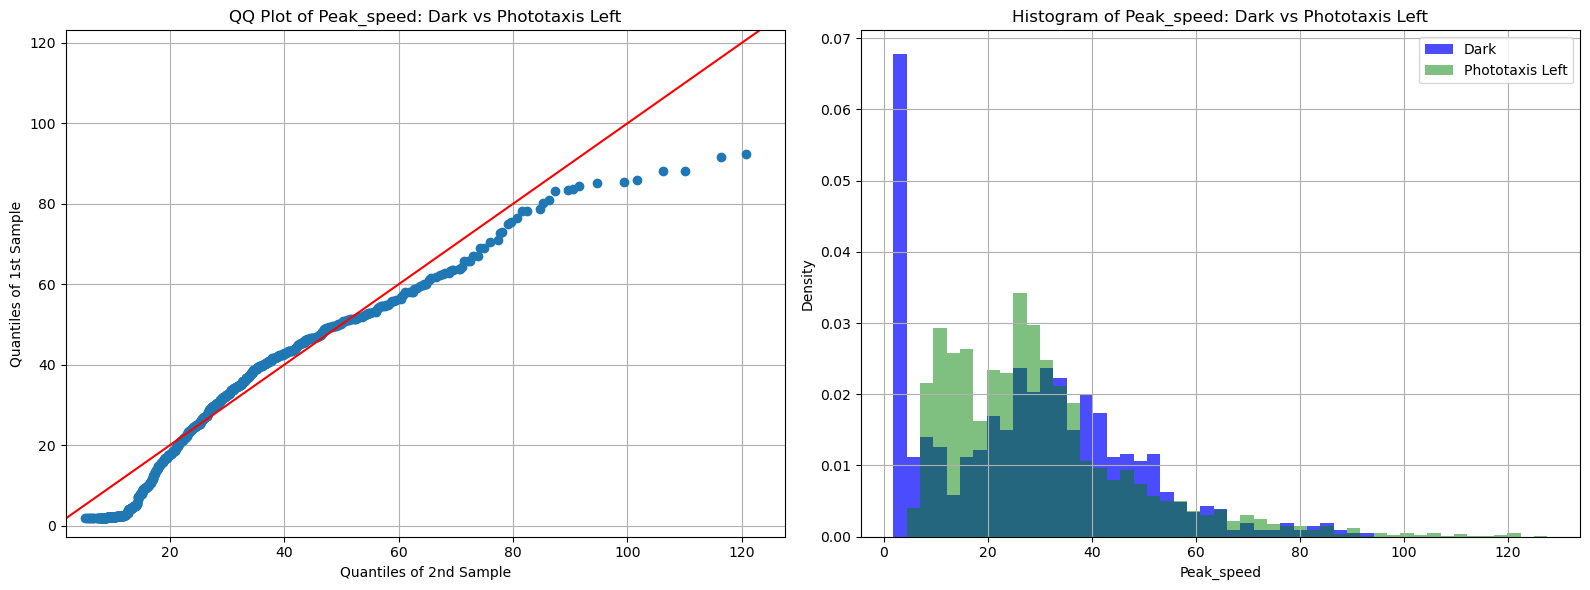

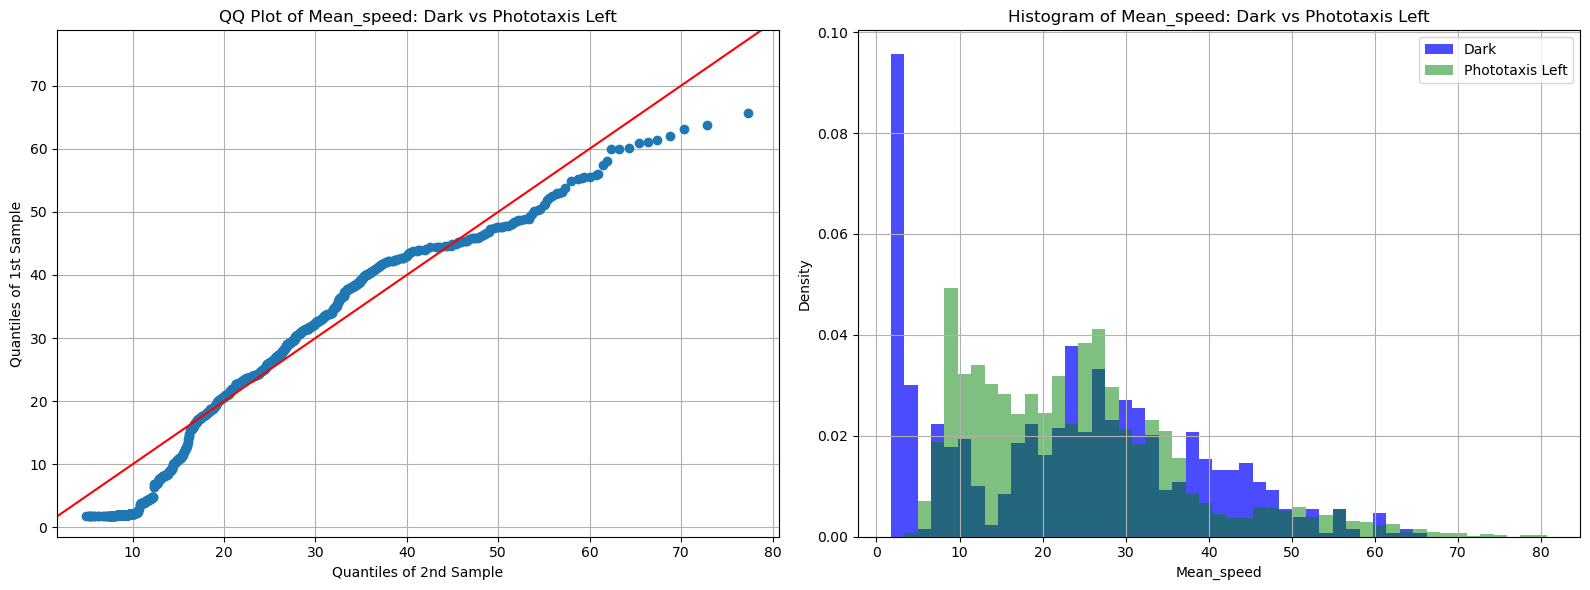

In [285]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_dark,
        bout_properties_df2=bout_properties_df_phototaxis_left,
        label1='Dark',
        label2='Phototaxis Left',
        column=column,
        bins=50
    )

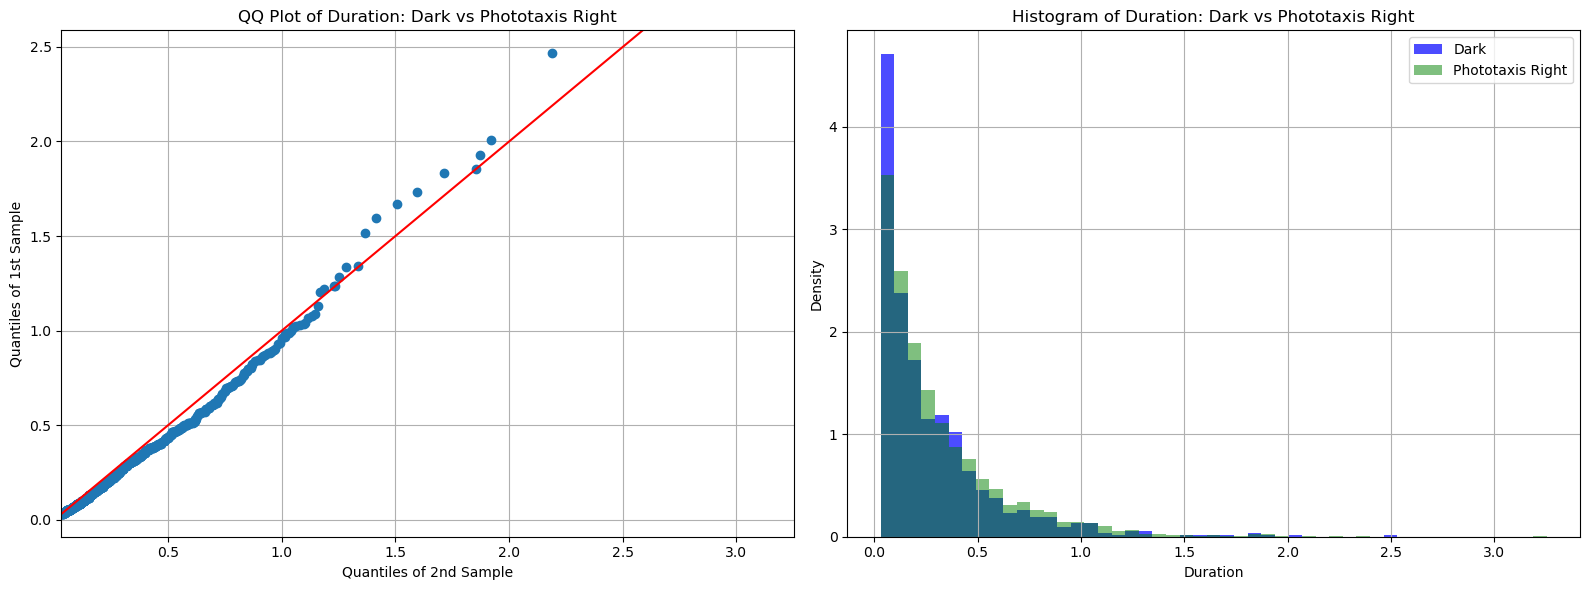

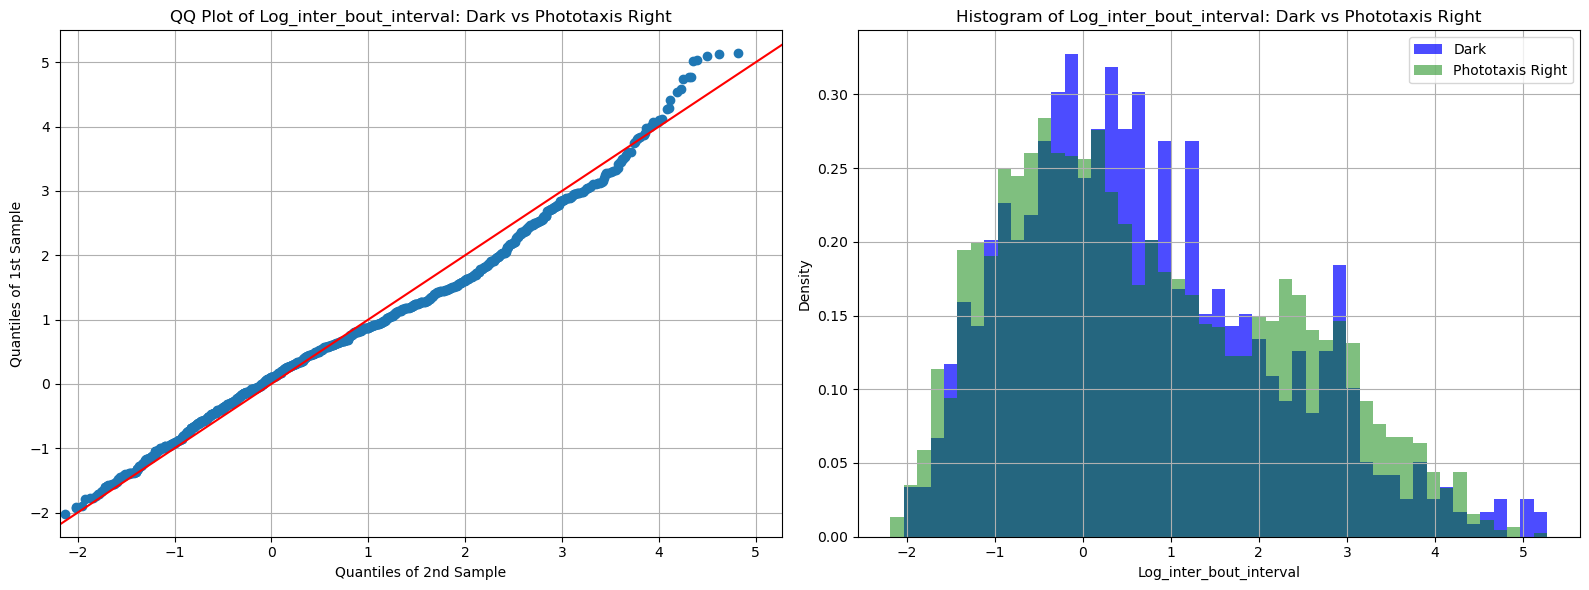

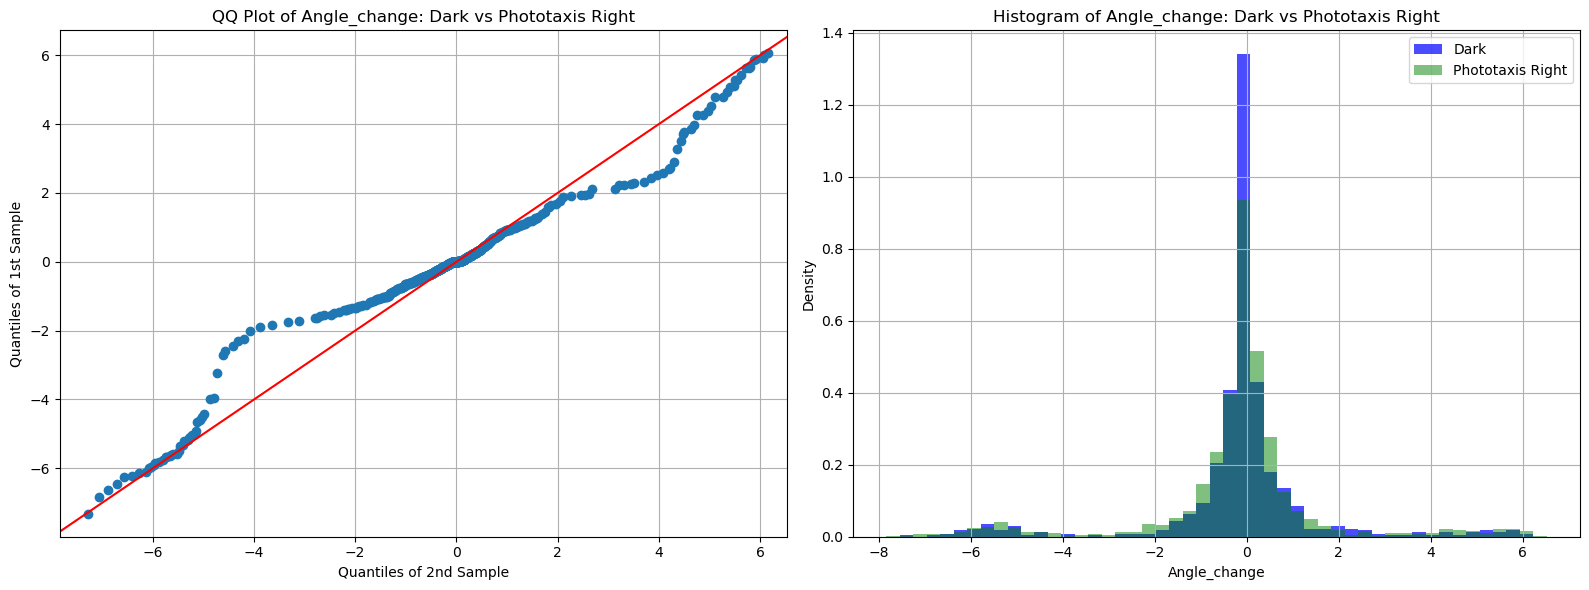

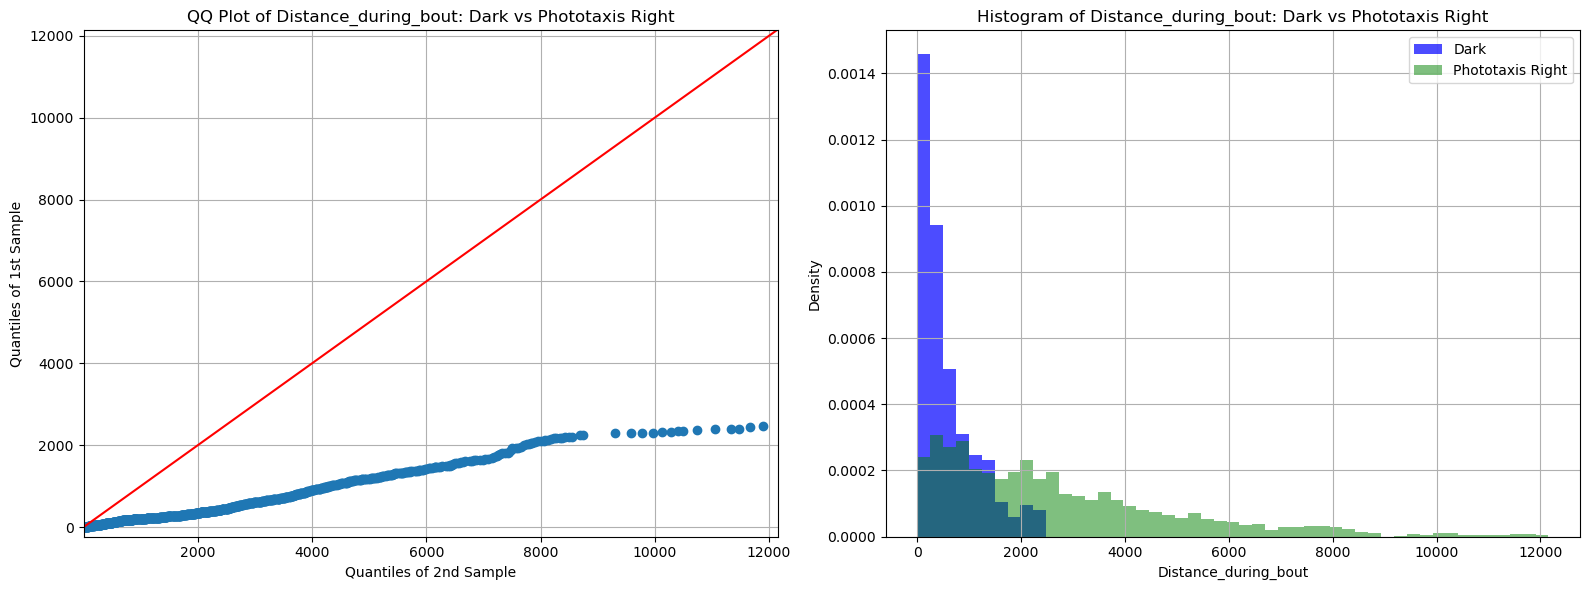

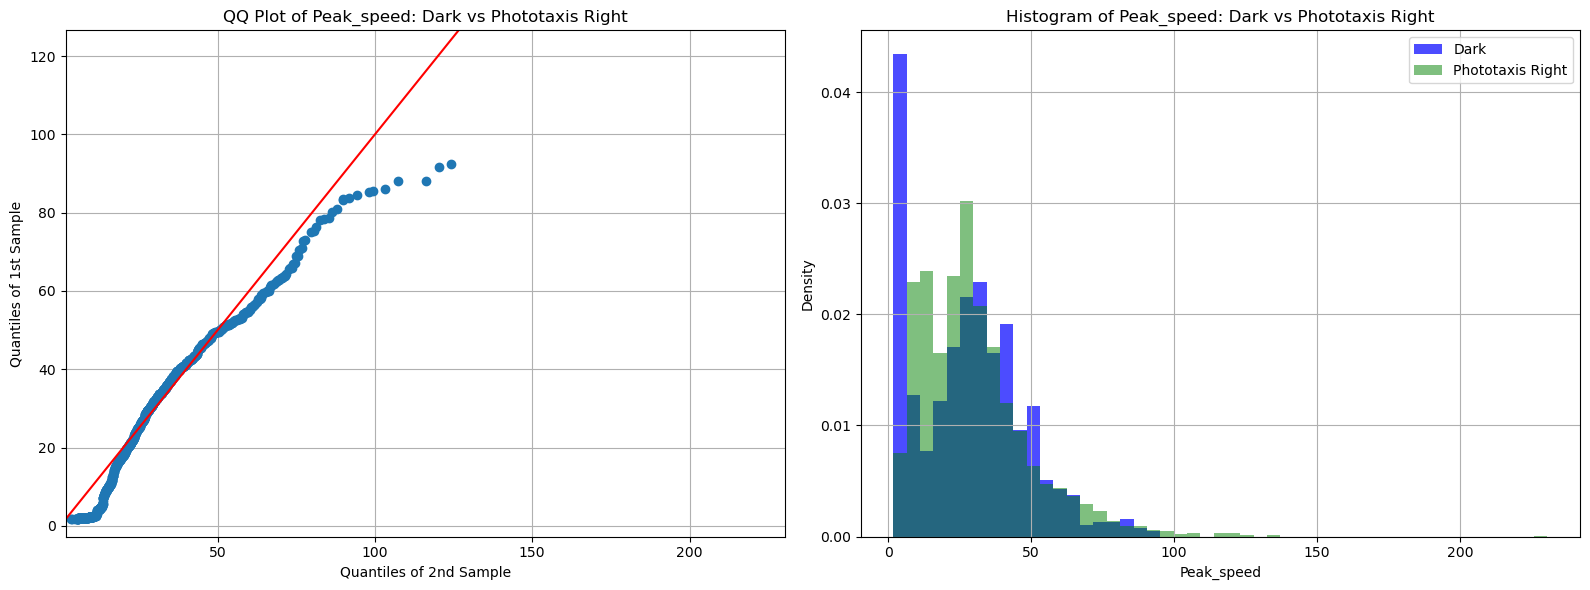

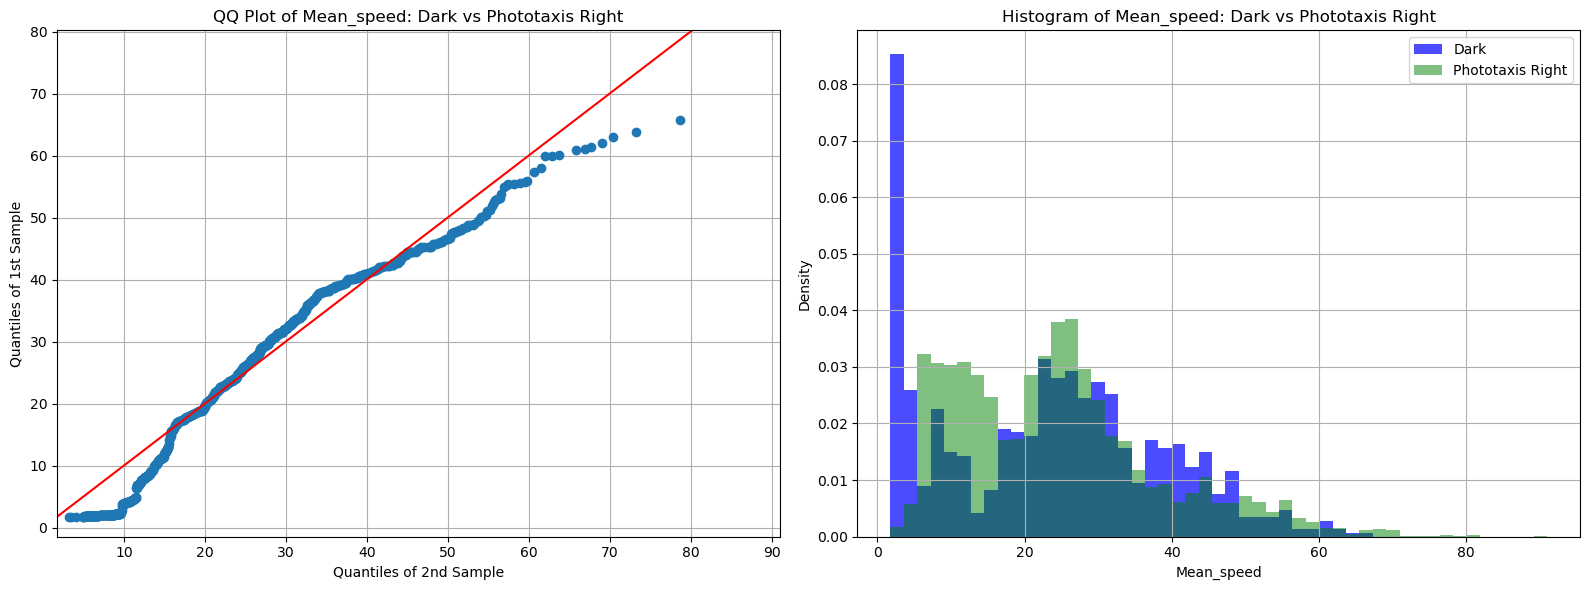

In [286]:
columns_to_analyze = ['duration', 'log_inter_bout_interval', 'angle_change', 
                      'distance_during_bout', 'peak_speed', 'mean_speed']

for column in columns_to_analyze:
    plot_bout_property_comparison(
        bout_properties_df1=bout_properties_df_dark,
        bout_properties_df2=bout_properties_df_phototaxis_right,
        label1='Dark',
        label2='Phototaxis Right',
        column=column,
        bins=50
    )